In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import polars as pl
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm


In [2]:
class WeightedR2:
    def __call__(self, y_pred, y_true, weights):
        # Compute total sum of squares (TSS)
        tss = torch.sum(weights * y_true ** 2)
        # Compute residual sum of squares (RSS)
        rss = torch.sum(weights * (y_true - y_pred) ** 2)
        # Compute R²
        r2 = 1 - (rss / tss)
        return r2.item()

In [3]:
# Prepare a custom weighted mse loss
class weighted_mse_loss(nn.Module):
    def __init__(self):
        super(weighted_mse_loss, self).__init__()
      
    def forward(self, outputs, target, weights):
        return torch.mean(weights * (outputs - target) ** 2)
    

In [4]:
def training_model(model, train_dataloader, test_dataloader, optimizer, loss_fn, metric_fn, epochs=10):
    weighted_mse_train = []
    weighted_mse_test = []
    weighted_r2_train = []
    weighted_r2_test = []

    for i in range(epochs):
        print(f"Epoch {i+1} / {epochs} -------\n")
        train_loss, r2_train = 0, 0

        for (X_train, y_train, train_weights) in tqdm(train_dataloader):
            X_train, y_train, train_weights = X_train.to(device), y_train.to(device), train_weights.to(device)
            model.train()
            y_train_pred = model(X_train)

            # Compute loss
            loss = loss_fn(y_train_pred, y_train, train_weights)
            train_loss += loss.item()
            weighted_mse_train.append(loss.item())  # Append scalar value

            # Compute R2 score
            r2_score = metric_fn(y_train_pred, y_train, train_weights)
            r2_train += r2_score
            weighted_r2_train.append(r2_score)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_dataloader)
        r2_train /= len(train_dataloader)

        # Testing
        test_loss, r2_test = 0, 0
        model.eval()
        with torch.inference_mode():
            for (X_test, y_test, val_weights) in tqdm(test_dataloader):
                X_test, y_test, val_weights = X_test.to(device), y_test.to(device), val_weights.to(device)

                # Compute predictions and loss
                test_preds = model(X_test)
                loss = loss_fn(test_preds, y_test, val_weights).item()
                test_loss += loss
                weighted_mse_test.append(loss)  # Append scalar value

                # Compute R2 score
                r2_score = metric_fn(test_preds, y_test, val_weights)
                r2_test += r2_score  # Assume metric_fn returns a tensor
                weighted_r2_test.append(r2_score)

            test_loss /= len(test_dataloader)
            r2_test /= len(test_dataloader)

        print(f"Weighted MSE in training epoch: {train_loss} | Weighted MSE in test epoch: {test_loss}")
        print(f"Weighted R2 score in training epoch: {r2_train} | Weighted R2 in test epoch: {r2_test}")

    return weighted_mse_train, weighted_mse_test, weighted_r2_train, weighted_r2_test


            
            
        
            
            
        


In [5]:
df = pl.scan_parquet(
    f"/home/jupyter/train.parquet")
print('Data read')


# Preprocessing
# Take the first part for training 
df = df.filter((pl.col("date_id") >= 500) & (pl.col("date_id") <= 1675))

def preprocessing(df):
    # Schema collection for efficiency
    schema = df.collect_schema()
    
    # Create a unique timescale of datetime_id
    df = df.with_columns(
        (pl.col('date_id').cast(pl.Int64) * 5000 + pl.col('time_id').cast(pl.Int64))
        .rank("dense").alias('datetime_id') - 1
    )
    print('Datetime_id added .. ')
    
    # Impute missing values with mean over datetime_id
    df = df.with_columns([
        pl.when(pl.col(col).is_null())
          .then(pl.col(col).mean().over("datetime_id"))
          .otherwise(pl.col(col))
          .alias(col)
        for col in schema if col not in ['time_id', 'symbol_id', 'date_id']
    ])
    print('Imputed with mean over datetime_id .. ')
    
    # Normalize feature columns
    feat_cols = [f"feature_{idx:02d}" for idx in range(79)]
    df = df.with_columns([
        ((pl.col(col) - pl.col(col).mean()) / pl.col(col).std()).alias(col)
        for col in feat_cols if col in schema
    ])
    print('Features normalized .. ')
    
    # Drop unnecessary columns
    columns_to_drop = ['responder_0', 'responder_1', 'responder_2', 'responder_3', 
                       'responder_4', 'responder_5', 'responder_7', 'responder_8', 
                       'partition_id']
    df = df.drop(columns_to_drop)
    print('Dropped unnecessary columns .. ')
    
    df = df.collect()
    # Forward fill nulls
    df = df.fill_null(0)
    df = df.fill_nan(0)
    print('Dataset imputed .. ')
    
    return df




Data read


In [6]:
#! pip install torch
def prepare_tensors_and_batches(df_train, df_val):
    X_train = df_train.select(feat_cols)
    y_train = df_train.select('responder_6')
    train_weights = df_train.select('weight')
    X_test = df_val.select(feat_cols)
    y_test = df_val.select('responder_6')
    val_weights = df_val.select('weight')
    # Convert data to tensors
    X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32, device = device)
    y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32, device = device)
    train_weights = torch.tensor(train_weights.to_numpy(), dtype=torch.float32, device = device)
    X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32, device = device)
    y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32, device = device)
    val_weights = torch.tensor(val_weights.to_numpy(), dtype=torch.float32, device = device)
    print('Converted polars data to tensors')
    train_dataset = Data(X_train, y_train, train_weights)
    test_dataset = Data(X_test, y_test, val_weights)
    print('Preparing dataloaders...')
    train_dataloader = DataLoader(train_dataset, batch_size = 2000, shuffle = False)
    test_dataloader = DataLoader(test_dataset, batch_size = len(test_dataset), shuffle = False)
    print('Dataloaders ready!')
    return train_dataloader, test_dataloader



In [7]:
def check_nulls_nans(df):
    df_nulls = df.select([pl.col(col).is_null().sum() for col in df.collect_schema()])
    df_nans = df.select([pl.col(col).is_nan().sum() for col in df.collect_schema()])
    print("No null values!" if df_nulls.to_numpy().all() == 0 else "There are still null values")
    print("No nan values!" if df_nans.to_numpy().all() == 0 else "There are still nan values")



In [8]:
# Create a custom dataset class for batch training
class Data(Dataset):
    def __init__(self, features, target, weights):
        self.features = features
        self.target = target
        self.weights = weights
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        return self.features[idx], self.target[idx], self.weights[idx]

In [9]:
# Create a neural network class
class Model_1(nn.Module):
    def __init__(self, input_features):
        super().__init__()
        self.stack_layer = nn.Sequential(nn.Linear(in_features = input_features, out_features = 64),
                                         nn.ReLU(),
                                         nn.Dropout(0.2),
                                         nn.Linear(in_features = 64, out_features = 32),
                                         nn.ReLU(),
                                         nn.Dropout(0.2),
                                         nn.Linear(in_features = 32, out_features = 1))
    def forward(self, x):
        return self.stack_layer(x)
    

In [10]:
#symbols_id = [f"symbol_id_{i}" for i in range(39)]
feat_cols = [f"feature_{idx:02d}" for idx in range(79)]
features_cols = feat_cols
# device agnostic code
device = 'cuda' if torch.cuda.is_available() else "cpu"

# Initialize num of cols, model, loss, metric and optimizer
number_cols = len(features_cols)
model_1 = Model_1(number_cols)
loss = weighted_mse_loss()
weighted_r2 = WeightedR2()
# Weight decay for L2 regularization
optimizer = torch.optim.Adam(model_1.parameters(), lr = 1e-3, weight_decay = 1e-05)

def online_learning_model(model, df, loss, metric, optimizer, rolling_window= 3 * 964, forecast_period= 964):
    train_weighted_mse = []
    test_weighted_mse = []
    train_r2_score = []
    test_r2_score = []
 
    

    # Preprocess the DataFrame
    df = df.pipe(preprocessing)
    
    # Checking if there are null or nan values after preprocessing
    check_nulls_nans(df)
    
    # Sort by `datetime_id` to ensure continuity
    df = df.sort('datetime_id')



    # Extract unique `datetime_id` for slicing
    datetime_ids = df['datetime_id'].unique().to_list()
    print(f"Length of unique datetime_ids: {len(datetime_ids)}")

    # Iterate through the timeline with forecast_period steps
    for i in range(rolling_window, len(datetime_ids), forecast_period):
        train_start = i - rolling_window
        train_end = min(i - 1, len(datetime_ids) - 1)
        test_start = i
        test_end = min(len(datetime_ids) - 1, test_start + forecast_period - 1)

            
        print(f"Training range: {train_start} to {train_end}, Testing range: {test_start} to {test_end}, Rolling_window {rolling_window}")
        
        # Slice training and testing sets by `datetime_id`
        train_datetime_ids = datetime_ids[train_start:train_end + 1]
        test_datetime_ids = datetime_ids[test_start:test_end + 1]

        

        # Filter the DataFrame for the training set based on `datetime_id`
        df_train = df.filter(pl.col('datetime_id').is_in(train_datetime_ids))
    
        # Filter the DataFrame for the testing set based on `datetime_id`
        df_test = df.filter(pl.col('datetime_id').is_in(test_datetime_ids))
        
        
        # Prepare the data
        train_dataloader, test_dataloader = prepare_tensors_and_batches(df_train,df_test)
        
       
        
        # Train model and predict on validation set
        weighted_mse_train, weighted_mse_test, weighted_r2_train, weighted_r2_test = training_model(model, train_dataloader, test_dataloader, optimizer,
                                                                                                    loss, metric, epochs = 1)
        
        train_weighted_mse.append(weighted_mse_train[-1])
        test_weighted_mse.append(weighted_mse_test[-1])
        train_r2_score.append(weighted_r2_train[-1])
        test_r2_score.append(weighted_r2_test[-1])
           
        

        

        
        
    return train_weighted_mse, test_weighted_mse, train_r2_score, test_r2_score, model


def offline_training_model(model, df, loss, metric, optimizer):
    

    # Preprocess the DataFrame
    df = df.pipe(preprocessing)
    # Checking if there are null or nan values after preprocessing
    check_nulls_nans(df)
    
    # Sort by `datetime_id` to ensure continuity
    df = df.sort('datetime_id')

        

    # Filter the DataFrame for the training set based on `datetime_id`
    df_train = df.filter(pl.col('date_id') < 1400)
    
    # Filter the DataFrame for the testing set based on `datetime_id`
    df_test = df.filter(pl.col('date_id') >= 1400)
        
        
    # Prepare the data
    train_dataloader, test_dataloader = prepare_tensors_and_batches(df_train,df_test)
        
       
        
    # Train model and predict on validation set
    weighted_mse_train, weighted_mse_test, weighted_r2_train, weighted_r2_test = training_model(model, train_dataloader, test_dataloader, optimizer,
                                                                                                    loss, metric, epochs = 1)
        
     
        

        

        
        
    return weighted_mse_train, weighted_mse_test, weighted_r2_train, weighted_r2_test, model



train_weighted_mse, test_weighted_mse, train_r2_score, test_r2_score, model = online_learning_model(model_1, df, loss, weighted_r2, optimizer)
#train_weighted_mse, test_weighted_mse, train_r2_score, test_r2_score, model = offline_training_model(model_1, df, loss, weighted_r2, optimizer)

Datetime_id added .. 
Imputed with mean over datetime_id .. 
Features normalized .. 
Dropped unnecessary columns .. 
Dataset imputed .. 
No null values!
No nan values!
Length of unique datetime_ids: 1117305
Training range: 0 to 2891, Testing range: 2892 to 3855, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2122741806797865 | Weighted MSE in test epoch: 1.69919753074646
Weighted R2 score in training epoch: -0.00869386225211911 | Weighted R2 in test epoch: -0.0006557703018188477
Training range: 964 to 3855, Testing range: 3856 to 4819, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4225513070821763 | Weighted MSE in test epoch: 1.450227975845337
Weighted R2 score in training epoch: 0.003986559808254242 | Weighted R2 in test epoch: 0.0022886991500854492
Training range: 1928 to 4819, Testing range: 4820 to 5783, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.546589894592762 | Weighted MSE in test epoch: 1.238929271697998
Weighted R2 score in training epoch: 0.006791716814041138 | Weighted R2 in test epoch: 0.004004955291748047
Training range: 2892 to 5783, Testing range: 5784 to 6747, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4401874244213104 | Weighted MSE in test epoch: 1.6007486581802368
Weighted R2 score in training epoch: 0.009180791676044464 | Weighted R2 in test epoch: 0.003540337085723877
Training range: 3856 to 6747, Testing range: 6748 to 7711, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.421013462834242 | Weighted MSE in test epoch: 1.6153202056884766
Weighted R2 score in training epoch: 0.010370693555692347 | Weighted R2 in test epoch: 0.004151046276092529
Training range: 4820 to 7711, Testing range: 7712 to 8675, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4978198249165604 | Weighted MSE in test epoch: 1.3429452180862427
Weighted R2 score in training epoch: 0.00795145151091785 | Weighted R2 in test epoch: -0.006917476654052734
Training range: 5784 to 8675, Testing range: 8676 to 9639, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5059496687679756 | Weighted MSE in test epoch: 1.3441776037216187
Weighted R2 score in training epoch: 0.004772729989958972 | Weighted R2 in test epoch: 0.005173981189727783
Training range: 6748 to 9639, Testing range: 9640 to 10603, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4168512283301935 | Weighted MSE in test epoch: 1.836063027381897
Weighted R2 score in training epoch: 0.0057619926406116025 | Weighted R2 in test epoch: -0.005612373352050781
Training range: 7712 to 10603, Testing range: 10604 to 11567, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4835587129360293 | Weighted MSE in test epoch: 1.9273934364318848
Weighted R2 score in training epoch: 0.004812590959595471 | Weighted R2 in test epoch: 0.0043405890464782715
Training range: 8676 to 11567, Testing range: 11568 to 12531, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6836015029651363 | Weighted MSE in test epoch: 2.3647775650024414
Weighted R2 score in training epoch: 0.008886145382392697 | Weighted R2 in test epoch: 0.0008288025856018066
Training range: 9640 to 12531, Testing range: 12532 to 13495, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.014945659695602 | Weighted MSE in test epoch: 1.7356483936309814
Weighted R2 score in training epoch: 0.010385011754384854 | Weighted R2 in test epoch: 0.004045605659484863
Training range: 10604 to 13495, Testing range: 13496 to 14459, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.9691684405978134 | Weighted MSE in test epoch: 1.9897582530975342
Weighted R2 score in training epoch: 0.010800624766000888 | Weighted R2 in test epoch: 0.008242130279541016
Training range: 11568 to 14459, Testing range: 14460 to 15423, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.0364394376917585 | Weighted MSE in test epoch: 1.8900668621063232
Weighted R2 score in training epoch: 0.013776784989891983 | Weighted R2 in test epoch: -0.01002037525177002
Training range: 12532 to 15423, Testing range: 15424 to 16387, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8584167404872616 | Weighted MSE in test epoch: 1.502406358718872
Weighted R2 score in training epoch: 0.00901281979025864 | Weighted R2 in test epoch: -0.0047266483306884766
Training range: 13496 to 16387, Testing range: 16388 to 17351, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7663603904770642 | Weighted MSE in test epoch: 0.9824958443641663
Weighted R2 score in training epoch: 0.008610017415953845 | Weighted R2 in test epoch: -0.009394526481628418
Training range: 14460 to 17351, Testing range: 17352 to 18315, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.435678564920658 | Weighted MSE in test epoch: 1.3531631231307983
Weighted R2 score in training epoch: -0.0010802833045401225 | Weighted R2 in test epoch: -0.0033736228942871094
Training range: 15424 to 18315, Testing range: 18316 to 19279, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2767611596642472 | Weighted MSE in test epoch: 1.527244210243225
Weighted R2 score in training epoch: -0.0002564133667364353 | Weighted R2 in test epoch: 0.00816565752029419
Training range: 16388 to 19279, Testing range: 19280 to 20243, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2824716618875178 | Weighted MSE in test epoch: 2.519542932510376
Weighted R2 score in training epoch: 0.005130344774664902 | Weighted R2 in test epoch: 0.006365597248077393
Training range: 17352 to 20243, Testing range: 20244 to 21207, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.779773992736165 | Weighted MSE in test epoch: 1.7282462120056152
Weighted R2 score in training epoch: 0.007908101488904255 | Weighted R2 in test epoch: -0.007368206977844238
Training range: 18316 to 21207, Testing range: 21208 to 22171, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.9088915513782967 | Weighted MSE in test epoch: 1.6242671012878418
Weighted R2 score in training epoch: 0.007149862080085568 | Weighted R2 in test epoch: 0.014127671718597412
Training range: 19280 to 22171, Testing range: 22172 to 23135, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.942577724049731 | Weighted MSE in test epoch: 1.3974827527999878
Weighted R2 score in training epoch: 0.006943714327928497 | Weighted R2 in test epoch: -0.003341197967529297
Training range: 20244 to 23135, Testing range: 23136 to 24099, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.559651238162343 | Weighted MSE in test epoch: 1.0508705377578735
Weighted R2 score in training epoch: 0.0024072513347718773 | Weighted R2 in test epoch: -0.0005986690521240234
Training range: 21208 to 24099, Testing range: 24100 to 25063, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3403103482432481 | Weighted MSE in test epoch: 1.0935616493225098
Weighted R2 score in training epoch: 0.0023945482765756003 | Weighted R2 in test epoch: 0.011306941509246826
Training range: 22172 to 25063, Testing range: 25064 to 26027, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1681476119087963 | Weighted MSE in test epoch: 1.2673150300979614
Weighted R2 score in training epoch: 0.007250096739792242 | Weighted R2 in test epoch: 0.0036789774894714355
Training range: 23136 to 26027, Testing range: 26028 to 26991, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1463986533444102 | Weighted MSE in test epoch: 1.0578334331512451
Weighted R2 score in training epoch: 0.010750551049302264 | Weighted R2 in test epoch: 0.016133248805999756
Training range: 24100 to 26991, Testing range: 26992 to 27955, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1267131944982016 | Weighted MSE in test epoch: 1.0801087617874146
Weighted R2 score in training epoch: 0.01572267456752498 | Weighted R2 in test epoch: 0.0014892220497131348
Training range: 25064 to 27955, Testing range: 27956 to 28919, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1355864827225848 | Weighted MSE in test epoch: 1.282810091972351
Weighted R2 score in training epoch: 0.011729147376083746 | Weighted R2 in test epoch: 9.429454803466797e-05
Training range: 26028 to 28919, Testing range: 28920 to 29883, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.156557791843647 | Weighted MSE in test epoch: 1.1883621215820312
Weighted R2 score in training epoch: 0.01143318269310928 | Weighted R2 in test epoch: -0.00235140323638916
Training range: 26992 to 29883, Testing range: 29884 to 30847, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1950289992297567 | Weighted MSE in test epoch: 1.1842259168624878
Weighted R2 score in training epoch: 0.007670957867692157 | Weighted R2 in test epoch: 0.003907561302185059
Training range: 27956 to 30847, Testing range: 30848 to 31811, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.207981225848198 | Weighted MSE in test epoch: 1.324156641960144
Weighted R2 score in training epoch: 0.003586755692958832 | Weighted R2 in test epoch: -0.006073474884033203
Training range: 28920 to 31811, Testing range: 31812 to 32775, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.220356523226469 | Weighted MSE in test epoch: 1.282824993133545
Weighted R2 score in training epoch: 0.0024216801692277957 | Weighted R2 in test epoch: -0.00010538101196289062
Training range: 29884 to 32775, Testing range: 32776 to 33739, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2525305395063602 | Weighted MSE in test epoch: 1.8024370670318604
Weighted R2 score in training epoch: 0.006003957045705695 | Weighted R2 in test epoch: 0.0015267729759216309
Training range: 30848 to 33739, Testing range: 33740 to 34703, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.465835914397851 | Weighted MSE in test epoch: 1.3544858694076538
Weighted R2 score in training epoch: 0.00047252728388859675 | Weighted R2 in test epoch: 0.009750127792358398
Training range: 31812 to 34703, Testing range: 34704 to 35667, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4803519612405358 | Weighted MSE in test epoch: 1.5282542705535889
Weighted R2 score in training epoch: 0.0068215713268373075 | Weighted R2 in test epoch: -0.0013271570205688477
Training range: 32776 to 35667, Testing range: 35668 to 36631, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.555634203480511 | Weighted MSE in test epoch: 1.210307240486145
Weighted R2 score in training epoch: 0.003701297248282084 | Weighted R2 in test epoch: 0.009721159934997559
Training range: 33740 to 36631, Testing range: 36632 to 37595, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.364035509708451 | Weighted MSE in test epoch: 1.2672648429870605
Weighted R2 score in training epoch: 0.00896211077527302 | Weighted R2 in test epoch: -0.004831075668334961
Training range: 34704 to 37595, Testing range: 37596 to 38559, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.316133283987278 | Weighted MSE in test epoch: 1.1708039045333862
Weighted R2 score in training epoch: 0.007477241318400313 | Weighted R2 in test epoch: 0.00843435525894165
Training range: 35668 to 38559, Testing range: 38560 to 39523, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1897732513706858 | Weighted MSE in test epoch: 1.50582754611969
Weighted R2 score in training epoch: 0.010803270630720185 | Weighted R2 in test epoch: 0.004191339015960693
Training range: 36632 to 39523, Testing range: 39524 to 40487, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2890611523535194 | Weighted MSE in test epoch: 1.751052737236023
Weighted R2 score in training epoch: 0.011491730445768775 | Weighted R2 in test epoch: 0.0059950947761535645
Training range: 37596 to 40487, Testing range: 40488 to 41451, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4577564800657876 | Weighted MSE in test epoch: 1.4945869445800781
Weighted R2 score in training epoch: 0.005899548530578613 | Weighted R2 in test epoch: 0.027096807956695557
Training range: 38560 to 41451, Testing range: 41452 to 42415, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.56844090397765 | Weighted MSE in test epoch: 2.225492477416992
Weighted R2 score in training epoch: 0.015686087492035657 | Weighted R2 in test epoch: -0.004273772239685059
Training range: 39524 to 42415, Testing range: 42416 to 43379, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8252301434191263 | Weighted MSE in test epoch: 3.0704126358032227
Weighted R2 score in training epoch: 0.009128390288934475 | Weighted R2 in test epoch: -0.010438323020935059
Training range: 40488 to 43379, Testing range: 43380 to 44343, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.2700679258602423 | Weighted MSE in test epoch: 2.4259896278381348
Weighted R2 score in training epoch: 0.006444036960601807 | Weighted R2 in test epoch: 0.005189418792724609
Training range: 41452 to 44343, Testing range: 44344 to 45307, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.529996541942038 | Weighted MSE in test epoch: 7.437320709228516
Weighted R2 score in training epoch: 0.006340279811766089 | Weighted R2 in test epoch: -0.0005638599395751953
Training range: 42416 to 45307, Testing range: 45308 to 46271, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 4.273585885763168 | Weighted MSE in test epoch: 2.814344644546509
Weighted R2 score in training epoch: 0.005020140111446381 | Weighted R2 in test epoch: -0.00028145313262939453
Training range: 43380 to 46271, Testing range: 46272 to 47235, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 4.088115697953759 | Weighted MSE in test epoch: 2.42938494682312
Weighted R2 score in training epoch: -0.005136561102983429 | Weighted R2 in test epoch: -0.004296422004699707
Training range: 44344 to 47235, Testing range: 47236 to 48199, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 4.036672635776241 | Weighted MSE in test epoch: 1.6305691003799438
Weighted R2 score in training epoch: 0.0019382558217862758 | Weighted R2 in test epoch: -0.03319978713989258
Training range: 45308 to 48199, Testing range: 48200 to 49163, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.2592929289454506 | Weighted MSE in test epoch: 1.247615098953247
Weighted R2 score in training epoch: 0.0004297778719947452 | Weighted R2 in test epoch: 0.0002766847610473633
Training range: 46272 to 49163, Testing range: 49164 to 50127, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7383440896159126 | Weighted MSE in test epoch: 1.5611629486083984
Weighted R2 score in training epoch: 0.004316442069553193 | Weighted R2 in test epoch: 0.0021857023239135742
Training range: 47236 to 50127, Testing range: 50128 to 51091, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4650130484785353 | Weighted MSE in test epoch: 1.72748863697052
Weighted R2 score in training epoch: 0.004139216173262824 | Weighted R2 in test epoch: -0.004941463470458984
Training range: 48200 to 51091, Testing range: 51092 to 52055, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.504459057535444 | Weighted MSE in test epoch: 0.9499912261962891
Weighted R2 score in training epoch: 0.004244675238927205 | Weighted R2 in test epoch: 0.01199352741241455
Training range: 49164 to 52055, Testing range: 52056 to 53019, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.398844811178389 | Weighted MSE in test epoch: 1.0056928396224976
Weighted R2 score in training epoch: 0.00733574941044762 | Weighted R2 in test epoch: -0.006642341613769531
Training range: 50128 to 53019, Testing range: 53020 to 53983, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2180835547901334 | Weighted MSE in test epoch: 1.015982747077942
Weighted R2 score in training epoch: 0.004899144172668457 | Weighted R2 in test epoch: 0.010883092880249023
Training range: 51092 to 53983, Testing range: 53984 to 54947, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9843597816569465 | Weighted MSE in test epoch: 0.9612566828727722
Weighted R2 score in training epoch: 0.010204997800645373 | Weighted R2 in test epoch: 0.009918510913848877
Training range: 52056 to 54947, Testing range: 54948 to 55911, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.988441736925216 | Weighted MSE in test epoch: 0.7492745518684387
Weighted R2 score in training epoch: 0.013291578917276291 | Weighted R2 in test epoch: 0.01912134885787964
Training range: 53020 to 55911, Testing range: 55912 to 56875, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9062027899282319 | Weighted MSE in test epoch: 0.6962735652923584
Weighted R2 score in training epoch: 0.015999180930001394 | Weighted R2 in test epoch: 0.01233208179473877
Training range: 53984 to 56875, Testing range: 56876 to 57839, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7985999133615267 | Weighted MSE in test epoch: 1.0052472352981567
Weighted R2 score in training epoch: 0.01667812324705578 | Weighted R2 in test epoch: -0.00307464599609375
Training range: 54948 to 57839, Testing range: 57840 to 58803, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8161052295139858 | Weighted MSE in test epoch: 0.5662997364997864
Weighted R2 score in training epoch: 0.010518251430420648 | Weighted R2 in test epoch: 0.009554684162139893
Training range: 55912 to 58803, Testing range: 58804 to 59767, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7499002463051251 | Weighted MSE in test epoch: 0.37509214878082275
Weighted R2 score in training epoch: 0.01433744742756798 | Weighted R2 in test epoch: -0.0020464658737182617
Training range: 56876 to 59767, Testing range: 59768 to 60731, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6404167937026137 | Weighted MSE in test epoch: 0.4273717701435089
Weighted R2 score in training epoch: 0.009009513117018201 | Weighted R2 in test epoch: 0.012065470218658447
Training range: 57840 to 60731, Testing range: 60732 to 61695, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.4539385987889199 | Weighted MSE in test epoch: 0.6451552510261536
Weighted R2 score in training epoch: 0.01006442734173366 | Weighted R2 in test epoch: 0.004885494709014893
Training range: 58804 to 61695, Testing range: 61696 to 62659, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.4817497895232269 | Weighted MSE in test epoch: 0.7839440703392029
Weighted R2 score in training epoch: 0.005040476719538371 | Weighted R2 in test epoch: 0.005461394786834717
Training range: 59768 to 62659, Testing range: 62660 to 63623, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6166427781184515 | Weighted MSE in test epoch: 0.7390824556350708
Weighted R2 score in training epoch: 0.004708835056849888 | Weighted R2 in test epoch: -0.005695462226867676
Training range: 60732 to 63623, Testing range: 63624 to 64587, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7199402377009392 | Weighted MSE in test epoch: 0.8576593399047852
Weighted R2 score in training epoch: 0.007192935262407575 | Weighted R2 in test epoch: 0.009061157703399658
Training range: 61696 to 64587, Testing range: 64588 to 65551, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8144472418796449 | Weighted MSE in test epoch: 0.6777563691139221
Weighted R2 score in training epoch: 0.009230250403994606 | Weighted R2 in test epoch: -0.0036437511444091797
Training range: 62660 to 65551, Testing range: 65552 to 66515, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7522626512107395 | Weighted MSE in test epoch: 0.6090858578681946
Weighted R2 score in training epoch: 0.007235027494884673 | Weighted R2 in test epoch: 0.0037232041358947754
Training range: 63624 to 66515, Testing range: 66516 to 67479, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7056151138884681 | Weighted MSE in test epoch: 0.9295273423194885
Weighted R2 score in training epoch: 0.006592015425364177 | Weighted R2 in test epoch: 0.021408379077911377
Training range: 64588 to 67479, Testing range: 67480 to 68443, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7327303134259724 | Weighted MSE in test epoch: 0.867205023765564
Weighted R2 score in training epoch: 0.013207024052029564 | Weighted R2 in test epoch: 0.010564148426055908
Training range: 65552 to 68443, Testing range: 68444 to 69407, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7926369862897056 | Weighted MSE in test epoch: 0.9215372800827026
Weighted R2 score in training epoch: 0.01420682810601734 | Weighted R2 in test epoch: 0.009142637252807617
Training range: 66516 to 69407, Testing range: 69408 to 70371, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9032920540832892 | Weighted MSE in test epoch: 0.9598269462585449
Weighted R2 score in training epoch: 0.015433091942856952 | Weighted R2 in test epoch: 0.01562345027923584
Training range: 67480 to 70371, Testing range: 70372 to 71335, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9147615127447175 | Weighted MSE in test epoch: 1.7361698150634766
Weighted R2 score in training epoch: 0.016285099634310095 | Weighted R2 in test epoch: 0.010169029235839844
Training range: 68444 to 71335, Testing range: 71336 to 72299, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2572922263203599 | Weighted MSE in test epoch: 1.2778669595718384
Weighted R2 score in training epoch: 0.015932436396435993 | Weighted R2 in test epoch: 0.01111912727355957
Training range: 69408 to 72299, Testing range: 72300 to 73263, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3144051621599895 | Weighted MSE in test epoch: 0.985140860080719
Weighted R2 score in training epoch: 0.01831860222467562 | Weighted R2 in test epoch: 0.03314650058746338
Training range: 70372 to 73263, Testing range: 73264 to 74227, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3089593830632 | Weighted MSE in test epoch: 1.128048300743103
Weighted R2 score in training epoch: 0.017946051388252074 | Weighted R2 in test epoch: -0.011010408401489258
Training range: 71336 to 74227, Testing range: 74228 to 75191, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1107182393713695 | Weighted MSE in test epoch: 1.0244419574737549
Weighted R2 score in training epoch: 0.01408695011604123 | Weighted R2 in test epoch: -0.012551546096801758
Training range: 72300 to 75191, Testing range: 75192 to 76155, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.021834144505059 | Weighted MSE in test epoch: 1.1707268953323364
Weighted R2 score in training epoch: 0.013982713222503662 | Weighted R2 in test epoch: 0.01915431022644043
Training range: 73264 to 76155, Testing range: 76156 to 77119, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0848028536249952 | Weighted MSE in test epoch: 1.4366425275802612
Weighted R2 score in training epoch: 0.018749822930591863 | Weighted R2 in test epoch: 0.0007702112197875977
Training range: 74228 to 77119, Testing range: 77120 to 78083, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2132096239706365 | Weighted MSE in test epoch: 1.4409512281417847
Weighted R2 score in training epoch: 0.015027963533634094 | Weighted R2 in test epoch: 0.007358968257904053
Training range: 75192 to 78083, Testing range: 78084 to 79047, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3539259048496806 | Weighted MSE in test epoch: 1.5100938081741333
Weighted R2 score in training epoch: 0.016170609288099335 | Weighted R2 in test epoch: 0.0055348873138427734
Training range: 76156 to 79047, Testing range: 79048 to 80011, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4526032500150727 | Weighted MSE in test epoch: 0.8831658363342285
Weighted R2 score in training epoch: 0.014623422448228045 | Weighted R2 in test epoch: 0.0019519925117492676
Training range: 77120 to 80011, Testing range: 80012 to 80975, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2589878745195342 | Weighted MSE in test epoch: 0.9961593747138977
Weighted R2 score in training epoch: 0.014019832378480493 | Weighted R2 in test epoch: 0.0033614635467529297
Training range: 78084 to 80975, Testing range: 80976 to 81939, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.11020340643278 | Weighted MSE in test epoch: 0.8552558422088623
Weighted R2 score in training epoch: 0.015356731124040558 | Weighted R2 in test epoch: 0.007072806358337402
Training range: 79048 to 81939, Testing range: 81940 to 82903, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9024582156320897 | Weighted MSE in test epoch: 1.0504430532455444
Weighted R2 score in training epoch: 0.015564879266227164 | Weighted R2 in test epoch: 0.003826320171356201
Training range: 80012 to 82903, Testing range: 82904 to 83867, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9610450936526787 | Weighted MSE in test epoch: 1.2425838708877563
Weighted R2 score in training epoch: 0.013634217948448367 | Weighted R2 in test epoch: 0.001219332218170166
Training range: 80976 to 83867, Testing range: 83868 to 84831, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0397363806643136 | Weighted MSE in test epoch: 1.3568483591079712
Weighted R2 score in training epoch: 0.013358201922439947 | Weighted R2 in test epoch: -0.005587100982666016
Training range: 81940 to 84831, Testing range: 84832 to 85795, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2230677902698517 | Weighted MSE in test epoch: 1.1209545135498047
Weighted R2 score in training epoch: 0.007211395880071129 | Weighted R2 in test epoch: 0.008789658546447754
Training range: 82904 to 85795, Testing range: 85796 to 86759, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2753417535525997 | Weighted MSE in test epoch: 0.9940013885498047
Weighted R2 score in training epoch: 0.009660427163286908 | Weighted R2 in test epoch: 0.016260206699371338
Training range: 83868 to 86759, Testing range: 86760 to 87723, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1490911416709424 | Weighted MSE in test epoch: 0.9740855693817139
Weighted R2 score in training epoch: 0.015184426307678222 | Weighted R2 in test epoch: 0.009977400302886963
Training range: 84832 to 87723, Testing range: 87724 to 88687, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0218285135924816 | Weighted MSE in test epoch: 0.9184292554855347
Weighted R2 score in training epoch: 0.01791786849498749 | Weighted R2 in test epoch: 0.008859217166900635
Training range: 85796 to 88687, Testing range: 88688 to 89651, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9485619715074214 | Weighted MSE in test epoch: 1.147368311882019
Weighted R2 score in training epoch: 0.018833449700983558 | Weighted R2 in test epoch: 0.011614799499511719
Training range: 86760 to 89651, Testing range: 89652 to 90615, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0061951823532582 | Weighted MSE in test epoch: 1.4230965375900269
Weighted R2 score in training epoch: 0.014619579911231995 | Weighted R2 in test epoch: 0.007962584495544434
Training range: 87724 to 90615, Testing range: 90616 to 91579, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1610125057399272 | Weighted MSE in test epoch: 0.9776978492736816
Weighted R2 score in training epoch: 0.012922324240207672 | Weighted R2 in test epoch: 0.016391515731811523
Training range: 88688 to 91579, Testing range: 91580 to 92543, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.166753128170967 | Weighted MSE in test epoch: 1.2536249160766602
Weighted R2 score in training epoch: 0.015918825566768647 | Weighted R2 in test epoch: 0.0018308162689208984
Training range: 89652 to 92543, Testing range: 92544 to 93507, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3074575714766978 | Weighted MSE in test epoch: 1.3693405389785767
Weighted R2 score in training epoch: 0.014324617385864259 | Weighted R2 in test epoch: 0.004523515701293945
Training range: 90616 to 93507, Testing range: 93508 to 94471, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1885021083056926 | Weighted MSE in test epoch: 0.896020770072937
Weighted R2 score in training epoch: 0.0157062828540802 | Weighted R2 in test epoch: 0.015952467918395996
Training range: 91580 to 94471, Testing range: 94472 to 95435, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.166389443935492 | Weighted MSE in test epoch: 0.7830186486244202
Weighted R2 score in training epoch: 0.01682408956380991 | Weighted R2 in test epoch: -0.010683655738830566
Training range: 92544 to 95435, Testing range: 95436 to 96399, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0065979991967862 | Weighted MSE in test epoch: 1.573561429977417
Weighted R2 score in training epoch: 0.010917350267752623 | Weighted R2 in test epoch: 0.00778806209564209
Training range: 93508 to 96399, Testing range: 96400 to 97363, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0795172670712838 | Weighted MSE in test epoch: 1.2390193939208984
Weighted R2 score in training epoch: 0.012125577682103867 | Weighted R2 in test epoch: 0.016759932041168213
Training range: 94472 to 97363, Testing range: 97364 to 98327, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1896569159550545 | Weighted MSE in test epoch: 0.9465444087982178
Weighted R2 score in training epoch: 0.009295234313377967 | Weighted R2 in test epoch: 0.010838627815246582
Training range: 95436 to 98327, Testing range: 98328 to 99291, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2398449663932507 | Weighted MSE in test epoch: 0.793900191783905
Weighted R2 score in training epoch: 0.01354686419169108 | Weighted R2 in test epoch: 0.017504572868347168
Training range: 96400 to 99291, Testing range: 99292 to 100255, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.990803314325137 | Weighted MSE in test epoch: 1.5493388175964355
Weighted R2 score in training epoch: 0.015413865064963317 | Weighted R2 in test epoch: 0.027651727199554443
Training range: 97364 to 100255, Testing range: 100256 to 101219, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1106530878788385 | Weighted MSE in test epoch: 1.3787002563476562
Weighted R2 score in training epoch: 0.022713324962518155 | Weighted R2 in test epoch: -0.005712032318115234
Training range: 98328 to 101219, Testing range: 101220 to 102183, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2229621372161767 | Weighted MSE in test epoch: 1.8415727615356445
Weighted R2 score in training epoch: 0.016831025099143002 | Weighted R2 in test epoch: -0.020336508750915527
Training range: 99292 to 102183, Testing range: 102184 to 103147, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5545347760885189 | Weighted MSE in test epoch: 1.6046719551086426
Weighted R2 score in training epoch: 0.012471348811418582 | Weighted R2 in test epoch: -0.0070362091064453125
Training range: 100256 to 103147, Testing range: 103148 to 104111, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.575062068609091 | Weighted MSE in test epoch: 1.2962369918823242
Weighted R2 score in training epoch: 0.004801702805054493 | Weighted R2 in test epoch: 0.01519995927810669
Training range: 101220 to 104111, Testing range: 104112 to 105075, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.51544084623456 | Weighted MSE in test epoch: 1.3871506452560425
Weighted R2 score in training epoch: 0.012407858669757844 | Weighted R2 in test epoch: -0.01609814167022705
Training range: 102184 to 105075, Testing range: 105076 to 106039, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.389911337941885 | Weighted MSE in test epoch: 1.0999960899353027
Weighted R2 score in training epoch: 0.008529171347618103 | Weighted R2 in test epoch: 0.007078826427459717
Training range: 103148 to 106039, Testing range: 106040 to 107003, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2456892743706702 | Weighted MSE in test epoch: 1.228325605392456
Weighted R2 score in training epoch: 0.010009008646011352 | Weighted R2 in test epoch: 0.015229344367980957
Training range: 104112 to 107003, Testing range: 107004 to 107967, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2692018620669843 | Weighted MSE in test epoch: 1.2866102457046509
Weighted R2 score in training epoch: 0.004527086019515991 | Weighted R2 in test epoch: 0.004348278045654297
Training range: 105076 to 107967, Testing range: 107968 to 108931, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.228624165058136 | Weighted MSE in test epoch: 0.9996042251586914
Weighted R2 score in training epoch: 0.009556053578853608 | Weighted R2 in test epoch: -0.003420591354370117
Training range: 106040 to 108931, Testing range: 108932 to 109895, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1425784021615981 | Weighted MSE in test epoch: 0.803252100944519
Weighted R2 score in training epoch: 0.010781502723693848 | Weighted R2 in test epoch: 0.010121643543243408
Training range: 107004 to 109895, Testing range: 109896 to 110859, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0112399191428454 | Weighted MSE in test epoch: 1.0157496929168701
Weighted R2 score in training epoch: 0.013873508343329797 | Weighted R2 in test epoch: 0.018437862396240234
Training range: 107968 to 110859, Testing range: 110860 to 111823, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.924992649218975 | Weighted MSE in test epoch: 1.2072851657867432
Weighted R2 score in training epoch: 0.014633832833705803 | Weighted R2 in test epoch: -0.009839177131652832
Training range: 108932 to 111823, Testing range: 111824 to 112787, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9916153385450965 | Weighted MSE in test epoch: 0.8218286037445068
Weighted R2 score in training epoch: 0.007526601615704988 | Weighted R2 in test epoch: 0.006899118423461914
Training range: 109896 to 112787, Testing range: 112788 to 113751, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0088573790885307 | Weighted MSE in test epoch: 1.3294105529785156
Weighted R2 score in training epoch: 0.015404350048786885 | Weighted R2 in test epoch: -0.009609699249267578
Training range: 110860 to 113751, Testing range: 113752 to 114715, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1183283763962824 | Weighted MSE in test epoch: 1.50564444065094
Weighted R2 score in training epoch: 0.0032610522734152305 | Weighted R2 in test epoch: 0.019922852516174316
Training range: 111824 to 114715, Testing range: 114716 to 115679, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.223198350322874 | Weighted MSE in test epoch: 1.350618600845337
Weighted R2 score in training epoch: 0.010733217000961304 | Weighted R2 in test epoch: 0.00997459888458252
Training range: 112788 to 115679, Testing range: 115680 to 116643, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3808536911622071 | Weighted MSE in test epoch: 1.1895028352737427
Weighted R2 score in training epoch: 0.010228410745278383 | Weighted R2 in test epoch: -0.026146531105041504
Training range: 113752 to 116643, Testing range: 116644 to 117607, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3400083035230637 | Weighted MSE in test epoch: 1.2009203433990479
Weighted R2 score in training epoch: 0.008328227698802948 | Weighted R2 in test epoch: 0.008362293243408203
Training range: 114716 to 117607, Testing range: 117608 to 118571, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.234346678853035 | Weighted MSE in test epoch: 1.4226925373077393
Weighted R2 score in training epoch: 0.008522571623325348 | Weighted R2 in test epoch: -0.0002791881561279297
Training range: 115680 to 118571, Testing range: 118572 to 119535, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3057121828198432 | Weighted MSE in test epoch: 1.7817126512527466
Weighted R2 score in training epoch: 0.006801624596118927 | Weighted R2 in test epoch: 0.0052909255027771
Training range: 116644 to 119535, Testing range: 119536 to 120499, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4701850697398187 | Weighted MSE in test epoch: 1.623518466949463
Weighted R2 score in training epoch: 0.007792371511459351 | Weighted R2 in test epoch: 0.003686368465423584
Training range: 117608 to 120499, Testing range: 120500 to 121463, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.590653693675995 | Weighted MSE in test epoch: 2.2377593517303467
Weighted R2 score in training epoch: 0.005681444704532623 | Weighted R2 in test epoch: -0.0032902956008911133
Training range: 118572 to 121463, Testing range: 121464 to 122427, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.875872588157654 | Weighted MSE in test epoch: 1.6809940338134766
Weighted R2 score in training epoch: 0.005794921517372131 | Weighted R2 in test epoch: 0.0022734999656677246
Training range: 119536 to 122427, Testing range: 122428 to 123391, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8186197489500047 | Weighted MSE in test epoch: 1.4375314712524414
Weighted R2 score in training epoch: 0.00433216392993927 | Weighted R2 in test epoch: 0.005521953105926514
Training range: 120500 to 123391, Testing range: 123392 to 124355, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7432412520051002 | Weighted MSE in test epoch: 1.6908555030822754
Weighted R2 score in training epoch: 0.007268668711185455 | Weighted R2 in test epoch: -0.0028820037841796875
Training range: 121464 to 124355, Testing range: 124356 to 125319, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5913203060626984 | Weighted MSE in test epoch: 1.9964532852172852
Weighted R2 score in training epoch: 0.007643355429172516 | Weighted R2 in test epoch: -0.0016685724258422852
Training range: 122428 to 125319, Testing range: 125320 to 126283, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6736962348222733 | Weighted MSE in test epoch: 1.5894228219985962
Weighted R2 score in training epoch: 0.009069183468818664 | Weighted R2 in test epoch: 0.0009080171585083008
Training range: 123392 to 126283, Testing range: 126284 to 127247, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7176363870501519 | Weighted MSE in test epoch: 1.2138164043426514
Weighted R2 score in training epoch: 0.00803157091140747 | Weighted R2 in test epoch: 0.0014376044273376465
Training range: 124356 to 127247, Testing range: 127248 to 128211, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5799801498651505 | Weighted MSE in test epoch: 1.03864324092865
Weighted R2 score in training epoch: 0.008634430170059205 | Weighted R2 in test epoch: 0.009688138961791992
Training range: 125320 to 128211, Testing range: 128212 to 129175, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3262813873589039 | Weighted MSE in test epoch: 1.2950185537338257
Weighted R2 score in training epoch: 0.012457241117954255 | Weighted R2 in test epoch: -0.001697540283203125
Training range: 126284 to 129175, Testing range: 129176 to 130139, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.174322323157237 | Weighted MSE in test epoch: 1.3557432889938354
Weighted R2 score in training epoch: 0.010317620558616443 | Weighted R2 in test epoch: 0.0067879557609558105
Training range: 127248 to 130139, Testing range: 130140 to 131103, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2117609918117522 | Weighted MSE in test epoch: 1.2191611528396606
Weighted R2 score in training epoch: 0.009838844835758209 | Weighted R2 in test epoch: 0.014159321784973145
Training range: 128212 to 131103, Testing range: 131104 to 132067, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2774002581834794 | Weighted MSE in test epoch: 1.268743872642517
Weighted R2 score in training epoch: 0.010845325887203217 | Weighted R2 in test epoch: -0.012148618698120117
Training range: 129176 to 132067, Testing range: 132068 to 133031, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2649182670000123 | Weighted MSE in test epoch: 1.0165168046951294
Weighted R2 score in training epoch: 0.008274385114995444 | Weighted R2 in test epoch: 0.00712054967880249
Training range: 130140 to 133031, Testing range: 133032 to 133995, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1617110633268588 | Weighted MSE in test epoch: 1.4654556512832642
Weighted R2 score in training epoch: 0.012151643997285425 | Weighted R2 in test epoch: 0.008180975914001465
Training range: 131104 to 133995, Testing range: 133996 to 134959, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2304678559303284 | Weighted MSE in test epoch: 1.020875334739685
Weighted R2 score in training epoch: 0.01120186142805146 | Weighted R2 in test epoch: 0.017267823219299316
Training range: 132068 to 134959, Testing range: 134960 to 135923, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1407616131189393 | Weighted MSE in test epoch: 1.120832085609436
Weighted R2 score in training epoch: 0.016289295219793554 | Weighted R2 in test epoch: 0.01303863525390625
Training range: 133032 to 135923, Testing range: 135924 to 136887, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2127289982830607 | Weighted MSE in test epoch: 1.0932621955871582
Weighted R2 score in training epoch: 0.018723341023049702 | Weighted R2 in test epoch: 0.007457554340362549
Training range: 133996 to 136887, Testing range: 136888 to 137851, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0740082496550025 | Weighted MSE in test epoch: 1.265350341796875
Weighted R2 score in training epoch: 0.015327575730114448 | Weighted R2 in test epoch: 0.02236783504486084
Training range: 134960 to 137851, Testing range: 137852 to 138815, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1564831893618515 | Weighted MSE in test epoch: 1.0148142576217651
Weighted R2 score in training epoch: 0.01946546973251715 | Weighted R2 in test epoch: 0.013792693614959717
Training range: 135924 to 138815, Testing range: 138816 to 139779, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1157476153315566 | Weighted MSE in test epoch: 1.607741355895996
Weighted R2 score in training epoch: 0.01633887901538756 | Weighted R2 in test epoch: -0.01756441593170166
Training range: 136888 to 139779, Testing range: 139780 to 140743, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.291432978176489 | Weighted MSE in test epoch: 1.6966010332107544
Weighted R2 score in training epoch: 0.00819296517023226 | Weighted R2 in test epoch: -0.0011553764343261719
Training range: 137852 to 140743, Testing range: 140744 to 141707, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4091067495869427 | Weighted MSE in test epoch: 1.365984559059143
Weighted R2 score in training epoch: 0.0036278279816232078 | Weighted R2 in test epoch: 0.0050103068351745605
Training range: 138816 to 141707, Testing range: 141708 to 142671, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5504053802025028 | Weighted MSE in test epoch: 1.8141614198684692
Weighted R2 score in training epoch: 0.009115748289154797 | Weighted R2 in test epoch: 0.011715531349182129
Training range: 139780 to 142671, Testing range: 142672 to 143635, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6268765882747929 | Weighted MSE in test epoch: 1.265091061592102
Weighted R2 score in training epoch: 0.011211238256314905 | Weighted R2 in test epoch: 0.002157926559448242
Training range: 140744 to 143635, Testing range: 143636 to 144599, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4681880764844941 | Weighted MSE in test epoch: 1.126441240310669
Weighted R2 score in training epoch: 0.010597473237572647 | Weighted R2 in test epoch: 0.014077067375183105
Training range: 141708 to 144599, Testing range: 144600 to 145563, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.378641887408931 | Weighted MSE in test epoch: 0.9963997602462769
Weighted R2 score in training epoch: 0.012530098601085385 | Weighted R2 in test epoch: 0.008115887641906738
Training range: 142672 to 145563, Testing range: 145564 to 146527, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1595796128598654 | Weighted MSE in test epoch: 1.3788727521896362
Weighted R2 score in training epoch: 0.015827312702085913 | Weighted R2 in test epoch: 0.02365279197692871
Training range: 143636 to 146527, Testing range: 146528 to 147491, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1639242390306985 | Weighted MSE in test epoch: 1.5623695850372314
Weighted R2 score in training epoch: 0.01835472263940951 | Weighted R2 in test epoch: 0.010336041450500488
Training range: 144600 to 147491, Testing range: 147492 to 148455, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2942229899622144 | Weighted MSE in test epoch: 1.478790283203125
Weighted R2 score in training epoch: 0.019421036754335676 | Weighted R2 in test epoch: 0.013981223106384277
Training range: 145564 to 148455, Testing range: 148456 to 149419, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4638483751387823 | Weighted MSE in test epoch: 1.52803635597229
Weighted R2 score in training epoch: 0.01971100199790228 | Weighted R2 in test epoch: 0.013541758060455322
Training range: 146528 to 149419, Testing range: 149420 to 150383, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5121420146453948 | Weighted MSE in test epoch: 1.2761969566345215
Weighted R2 score in training epoch: 0.020672407888230823 | Weighted R2 in test epoch: 0.008699238300323486
Training range: 147492 to 150383, Testing range: 150384 to 151347, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4201812410638446 | Weighted MSE in test epoch: 0.8945376873016357
Weighted R2 score in training epoch: 0.0135610940910521 | Weighted R2 in test epoch: 0.00037795305252075195
Training range: 148456 to 151347, Testing range: 151348 to 152311, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2209980423961366 | Weighted MSE in test epoch: 1.971443772315979
Weighted R2 score in training epoch: 0.01589324644633702 | Weighted R2 in test epoch: -0.009249091148376465
Training range: 149420 to 152311, Testing range: 152312 to 153275, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.38554241082498 | Weighted MSE in test epoch: 1.704124093055725
Weighted R2 score in training epoch: 0.011018975859596616 | Weighted R2 in test epoch: 0.029531419277191162
Training range: 150384 to 153275, Testing range: 153276 to 154239, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5071478457677931 | Weighted MSE in test epoch: 1.691843867301941
Weighted R2 score in training epoch: 0.01586937052862985 | Weighted R2 in test epoch: 0.020530879497528076
Training range: 151348 to 154239, Testing range: 154240 to 155203, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7753372249149142 | Weighted MSE in test epoch: 1.5729022026062012
Weighted R2 score in training epoch: 0.01677204029900687 | Weighted R2 in test epoch: 0.012210965156555176
Training range: 152312 to 155203, Testing range: 155204 to 156167, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6528948282911664 | Weighted MSE in test epoch: 1.342934250831604
Weighted R2 score in training epoch: 0.022200367280415127 | Weighted R2 in test epoch: 0.014029264450073242
Training range: 153276 to 156167, Testing range: 156168 to 157131, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5337233543395996 | Weighted MSE in test epoch: 2.9501078128814697
Weighted R2 score in training epoch: 0.019274969895680744 | Weighted R2 in test epoch: 0.017313718795776367
Training range: 154240 to 157131, Testing range: 157132 to 158095, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.9392872701088588 | Weighted MSE in test epoch: 1.3658804893493652
Weighted R2 score in training epoch: 0.0189965892405737 | Weighted R2 in test epoch: 0.006612181663513184
Training range: 155204 to 158095, Testing range: 158096 to 159059, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8549751958676748 | Weighted MSE in test epoch: 1.8163138628005981
Weighted R2 score in training epoch: 0.021047179188047136 | Weighted R2 in test epoch: 0.012637078762054443
Training range: 156168 to 159059, Testing range: 159060 to 160023, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.0150328427553177 | Weighted MSE in test epoch: 1.9704922437667847
Weighted R2 score in training epoch: 0.01944822214898609 | Weighted R2 in test epoch: 0.01098257303237915
Training range: 157132 to 160023, Testing range: 160024 to 160987, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.71613757170382 | Weighted MSE in test epoch: 1.0726690292358398
Weighted R2 score in training epoch: 0.01557232936223348 | Weighted R2 in test epoch: 0.00332486629486084
Training range: 158096 to 160987, Testing range: 160988 to 161951, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6006728282996587 | Weighted MSE in test epoch: 0.7532833814620972
Weighted R2 score in training epoch: 0.018571637925647554 | Weighted R2 in test epoch: 0.022041738033294678
Training range: 159060 to 161951, Testing range: 161952 to 162915, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2459819600695656 | Weighted MSE in test epoch: 0.6883942484855652
Weighted R2 score in training epoch: 0.02302455050604684 | Weighted R2 in test epoch: 0.014673948287963867
Training range: 160024 to 162915, Testing range: 162916 to 163879, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8357037752866745 | Weighted MSE in test epoch: 0.6248996257781982
Weighted R2 score in training epoch: 0.018645341907228743 | Weighted R2 in test epoch: 0.00011527538299560547
Training range: 160988 to 163879, Testing range: 163880 to 164843, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6877666459906668 | Weighted MSE in test epoch: 0.8508467674255371
Weighted R2 score in training epoch: 0.01674223513830276 | Weighted R2 in test epoch: 0.015468358993530273
Training range: 161952 to 164843, Testing range: 164844 to 165807, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7202945798635483 | Weighted MSE in test epoch: 0.5474069714546204
Weighted R2 score in training epoch: 0.012876028106326149 | Weighted R2 in test epoch: 0.012105345726013184
Training range: 162916 to 165807, Testing range: 165808 to 166771, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6727815841635069 | Weighted MSE in test epoch: 0.7264264225959778
Weighted R2 score in training epoch: 0.013419164078576224 | Weighted R2 in test epoch: 0.018866300582885742
Training range: 163880 to 166771, Testing range: 166772 to 167735, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7057083330693699 | Weighted MSE in test epoch: 0.6343116760253906
Weighted R2 score in training epoch: 0.017736852169036865 | Weighted R2 in test epoch: 0.014840006828308105
Training range: 164844 to 167735, Testing range: 167736 to 168699, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6352397139583316 | Weighted MSE in test epoch: 0.7089895009994507
Weighted R2 score in training epoch: 0.016478698878061204 | Weighted R2 in test epoch: 0.007036983966827393
Training range: 165808 to 168699, Testing range: 168700 to 169663, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6896308969174113 | Weighted MSE in test epoch: 0.8023186922073364
Weighted R2 score in training epoch: 0.01517347494761149 | Weighted R2 in test epoch: 0.011349976062774658
Training range: 166772 to 169663, Testing range: 169664 to 170627, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7336963397406396 | Weighted MSE in test epoch: 0.7391116619110107
Weighted R2 score in training epoch: 0.01641689453806196 | Weighted R2 in test epoch: 0.009647905826568604
Training range: 167736 to 170627, Testing range: 170628 to 171591, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7616531295435769 | Weighted MSE in test epoch: 0.8164941668510437
Weighted R2 score in training epoch: 0.014018978391374861 | Weighted R2 in test epoch: 0.0035729408264160156
Training range: 168700 to 171591, Testing range: 171592 to 172555, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8184174352458545 | Weighted MSE in test epoch: 0.9275029301643372
Weighted R2 score in training epoch: 0.00860120143209185 | Weighted R2 in test epoch: -0.00905752182006836
Training range: 169664 to 172555, Testing range: 172556 to 173519, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8276738308015323 | Weighted MSE in test epoch: 0.8197222948074341
Weighted R2 score in training epoch: 0.004809305781409854 | Weighted R2 in test epoch: 0.011080920696258545
Training range: 170628 to 173519, Testing range: 173520 to 174483, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8507396607171922 | Weighted MSE in test epoch: 0.858603835105896
Weighted R2 score in training epoch: 0.009088099002838135 | Weighted R2 in test epoch: 0.010466396808624268
Training range: 171592 to 174483, Testing range: 174484 to 175447, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.865661641671544 | Weighted MSE in test epoch: 0.9489655494689941
Weighted R2 score in training epoch: 0.011616001526514689 | Weighted R2 in test epoch: 0.010717391967773438
Training range: 172556 to 175447, Testing range: 175448 to 176411, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8834990458119483 | Weighted MSE in test epoch: 1.0645220279693604
Weighted R2 score in training epoch: 0.014285574356714884 | Weighted R2 in test epoch: 0.018801987171173096
Training range: 173520 to 176411, Testing range: 176412 to 177375, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9510731920599937 | Weighted MSE in test epoch: 0.792750358581543
Weighted R2 score in training epoch: 0.01882587586130415 | Weighted R2 in test epoch: 0.01079094409942627
Training range: 174484 to 177375, Testing range: 177376 to 178339, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9234548743282046 | Weighted MSE in test epoch: 0.7585446834564209
Weighted R2 score in training epoch: 0.0197236921106066 | Weighted R2 in test epoch: 0.026237070560455322
Training range: 175448 to 178339, Testing range: 178340 to 179303, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8602343293882552 | Weighted MSE in test epoch: 0.9060976505279541
Weighted R2 score in training epoch: 0.026553215015502202 | Weighted R2 in test epoch: 0.014954984188079834
Training range: 176412 to 179303, Testing range: 179304 to 180267, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8169207310392743 | Weighted MSE in test epoch: 0.9686570167541504
Weighted R2 score in training epoch: 0.020128685803640457 | Weighted R2 in test epoch: 0.02383112907409668
Training range: 177376 to 180267, Testing range: 180268 to 181231, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8750341304001354 | Weighted MSE in test epoch: 0.7902882099151611
Weighted R2 score in training epoch: 0.02175805824143546 | Weighted R2 in test epoch: 0.02167046070098877
Training range: 178340 to 181231, Testing range: 181232 to 182195, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8798021624485651 | Weighted MSE in test epoch: 0.652921199798584
Weighted R2 score in training epoch: 0.024724185466766357 | Weighted R2 in test epoch: 0.006805479526519775
Training range: 179304 to 182195, Testing range: 182196 to 183159, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7933109292671794 | Weighted MSE in test epoch: 1.0204895734786987
Weighted R2 score in training epoch: 0.02462186132158552 | Weighted R2 in test epoch: 0.028682827949523926
Training range: 180268 to 183159, Testing range: 183160 to 184123, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8173536793107078 | Weighted MSE in test epoch: 0.898527204990387
Weighted R2 score in training epoch: 0.026631869020916167 | Weighted R2 in test epoch: 0.016978144645690918
Training range: 181232 to 184123, Testing range: 184124 to 185087, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8546350768634251 | Weighted MSE in test epoch: 0.9130514860153198
Weighted R2 score in training epoch: 0.021087169647216797 | Weighted R2 in test epoch: 0.026856184005737305
Training range: 182196 to 185087, Testing range: 185088 to 186051, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9368169726360411 | Weighted MSE in test epoch: 0.5524405241012573
Weighted R2 score in training epoch: 0.027729177758807226 | Weighted R2 in test epoch: 0.015345633029937744
Training range: 183160 to 186051, Testing range: 186052 to 187015, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7807738468760536 | Weighted MSE in test epoch: 0.5770178437232971
Weighted R2 score in training epoch: 0.020864104940777735 | Weighted R2 in test epoch: -0.0028482675552368164
Training range: 184124 to 187015, Testing range: 187016 to 187979, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6733072268820944 | Weighted MSE in test epoch: 0.6103894710540771
Weighted R2 score in training epoch: 0.01877050314630781 | Weighted R2 in test epoch: 0.0010409355163574219
Training range: 185088 to 187979, Testing range: 187980 to 188943, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.5761208246861186 | Weighted MSE in test epoch: 0.9492628574371338
Weighted R2 score in training epoch: 0.013850342659723191 | Weighted R2 in test epoch: 0.017580032348632812
Training range: 186052 to 188943, Testing range: 188944 to 189907, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7066882767138027 | Weighted MSE in test epoch: 0.8629735708236694
Weighted R2 score in training epoch: 0.017726107722236997 | Weighted R2 in test epoch: 0.008889615535736084
Training range: 187016 to 189907, Testing range: 189908 to 190871, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8010323111500058 | Weighted MSE in test epoch: 0.882414698600769
Weighted R2 score in training epoch: 0.021055398952393306 | Weighted R2 in test epoch: 0.00757598876953125
Training range: 187980 to 190871, Testing range: 190872 to 191835, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8893646324674288 | Weighted MSE in test epoch: 0.8662716746330261
Weighted R2 score in training epoch: 0.021311392386754353 | Weighted R2 in test epoch: 0.02115345001220703
Training range: 188944 to 191835, Testing range: 191836 to 192799, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8606501015878859 | Weighted MSE in test epoch: 0.7892860174179077
Weighted R2 score in training epoch: 0.020201041584923154 | Weighted R2 in test epoch: -0.0014570951461791992
Training range: 189908 to 192799, Testing range: 192800 to 193763, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.84243405574844 | Weighted MSE in test epoch: 0.9271446466445923
Weighted R2 score in training epoch: 0.011502129690987723 | Weighted R2 in test epoch: 0.022624492645263672
Training range: 190872 to 193763, Testing range: 193764 to 194727, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8520580349223954 | Weighted MSE in test epoch: 0.6554925441741943
Weighted R2 score in training epoch: 0.019604986622219996 | Weighted R2 in test epoch: 0.017348527908325195
Training range: 191836 to 194727, Testing range: 194728 to 195691, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7787338239806039 | Weighted MSE in test epoch: 0.8009676337242126
Weighted R2 score in training epoch: 0.01904864822115217 | Weighted R2 in test epoch: 0.01185828447341919
Training range: 192800 to 195691, Testing range: 195692 to 196655, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7889354636981374 | Weighted MSE in test epoch: 1.0409469604492188
Weighted R2 score in training epoch: 0.017554293076197307 | Weighted R2 in test epoch: 0.017182528972625732
Training range: 193764 to 196655, Testing range: 196656 to 197619, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8319355845451355 | Weighted MSE in test epoch: 0.8927454352378845
Weighted R2 score in training epoch: 0.01630563253448123 | Weighted R2 in test epoch: 0.025549232959747314
Training range: 194728 to 197619, Testing range: 197620 to 198583, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.908123288835798 | Weighted MSE in test epoch: 0.6491698622703552
Weighted R2 score in training epoch: 0.022174781277066187 | Weighted R2 in test epoch: 0.02127617597579956
Training range: 195692 to 198583, Testing range: 198584 to 199547, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8567197627964473 | Weighted MSE in test epoch: 0.8428741693496704
Weighted R2 score in training epoch: 0.024747659762700398 | Weighted R2 in test epoch: 0.028374671936035156
Training range: 196656 to 199547, Testing range: 199548 to 200511, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7920438704036531 | Weighted MSE in test epoch: 0.5874819159507751
Weighted R2 score in training epoch: 0.026331105402537754 | Weighted R2 in test epoch: 0.011802315711975098
Training range: 197620 to 200511, Testing range: 200512 to 201475, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6910955643370038 | Weighted MSE in test epoch: 0.8232879638671875
Weighted R2 score in training epoch: 0.023168878895895823 | Weighted R2 in test epoch: 0.010386466979980469
Training range: 198584 to 201475, Testing range: 201476 to 202439, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7459812668107805 | Weighted MSE in test epoch: 2.692770481109619
Weighted R2 score in training epoch: 0.019227171228045507 | Weighted R2 in test epoch: -1.8111672401428223
Training range: 199548 to 202439, Testing range: 202440 to 203403, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8753341159650257 | Weighted MSE in test epoch: 0.8297652006149292
Weighted R2 score in training epoch: -0.06583038823945182 | Weighted R2 in test epoch: 0.0025323033332824707
Training range: 200512 to 203403, Testing range: 203404 to 204367, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8675442828637797 | Weighted MSE in test epoch: 0.3572768568992615
Weighted R2 score in training epoch: 0.0063926722945236575 | Weighted R2 in test epoch: 0.003046572208404541
Training range: 201476 to 204367, Testing range: 204368 to 205331, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7043767491621631 | Weighted MSE in test epoch: 0.6651185750961304
Weighted R2 score in training epoch: 0.004194285188402448 | Weighted R2 in test epoch: 0.02094048261642456
Training range: 202440 to 205331, Testing range: 205332 to 206295, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6135538802260444 | Weighted MSE in test epoch: 0.6906009912490845
Weighted R2 score in training epoch: 0.009811209780829293 | Weighted R2 in test epoch: 0.007596850395202637
Training range: 203404 to 206295, Testing range: 206296 to 207259, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.5810995479779584 | Weighted MSE in test epoch: 0.9450495839118958
Weighted R2 score in training epoch: 0.013473658334641229 | Weighted R2 in test epoch: 0.009409606456756592
Training range: 204368 to 207259, Testing range: 207260 to 208223, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7692525608595028 | Weighted MSE in test epoch: 1.1122839450836182
Weighted R2 score in training epoch: 0.014313546724097674 | Weighted R2 in test epoch: 0.010709106922149658
Training range: 205332 to 208223, Testing range: 208224 to 209187, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9163794245984819 | Weighted MSE in test epoch: 1.1071041822433472
Weighted R2 score in training epoch: 0.013263457351260714 | Weighted R2 in test epoch: 0.014796257019042969
Training range: 206296 to 209187, Testing range: 209188 to 210151, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.052839233520183 | Weighted MSE in test epoch: 1.788343906402588
Weighted R2 score in training epoch: 0.0108666090255088 | Weighted R2 in test epoch: 0.03588765859603882
Training range: 207260 to 210151, Testing range: 210152 to 211115, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3163158119993006 | Weighted MSE in test epoch: 1.1839572191238403
Weighted R2 score in training epoch: 0.017698641787184045 | Weighted R2 in test epoch: 0.06491976976394653
Training range: 208224 to 211115, Testing range: 211116 to 212079, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3331078373371286 | Weighted MSE in test epoch: 0.8115071654319763
Weighted R2 score in training epoch: 0.026719679223730208 | Weighted R2 in test epoch: 0.007294356822967529
Training range: 209188 to 212079, Testing range: 212080 to 213043, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2279081065604027 | Weighted MSE in test epoch: 1.3005352020263672
Weighted R2 score in training epoch: 0.03035401537063274 | Weighted R2 in test epoch: 0.028937578201293945
Training range: 210152 to 213043, Testing range: 213044 to 214007, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0775256740285994 | Weighted MSE in test epoch: 1.4923557043075562
Weighted R2 score in training epoch: 0.033158247775219855 | Weighted R2 in test epoch: 0.014812946319580078
Training range: 211116 to 214007, Testing range: 214008 to 214971, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1857754974923236 | Weighted MSE in test epoch: 1.4379255771636963
Weighted R2 score in training epoch: 0.02723980964498317 | Weighted R2 in test epoch: 0.019683241844177246
Training range: 212080 to 214971, Testing range: 214972 to 215935, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.409697360814886 | Weighted MSE in test epoch: 1.3815586566925049
Weighted R2 score in training epoch: 0.027981150657572645 | Weighted R2 in test epoch: 0.012022018432617188
Training range: 213044 to 215935, Testing range: 215936 to 216899, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4169337115389236 | Weighted MSE in test epoch: 1.395935297012329
Weighted R2 score in training epoch: 0.02132774921173745 | Weighted R2 in test epoch: 0.024456679821014404
Training range: 214008 to 216899, Testing range: 216900 to 217863, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3786453287652198 | Weighted MSE in test epoch: 1.349624514579773
Weighted R2 score in training epoch: 0.025377419400722422 | Weighted R2 in test epoch: 0.04036062955856323
Training range: 214972 to 217863, Testing range: 217864 to 218827, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3682770082291136 | Weighted MSE in test epoch: 1.5022408962249756
Weighted R2 score in training epoch: 0.02825997104036047 | Weighted R2 in test epoch: -0.0009406805038452148
Training range: 215936 to 218827, Testing range: 218828 to 219791, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4041754425840174 | Weighted MSE in test epoch: 1.3873120546340942
Weighted R2 score in training epoch: 0.021763783820131992 | Weighted R2 in test epoch: 0.03577315807342529
Training range: 216900 to 219791, Testing range: 219792 to 220755, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3960414427392027 | Weighted MSE in test epoch: 1.0242244005203247
Weighted R2 score in training epoch: 0.02374234605342784 | Weighted R2 in test epoch: -0.004485607147216797
Training range: 217864 to 220755, Testing range: 220756 to 221719, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2816170916912404 | Weighted MSE in test epoch: 1.1022766828536987
Weighted R2 score in training epoch: 0.01655173048059991 | Weighted R2 in test epoch: 0.013817131519317627
Training range: 218828 to 221719, Testing range: 221720 to 222683, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1656649924339133 | Weighted MSE in test epoch: 1.2356706857681274
Weighted R2 score in training epoch: 0.011481333286204237 | Weighted R2 in test epoch: 0.01172947883605957
Training range: 219792 to 222683, Testing range: 222684 to 223647, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.109222433668502 | Weighted MSE in test epoch: 1.2020419836044312
Weighted R2 score in training epoch: 0.011531903388652396 | Weighted R2 in test epoch: 0.046452999114990234
Training range: 220756 to 223647, Testing range: 223648 to 224611, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1513085048249427 | Weighted MSE in test epoch: 1.3748693466186523
Weighted R2 score in training epoch: 0.026544893041570136 | Weighted R2 in test epoch: 0.01103752851486206
Training range: 221720 to 224611, Testing range: 224612 to 225575, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2457042063804382 | Weighted MSE in test epoch: 1.0918431282043457
Weighted R2 score in training epoch: 0.02422636240086657 | Weighted R2 in test epoch: -0.0001958608627319336
Training range: 222684 to 225575, Testing range: 225576 to 226539, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2031983359062925 | Weighted MSE in test epoch: 1.207348108291626
Weighted R2 score in training epoch: 0.018087300848453603 | Weighted R2 in test epoch: 0.02359873056411743
Training range: 223648 to 226539, Testing range: 226540 to 227503, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2048616447347276 | Weighted MSE in test epoch: 1.1972066164016724
Weighted R2 score in training epoch: 0.020704761464545068 | Weighted R2 in test epoch: 0.011345386505126953
Training range: 224612 to 227503, Testing range: 227504 to 228467, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1421501516027655 | Weighted MSE in test epoch: 1.3074445724487305
Weighted R2 score in training epoch: 0.02533294419024853 | Weighted R2 in test epoch: 0.006977498531341553
Training range: 225576 to 228467, Testing range: 228468 to 229431, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2234023612864473 | Weighted MSE in test epoch: 1.646126389503479
Weighted R2 score in training epoch: 0.020598849083514923 | Weighted R2 in test epoch: 0.012541472911834717
Training range: 226540 to 229431, Testing range: 229432 to 230395, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3720855941163732 | Weighted MSE in test epoch: 1.3511998653411865
Weighted R2 score in training epoch: 0.02231250544811817 | Weighted R2 in test epoch: 0.019601166248321533
Training range: 227504 to 230395, Testing range: 230396 to 231359, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4138134679895766 | Weighted MSE in test epoch: 1.1750317811965942
Weighted R2 score in training epoch: 0.02077954627097921 | Weighted R2 in test epoch: 0.017229676246643066
Training range: 228468 to 231359, Testing range: 231360 to 232323, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.373611367763357 | Weighted MSE in test epoch: 1.5690555572509766
Weighted R2 score in training epoch: 0.018050359918716105 | Weighted R2 in test epoch: 0.013415396213531494
Training range: 229432 to 232323, Testing range: 232324 to 233287, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3508372427301203 | Weighted MSE in test epoch: 1.1037582159042358
Weighted R2 score in training epoch: 0.018677872546175693 | Weighted R2 in test epoch: -0.00969541072845459
Training range: 230396 to 233287, Testing range: 233288 to 234251, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2574406044280275 | Weighted MSE in test epoch: 0.9912045001983643
Weighted R2 score in training epoch: 0.009851955352945531 | Weighted R2 in test epoch: 0.02227020263671875
Training range: 231360 to 234251, Testing range: 234252 to 235215, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2074444167157437 | Weighted MSE in test epoch: 2.2110743522644043
Weighted R2 score in training epoch: 0.016826199724319132 | Weighted R2 in test epoch: -0.08305096626281738
Training range: 232324 to 235215, Testing range: 235216 to 236179, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7384042416481262 | Weighted MSE in test epoch: 2.4564051628112793
Weighted R2 score in training epoch: 0.004702776036363967 | Weighted R2 in test epoch: 0.05587196350097656
Training range: 233288 to 236179, Testing range: 236180 to 237143, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8500578853678196 | Weighted MSE in test epoch: 2.1583473682403564
Weighted R2 score in training epoch: 0.010590633179279083 | Weighted R2 in test epoch: -0.0004888772964477539
Training range: 234252 to 237143, Testing range: 237144 to 238107, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.2175818364670934 | Weighted MSE in test epoch: 1.8043164014816284
Weighted R2 score in training epoch: 0.008875243207241626 | Weighted R2 in test epoch: 0.005947411060333252
Training range: 235216 to 238107, Testing range: 238108 to 239071, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.1481632577612046 | Weighted MSE in test epoch: 1.3981112241744995
Weighted R2 score in training epoch: 0.012324296413583959 | Weighted R2 in test epoch: 0.0037496089935302734
Training range: 236180 to 239071, Testing range: 239072 to 240035, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7553274713932199 | Weighted MSE in test epoch: 1.4340885877609253
Weighted R2 score in training epoch: 0.01238831433844059 | Weighted R2 in test epoch: 0.006478488445281982
Training range: 237144 to 240035, Testing range: 240036 to 240999, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5264998446119593 | Weighted MSE in test epoch: 1.3893746137619019
Weighted R2 score in training epoch: 0.008419853575686191 | Weighted R2 in test epoch: 0.0073549747467041016
Training range: 238108 to 240999, Testing range: 241000 to 241963, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.399463746775972 | Weighted MSE in test epoch: 1.591935634613037
Weighted R2 score in training epoch: 0.010157757617057638 | Weighted R2 in test epoch: 0.014062941074371338
Training range: 239072 to 241963, Testing range: 241964 to 242927, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4562786031276622 | Weighted MSE in test epoch: 2.1549601554870605
Weighted R2 score in training epoch: 0.013113319873809814 | Weighted R2 in test epoch: 0.012324154376983643
Training range: 240036 to 242927, Testing range: 242928 to 243891, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7307077481391582 | Weighted MSE in test epoch: 3.402524471282959
Weighted R2 score in training epoch: 0.01443931650608144 | Weighted R2 in test epoch: 0.013027787208557129
Training range: 241000 to 243891, Testing range: 243892 to 244855, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.3836817690666687 | Weighted MSE in test epoch: 1.9769244194030762
Weighted R2 score in training epoch: 0.005957841873168945 | Weighted R2 in test epoch: -0.01641058921813965
Training range: 241964 to 244855, Testing range: 244856 to 245819, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.4777640598885555 | Weighted MSE in test epoch: 1.709551453590393
Weighted R2 score in training epoch: 0.005464245664312485 | Weighted R2 in test epoch: 0.007650792598724365
Training range: 242928 to 245819, Testing range: 245820 to 246783, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.3206815554740583 | Weighted MSE in test epoch: 1.8182684183120728
Weighted R2 score in training epoch: 0.012181866676249403 | Weighted R2 in test epoch: 0.01795351505279541
Training range: 243892 to 246783, Testing range: 246784 to 247747, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7951554136073335 | Weighted MSE in test epoch: 1.7724140882492065
Weighted R2 score in training epoch: 0.017613561863594866 | Weighted R2 in test epoch: 0.011278927326202393
Training range: 244856 to 247747, Testing range: 247748 to 248711, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7365703582763672 | Weighted MSE in test epoch: 6.534207820892334
Weighted R2 score in training epoch: 0.021900506729775285 | Weighted R2 in test epoch: -0.020129799842834473
Training range: 245820 to 248711, Testing range: 248712 to 249675, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 3.3121044090453613 | Weighted MSE in test epoch: 2.9875388145446777
Weighted R2 score in training epoch: 0.020506395938548635 | Weighted R2 in test epoch: 0.008674263954162598
Training range: 246784 to 249675, Testing range: 249676 to 250639, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 3.6781825778332164 | Weighted MSE in test epoch: 1.6846885681152344
Weighted R2 score in training epoch: 0.012297058359105537 | Weighted R2 in test epoch: 0.010503411293029785
Training range: 247748 to 250639, Testing range: 250640 to 251603, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 3.5097901250453707 | Weighted MSE in test epoch: 2.4071898460388184
Weighted R2 score in training epoch: 0.02493493227248496 | Weighted R2 in test epoch: 0.012513935565948486
Training range: 248712 to 251603, Testing range: 251604 to 252567, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.3667435760193682 | Weighted MSE in test epoch: 1.7805100679397583
Weighted R2 score in training epoch: 0.015927841054632307 | Weighted R2 in test epoch: 0.020804643630981445
Training range: 249676 to 252567, Testing range: 252568 to 253531, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.9302030408636053 | Weighted MSE in test epoch: 2.930835247039795
Weighted R2 score in training epoch: 0.018824811945570275 | Weighted R2 in test epoch: 0.02157360315322876
Training range: 250640 to 253531, Testing range: 253532 to 254495, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.36488787037261 | Weighted MSE in test epoch: 2.173262596130371
Weighted R2 score in training epoch: 0.010454592552590878 | Weighted R2 in test epoch: 0.04542273283004761
Training range: 251604 to 254495, Testing range: 254496 to 255459, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.2934207852850568 | Weighted MSE in test epoch: 3.6122219562530518
Weighted R2 score in training epoch: 0.02438612567617538 | Weighted R2 in test epoch: 0.015512406826019287
Training range: 252568 to 255459, Testing range: 255460 to 256423, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.9721017441851028 | Weighted MSE in test epoch: 4.449053764343262
Weighted R2 score in training epoch: 0.022387238259011125 | Weighted R2 in test epoch: 0.04004091024398804
Training range: 253532 to 256423, Testing range: 256424 to 257387, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 3.399221514878066 | Weighted MSE in test epoch: 4.348341464996338
Weighted R2 score in training epoch: 0.022364415552305138 | Weighted R2 in test epoch: -0.003772258758544922
Training range: 254496 to 257387, Testing range: 257388 to 258351, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 4.10260457707488 | Weighted MSE in test epoch: 5.928775310516357
Weighted R2 score in training epoch: 0.02413587466530178 | Weighted R2 in test epoch: -0.012134671211242676
Training range: 255460 to 258351, Testing range: 258352 to 259315, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 4.8496439405109575 | Weighted MSE in test epoch: 3.415309429168701
Weighted R2 score in training epoch: 0.02014263946077098 | Weighted R2 in test epoch: 0.012417376041412354
Training range: 256424 to 259315, Testing range: 259316 to 260279, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 4.486869017283122 | Weighted MSE in test epoch: 6.839949607849121
Weighted R2 score in training epoch: 0.01790988871029445 | Weighted R2 in test epoch: 0.027525365352630615
Training range: 257388 to 260279, Testing range: 260280 to 261243, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 5.341251225084872 | Weighted MSE in test epoch: 3.4837732315063477
Weighted R2 score in training epoch: 0.024130220348770555 | Weighted R2 in test epoch: 0.01863539218902588
Training range: 258352 to 261243, Testing range: 261244 to 262207, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 4.439866655213493 | Weighted MSE in test epoch: 1.8408489227294922
Weighted R2 score in training epoch: 0.020375987461635044 | Weighted R2 in test epoch: 0.01826310157775879
Training range: 259316 to 262207, Testing range: 262208 to 263171, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 3.7380082454436865 | Weighted MSE in test epoch: 1.404733657836914
Weighted R2 score in training epoch: 0.021734752716162264 | Weighted R2 in test epoch: 0.016952872276306152
Training range: 260280 to 263171, Testing range: 263172 to 264135, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.189088747944943 | Weighted MSE in test epoch: 2.20499587059021
Weighted R2 score in training epoch: 0.02314774518789247 | Weighted R2 in test epoch: 0.01000910997390747
Training range: 261244 to 264135, Testing range: 264136 to 265099, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8010656555945224 | Weighted MSE in test epoch: 2.152348279953003
Weighted R2 score in training epoch: 0.020078870383175938 | Weighted R2 in test epoch: 0.034734368324279785
Training range: 262208 to 265099, Testing range: 265100 to 266063, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8702783757864043 | Weighted MSE in test epoch: 2.806514263153076
Weighted R2 score in training epoch: 0.032410477482995324 | Weighted R2 in test epoch: 0.0150107741355896
Training range: 263172 to 266063, Testing range: 266064 to 267027, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.3514007911449526 | Weighted MSE in test epoch: 1.411342740058899
Weighted R2 score in training epoch: 0.03195086921133646 | Weighted R2 in test epoch: 0.04582482576370239
Training range: 264136 to 267027, Testing range: 267028 to 267991, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.0892836421728136 | Weighted MSE in test epoch: 1.8866463899612427
Weighted R2 score in training epoch: 0.042175900936126706 | Weighted R2 in test epoch: 0.04166167974472046
Training range: 265100 to 267991, Testing range: 267992 to 268955, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.9886524575512583 | Weighted MSE in test epoch: 1.5563899278640747
Weighted R2 score in training epoch: 0.04142100781929202 | Weighted R2 in test epoch: 0.024260997772216797
Training range: 266064 to 268955, Testing range: 268956 to 269919, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.594489736612453 | Weighted MSE in test epoch: 0.7878652811050415
Weighted R2 score in training epoch: 0.03430454952772274 | Weighted R2 in test epoch: 0.036835551261901855
Training range: 267028 to 269919, Testing range: 269920 to 270883, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.396344399036363 | Weighted MSE in test epoch: 1.557120680809021
Weighted R2 score in training epoch: 0.03148766035257384 | Weighted R2 in test epoch: 0.02033752202987671
Training range: 267992 to 270883, Testing range: 270884 to 271847, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2848717299374668 | Weighted MSE in test epoch: 1.1068878173828125
Weighted R2 score in training epoch: 0.02735223959792744 | Weighted R2 in test epoch: -0.0061675310134887695
Training range: 268956 to 271847, Testing range: 271848 to 272811, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.145858994261785 | Weighted MSE in test epoch: 0.9802286028862
Weighted R2 score in training epoch: 0.012184839357029308 | Weighted R2 in test epoch: 0.01013326644897461
Training range: 269920 to 272811, Testing range: 272812 to 273775, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1931144257386526 | Weighted MSE in test epoch: 0.5401555895805359
Weighted R2 score in training epoch: 0.011959221627977159 | Weighted R2 in test epoch: 0.018179655075073242
Training range: 270884 to 273775, Testing range: 273776 to 274739, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8548051957850871 | Weighted MSE in test epoch: 0.7402872443199158
Weighted R2 score in training epoch: 0.010082669880079187 | Weighted R2 in test epoch: 0.02960193157196045
Training range: 271848 to 274739, Testing range: 274740 to 275703, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7454612154675566 | Weighted MSE in test epoch: 1.3596843481063843
Weighted R2 score in training epoch: 0.0226929757906043 | Weighted R2 in test epoch: 0.02699071168899536
Training range: 272812 to 275703, Testing range: 275704 to 276667, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8693141391936768 | Weighted MSE in test epoch: 0.5330039858818054
Weighted R2 score in training epoch: 0.02323623667372034 | Weighted R2 in test epoch: 0.03321683406829834
Training range: 273776 to 276667, Testing range: 276668 to 277631, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8776127148581587 | Weighted MSE in test epoch: 0.965989887714386
Weighted R2 score in training epoch: 0.027135869731073795 | Weighted R2 in test epoch: -0.020497679710388184
Training range: 274740 to 277631, Testing range: 277632 to 278595, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9470637430963309 | Weighted MSE in test epoch: 1.0397616624832153
Weighted R2 score in training epoch: 0.018658546002014824 | Weighted R2 in test epoch: 0.025780141353607178
Training range: 275704 to 278595, Testing range: 278596 to 279559, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.833374448120594 | Weighted MSE in test epoch: 0.6115981340408325
Weighted R2 score in training epoch: 0.02923663025316985 | Weighted R2 in test epoch: -0.024739861488342285
Training range: 276668 to 279559, Testing range: 279560 to 280523, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8563305815060933 | Weighted MSE in test epoch: 2.4814469814300537
Weighted R2 score in training epoch: 0.0123200257619222 | Weighted R2 in test epoch: -0.015171289443969727
Training range: 277632 to 280523, Testing range: 280524 to 281487, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3611678267744454 | Weighted MSE in test epoch: 1.2720354795455933
Weighted R2 score in training epoch: 0.020411970940503208 | Weighted R2 in test epoch: 0.02177274227142334
Training range: 278596 to 281487, Testing range: 281488 to 282451, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4134196029468016 | Weighted MSE in test epoch: 0.8379091024398804
Weighted R2 score in training epoch: 0.021502001719041305 | Weighted R2 in test epoch: 0.017742931842803955
Training range: 279560 to 282451, Testing range: 282452 to 283415, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4738271964920893 | Weighted MSE in test epoch: 0.6125046610832214
Weighted R2 score in training epoch: 0.020209940274556477 | Weighted R2 in test epoch: 0.03549551963806152
Training range: 280524 to 283415, Testing range: 283416 to 284379, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8877112763993283 | Weighted MSE in test epoch: 0.5275964140892029
Weighted R2 score in training epoch: 0.02163999765477282 | Weighted R2 in test epoch: 0.003375113010406494
Training range: 281488 to 284379, Testing range: 284380 to 285343, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6524133790046611 | Weighted MSE in test epoch: 0.5072975754737854
Weighted R2 score in training epoch: 0.0187058169791039 | Weighted R2 in test epoch: 0.014465510845184326
Training range: 282452 to 285343, Testing range: 285344 to 286307, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.5389839001792542 | Weighted MSE in test epoch: 0.837704062461853
Weighted R2 score in training epoch: 0.021463524787983995 | Weighted R2 in test epoch: 0.02370893955230713
Training range: 283416 to 286307, Testing range: 286308 to 287271, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6177518561165384 | Weighted MSE in test epoch: 0.6698634624481201
Weighted R2 score in training epoch: 0.02175845110670049 | Weighted R2 in test epoch: 0.018171250820159912
Training range: 284380 to 287271, Testing range: 287272 to 288235, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6597899309498199 | Weighted MSE in test epoch: 0.8697813153266907
Weighted R2 score in training epoch: 0.019945536522155114 | Weighted R2 in test epoch: 0.010284423828125
Training range: 285344 to 288235, Testing range: 288236 to 289199, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7903256733780322 | Weighted MSE in test epoch: 0.6536133885383606
Weighted R2 score in training epoch: 0.019626613544381184 | Weighted R2 in test epoch: 0.005096137523651123
Training range: 286308 to 289199, Testing range: 289200 to 290163, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7236889267097348 | Weighted MSE in test epoch: 0.7019001841545105
Weighted R2 score in training epoch: 0.01785281689270683 | Weighted R2 in test epoch: 0.050148189067840576
Training range: 287272 to 290163, Testing range: 290164 to 291127, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7311356725252193 | Weighted MSE in test epoch: 1.166128396987915
Weighted R2 score in training epoch: 0.026165066853813503 | Weighted R2 in test epoch: 0.026066958904266357
Training range: 288236 to 291127, Testing range: 291128 to 292091, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8392107664890911 | Weighted MSE in test epoch: 0.706457257270813
Weighted R2 score in training epoch: 0.023855502190797226 | Weighted R2 in test epoch: 0.022372901439666748
Training range: 289200 to 292091, Testing range: 292092 to 293055, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8391814320645434 | Weighted MSE in test epoch: 0.7004430890083313
Weighted R2 score in training epoch: 0.03043605165278658 | Weighted R2 in test epoch: 0.01369398832321167
Training range: 290164 to 293055, Testing range: 293056 to 294019, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8409475826836647 | Weighted MSE in test epoch: 0.8330184817314148
Weighted R2 score in training epoch: 0.0214774304247917 | Weighted R2 in test epoch: 0.05765688419342041
Training range: 291128 to 294019, Testing range: 294020 to 294983, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7444892289197963 | Weighted MSE in test epoch: 0.8346992135047913
Weighted R2 score in training epoch: 0.019793339397596275 | Weighted R2 in test epoch: 0.015392959117889404
Training range: 292092 to 294983, Testing range: 294984 to 295947, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7843300104141235 | Weighted MSE in test epoch: 0.7336137294769287
Weighted R2 score in training epoch: 0.016889563073282658 | Weighted R2 in test epoch: -0.007746696472167969
Training range: 293056 to 295947, Testing range: 295948 to 296911, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7901863135555958 | Weighted MSE in test epoch: 0.6622529625892639
Weighted R2 score in training epoch: 0.016545058564936863 | Weighted R2 in test epoch: 0.011977732181549072
Training range: 294020 to 296911, Testing range: 296912 to 297875, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7378249744122679 | Weighted MSE in test epoch: 0.935474693775177
Weighted R2 score in training epoch: 0.01926707002249631 | Weighted R2 in test epoch: -0.002037644386291504
Training range: 294984 to 297875, Testing range: 297876 to 298839, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7651784579928328 | Weighted MSE in test epoch: 0.6972683072090149
Weighted R2 score in training epoch: 0.015183637781841 | Weighted R2 in test epoch: 0.012441277503967285
Training range: 295948 to 298839, Testing range: 298840 to 299803, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7571886866921331 | Weighted MSE in test epoch: 0.744846522808075
Weighted R2 score in training epoch: 0.011640116935823022 | Weighted R2 in test epoch: 0.012145161628723145
Training range: 296912 to 299803, Testing range: 299804 to 300767, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7714101814410903 | Weighted MSE in test epoch: 0.7560980916023254
Weighted R2 score in training epoch: 0.012487162243236195 | Weighted R2 in test epoch: 0.009085416793823242
Training range: 297876 to 300767, Testing range: 300768 to 301731, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7287877571323643 | Weighted MSE in test epoch: 0.7747635245323181
Weighted R2 score in training epoch: 0.01660601470781409 | Weighted R2 in test epoch: 0.009060382843017578
Training range: 298840 to 301731, Testing range: 301732 to 302695, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7558988008810126 | Weighted MSE in test epoch: 0.7480498552322388
Weighted R2 score in training epoch: 0.014460310987804247 | Weighted R2 in test epoch: 0.007412374019622803
Training range: 299804 to 302695, Testing range: 302696 to 303659, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7648955656492964 | Weighted MSE in test epoch: 0.6093992590904236
Weighted R2 score in training epoch: 0.011014211685099501 | Weighted R2 in test epoch: 0.02324533462524414
Training range: 300768 to 303659, Testing range: 303660 to 304623, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7022045425912167 | Weighted MSE in test epoch: 0.6137209534645081
Weighted R2 score in training epoch: 0.014003160152029483 | Weighted R2 in test epoch: 0.011215031147003174
Training range: 301732 to 304623, Testing range: 304624 to 305587, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6558591441615768 | Weighted MSE in test epoch: 1.4916703701019287
Weighted R2 score in training epoch: 0.014587875293648762 | Weighted R2 in test epoch: 0.030672132968902588
Training range: 302696 to 305587, Testing range: 305588 to 306551, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8959126379754808 | Weighted MSE in test epoch: 0.7856953144073486
Weighted R2 score in training epoch: 0.01862117184533013 | Weighted R2 in test epoch: 0.02588444948196411
Training range: 303660 to 306551, Testing range: 306552 to 307515, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9474789616134431 | Weighted MSE in test epoch: 0.9851990938186646
Weighted R2 score in training epoch: 0.020653367042541504 | Weighted R2 in test epoch: 0.015481054782867432
Training range: 304624 to 307515, Testing range: 307516 to 308479, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0410553252567416 | Weighted MSE in test epoch: 0.8835210800170898
Weighted R2 score in training epoch: 0.017840400986049488 | Weighted R2 in test epoch: 0.006557762622833252
Training range: 305588 to 308479, Testing range: 308480 to 309443, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8734732198974361 | Weighted MSE in test epoch: 0.9679569602012634
Weighted R2 score in training epoch: 0.01381627373073412 | Weighted R2 in test epoch: 0.030132293701171875
Training range: 306552 to 309443, Testing range: 309444 to 310407, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9294440247442411 | Weighted MSE in test epoch: 0.8451102375984192
Weighted R2 score in training epoch: 0.019209019515825355 | Weighted R2 in test epoch: 0.02373981475830078
Training range: 307516 to 310407, Testing range: 310408 to 311371, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.879443996130152 | Weighted MSE in test epoch: 0.8047838807106018
Weighted R2 score in training epoch: 0.016668683670936747 | Weighted R2 in test epoch: 0.005218982696533203
Training range: 308480 to 311371, Testing range: 311372 to 312335, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8491782197292815 | Weighted MSE in test epoch: 0.8104023933410645
Weighted R2 score in training epoch: 0.022648408057841848 | Weighted R2 in test epoch: 0.012507438659667969
Training range: 309444 to 312335, Testing range: 312336 to 313299, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8089210983920605 | Weighted MSE in test epoch: 0.965657114982605
Weighted R2 score in training epoch: 0.016343460438099314 | Weighted R2 in test epoch: 0.07285165786743164
Training range: 310408 to 313299, Testing range: 313300 to 314263, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8507059635000026 | Weighted MSE in test epoch: 0.7480157017707825
Weighted R2 score in training epoch: 0.020277521711714725 | Weighted R2 in test epoch: 0.018068134784698486
Training range: 311372 to 314263, Testing range: 314264 to 315227, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8328543127851283 | Weighted MSE in test epoch: 1.2142888307571411
Weighted R2 score in training epoch: 0.028260421245656114 | Weighted R2 in test epoch: -0.007238507270812988
Training range: 312336 to 315227, Testing range: 315228 to 316191, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9660267395542023 | Weighted MSE in test epoch: 1.0087887048721313
Weighted R2 score in training epoch: 0.02294291080312526 | Weighted R2 in test epoch: 0.026493310928344727
Training range: 313300 to 316191, Testing range: 316192 to 317155, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9666517481524893 | Weighted MSE in test epoch: 1.226104497909546
Weighted R2 score in training epoch: 0.02511513613639994 | Weighted R2 in test epoch: 0.00536799430847168
Training range: 314264 to 317155, Testing range: 317156 to 318119, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1439676519404067 | Weighted MSE in test epoch: 0.6373476386070251
Weighted R2 score in training epoch: 0.01570819159771534 | Weighted R2 in test epoch: 0.020981967449188232
Training range: 315228 to 318119, Testing range: 318120 to 319083, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9390944496114203 | Weighted MSE in test epoch: 0.8548152446746826
Weighted R2 score in training epoch: 0.022223156817415927 | Weighted R2 in test epoch: 0.026549935340881348
Training range: 316192 to 319083, Testing range: 319084 to 320047, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8989665482906585 | Weighted MSE in test epoch: 1.1833089590072632
Weighted R2 score in training epoch: 0.018350748305625105 | Weighted R2 in test epoch: 0.027479112148284912
Training range: 317156 to 320047, Testing range: 320048 to 321011, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9050247561424336 | Weighted MSE in test epoch: 1.5474015474319458
Weighted R2 score in training epoch: 0.03207896871769682 | Weighted R2 in test epoch: 0.026041090488433838
Training range: 318120 to 321011, Testing range: 321012 to 321975, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1900396871825922 | Weighted MSE in test epoch: 2.8399784564971924
Weighted R2 score in training epoch: 0.028583501992018326 | Weighted R2 in test epoch: 0.008784711360931396
Training range: 319084 to 321975, Testing range: 321976 to 322939, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.845200769106547 | Weighted MSE in test epoch: 1.376997709274292
Weighted R2 score in training epoch: 0.024180535475413004 | Weighted R2 in test epoch: 0.00920802354812622
Training range: 320048 to 322939, Testing range: 322940 to 323903, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8657421978271527 | Weighted MSE in test epoch: 1.0865890979766846
Weighted R2 score in training epoch: 0.01710248123044553 | Weighted R2 in test epoch: 0.02158874273300171
Training range: 321012 to 323903, Testing range: 323904 to 324867, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7248418797617373 | Weighted MSE in test epoch: 1.6364977359771729
Weighted R2 score in training epoch: 0.018101596313974132 | Weighted R2 in test epoch: 0.02559143304824829
Training range: 321976 to 324867, Testing range: 324868 to 325831, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3463777050058892 | Weighted MSE in test epoch: 0.8322615623474121
Weighted R2 score in training epoch: 0.023056901515798367 | Weighted R2 in test epoch: 0.020887553691864014
Training range: 322940 to 325831, Testing range: 325832 to 326795, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.164420263247287 | Weighted MSE in test epoch: 0.9464011192321777
Weighted R2 score in training epoch: 0.026218603266046404 | Weighted R2 in test epoch: 0.004910945892333984
Training range: 323904 to 326795, Testing range: 326796 to 327759, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.129761244388337 | Weighted MSE in test epoch: 1.2833406925201416
Weighted R2 score in training epoch: 0.024990567501555098 | Weighted R2 in test epoch: 0.008928358554840088
Training range: 324868 to 327759, Testing range: 327760 to 328723, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.005658598022258 | Weighted MSE in test epoch: 1.6824640035629272
Weighted R2 score in training epoch: 0.023828308633033264 | Weighted R2 in test epoch: -0.028741836547851562
Training range: 325832 to 328723, Testing range: 328724 to 329687, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.294614774115542 | Weighted MSE in test epoch: 1.3731235265731812
Weighted R2 score in training epoch: 0.014067789341541046 | Weighted R2 in test epoch: 0.009405732154846191
Training range: 326796 to 329687, Testing range: 329688 to 330651, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4129880774528423 | Weighted MSE in test epoch: 1.192112684249878
Weighted R2 score in training epoch: 0.010332481658205073 | Weighted R2 in test epoch: 0.015059292316436768
Training range: 327760 to 330651, Testing range: 330652 to 331615, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.379752367734909 | Weighted MSE in test epoch: 1.1591558456420898
Weighted R2 score in training epoch: 0.014514622536111386 | Weighted R2 in test epoch: 0.019918322563171387
Training range: 328724 to 331615, Testing range: 331616 to 332579, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.236366720275676 | Weighted MSE in test epoch: 2.0269579887390137
Weighted R2 score in training epoch: 0.016014586103723406 | Weighted R2 in test epoch: 0.036305904388427734
Training range: 329688 to 332579, Testing range: 332580 to 333543, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4519466829040777 | Weighted MSE in test epoch: 1.86360764503479
Weighted R2 score in training epoch: 0.02447624051052591 | Weighted R2 in test epoch: -0.0053863525390625
Training range: 330652 to 333543, Testing range: 333544 to 334507, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6667744005503862 | Weighted MSE in test epoch: 1.9292325973510742
Weighted R2 score in training epoch: 0.01799905688866325 | Weighted R2 in test epoch: 0.00697249174118042
Training range: 331616 to 334507, Testing range: 334508 to 335471, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.9126900771389836 | Weighted MSE in test epoch: 3.2466516494750977
Weighted R2 score in training epoch: 0.023581069448719853 | Weighted R2 in test epoch: 0.011844038963317871
Training range: 332580 to 335471, Testing range: 335472 to 336435, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.328461622938197 | Weighted MSE in test epoch: 2.0953285694122314
Weighted R2 score in training epoch: 0.015311381918318729 | Weighted R2 in test epoch: 0.014807343482971191
Training range: 333544 to 336435, Testing range: 336436 to 337399, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.409429703621154 | Weighted MSE in test epoch: 1.3185975551605225
Weighted R2 score in training epoch: 0.010579515010752577 | Weighted R2 in test epoch: 0.018027126789093018
Training range: 334508 to 337399, Testing range: 337400 to 338363, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.1817468569633807 | Weighted MSE in test epoch: 1.4213494062423706
Weighted R2 score in training epoch: 0.016275810434463175 | Weighted R2 in test epoch: 0.006428420543670654
Training range: 335472 to 338363, Testing range: 338364 to 339327, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5814691502997216 | Weighted MSE in test epoch: 1.3449410200119019
Weighted R2 score in training epoch: 0.0172615000542174 | Weighted R2 in test epoch: 0.015547871589660645
Training range: 336436 to 339327, Testing range: 339328 to 340291, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.334495983225234 | Weighted MSE in test epoch: 1.1130837202072144
Weighted R2 score in training epoch: 0.019463721742021278 | Weighted R2 in test epoch: 0.02750474214553833
Training range: 337400 to 340291, Testing range: 340292 to 341255, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.269446756611479 | Weighted MSE in test epoch: 0.9260022044181824
Weighted R2 score in training epoch: 0.02124351770319837 | Weighted R2 in test epoch: 0.001354515552520752
Training range: 338364 to 341255, Testing range: 341256 to 342219, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1130778212496575 | Weighted MSE in test epoch: 1.8532471656799316
Weighted R2 score in training epoch: 0.017533347961750437 | Weighted R2 in test epoch: 0.022616147994995117
Training range: 339328 to 342219, Testing range: 342220 to 343183, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2829022623123008 | Weighted MSE in test epoch: 1.2128115892410278
Weighted R2 score in training epoch: 0.018827802323280497 | Weighted R2 in test epoch: 0.01428377628326416
Training range: 340292 to 343183, Testing range: 343184 to 344147, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.304704338312149 | Weighted MSE in test epoch: 1.2980877161026
Weighted R2 score in training epoch: 0.020353693911369812 | Weighted R2 in test epoch: 0.023973941802978516
Training range: 341256 to 344147, Testing range: 344148 to 345111, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4225372608671798 | Weighted MSE in test epoch: 1.3257471323013306
Weighted R2 score in training epoch: 0.028441803252443353 | Weighted R2 in test epoch: 0.028139948844909668
Training range: 342220 to 345111, Testing range: 345112 to 346075, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.267175961682137 | Weighted MSE in test epoch: 2.634120225906372
Weighted R2 score in training epoch: 0.02386168216137176 | Weighted R2 in test epoch: -0.017092108726501465
Training range: 343184 to 346075, Testing range: 346076 to 347039, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.713168612820037 | Weighted MSE in test epoch: 2.631139039993286
Weighted R2 score in training epoch: 0.02659668186877636 | Weighted R2 in test epoch: -0.017995595932006836
Training range: 344148 to 347039, Testing range: 347040 to 348003, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.1428048959437835 | Weighted MSE in test epoch: 4.694431781768799
Weighted R2 score in training epoch: 0.014443103303300573 | Weighted R2 in test epoch: 0.018048346042633057
Training range: 345112 to 348003, Testing range: 348004 to 348967, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 3.2363389324634633 | Weighted MSE in test epoch: 1.9782108068466187
Weighted R2 score in training epoch: 0.022097566026322384 | Weighted R2 in test epoch: 0.008013725280761719
Training range: 346076 to 348967, Testing range: 348968 to 349931, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 3.0711665114630824 | Weighted MSE in test epoch: 3.908102512359619
Weighted R2 score in training epoch: 0.013792293227237204 | Weighted R2 in test epoch: 0.02496206760406494
Training range: 347040 to 349931, Testing range: 349932 to 350895, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 3.5301624820990996 | Weighted MSE in test epoch: 3.561495065689087
Weighted R2 score in training epoch: 0.01739401031624187 | Weighted R2 in test epoch: 0.015385031700134277
Training range: 348004 to 350895, Testing range: 350896 to 351859, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 3.116502827122098 | Weighted MSE in test epoch: 1.8419402837753296
Weighted R2 score in training epoch: 0.014744916132518224 | Weighted R2 in test epoch: 0.022844672203063965
Training range: 348968 to 351859, Testing range: 351860 to 352823, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 3.006660906381385 | Weighted MSE in test epoch: 2.7667360305786133
Weighted R2 score in training epoch: 0.029811820318532543 | Weighted R2 in test epoch: 0.007332503795623779
Training range: 349932 to 352823, Testing range: 352824 to 353787, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.663570916110819 | Weighted MSE in test epoch: 1.7494004964828491
Weighted R2 score in training epoch: 0.023665713992985813 | Weighted R2 in test epoch: 0.020925819873809814
Training range: 350896 to 353787, Testing range: 353788 to 354751, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.0823410775926376 | Weighted MSE in test epoch: 1.661258578300476
Weighted R2 score in training epoch: 0.02329914172490438 | Weighted R2 in test epoch: 0.0274658203125
Training range: 351860 to 354751, Testing range: 354752 to 355715, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.0285643464989134 | Weighted MSE in test epoch: 1.194305181503296
Weighted R2 score in training epoch: 0.02334374189376831 | Weighted R2 in test epoch: 0.013824164867401123
Training range: 352824 to 355715, Testing range: 355716 to 356679, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5250085439946917 | Weighted MSE in test epoch: 1.2565863132476807
Weighted R2 score in training epoch: 0.0252900759379069 | Weighted R2 in test epoch: 0.012293457984924316
Training range: 353788 to 356679, Testing range: 356680 to 357643, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3587530189090304 | Weighted MSE in test epoch: 1.1343913078308105
Weighted R2 score in training epoch: 0.02489540974299113 | Weighted R2 in test epoch: 0.02445662021636963
Training range: 354752 to 357643, Testing range: 357644 to 358607, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1847776240772672 | Weighted MSE in test epoch: 2.451305866241455
Weighted R2 score in training epoch: 0.026406682862175835 | Weighted R2 in test epoch: 0.006196320056915283
Training range: 355716 to 358607, Testing range: 358608 to 359571, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5907483955224355 | Weighted MSE in test epoch: 1.5725631713867188
Weighted R2 score in training epoch: 0.02088162104288737 | Weighted R2 in test epoch: 0.013508498668670654
Training range: 356680 to 359571, Testing range: 359572 to 360535, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7029774419286035 | Weighted MSE in test epoch: 2.0586278438568115
Weighted R2 score in training epoch: 0.023761157285083424 | Weighted R2 in test epoch: 0.017326176166534424
Training range: 357644 to 360535, Testing range: 360536 to 361499, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.0153663172278296 | Weighted MSE in test epoch: 0.9256249666213989
Weighted R2 score in training epoch: 0.019659901774206828 | Weighted R2 in test epoch: 0.027691900730133057
Training range: 358608 to 361499, Testing range: 361500 to 362463, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4916510785167867 | Weighted MSE in test epoch: 1.1490883827209473
Weighted R2 score in training epoch: 0.026717065410180527 | Weighted R2 in test epoch: 0.021327495574951172
Training range: 359572 to 362463, Testing range: 362464 to 363427, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3658082697126601 | Weighted MSE in test epoch: 0.9287450909614563
Weighted R2 score in training epoch: 0.022838493188222248 | Weighted R2 in test epoch: 0.01206117868423462
Training range: 360536 to 363427, Testing range: 363428 to 364391, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9978880246480306 | Weighted MSE in test epoch: 0.7450612783432007
Weighted R2 score in training epoch: 0.021220584710439045 | Weighted R2 in test epoch: 0.0250471830368042
Training range: 361500 to 364391, Testing range: 364392 to 365355, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.935147574212816 | Weighted MSE in test epoch: 0.8221259713172913
Weighted R2 score in training epoch: 0.0253316773308648 | Weighted R2 in test epoch: 0.018018782138824463
Training range: 362464 to 365355, Testing range: 365356 to 366319, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8297829733954536 | Weighted MSE in test epoch: 0.7664561867713928
Weighted R2 score in training epoch: 0.022799938254886205 | Weighted R2 in test epoch: 0.023419618606567383
Training range: 363428 to 366319, Testing range: 366320 to 367283, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7729625331030952 | Weighted MSE in test epoch: 0.743013322353363
Weighted R2 score in training epoch: 0.027452097998725042 | Weighted R2 in test epoch: 0.01663506031036377
Training range: 364392 to 367283, Testing range: 367284 to 368247, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7713171084721883 | Weighted MSE in test epoch: 0.6901670694351196
Weighted R2 score in training epoch: 0.031747558381822374 | Weighted R2 in test epoch: 0.0011175274848937988
Training range: 365356 to 368247, Testing range: 368248 to 369211, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7274415089024437 | Weighted MSE in test epoch: 0.6872211694717407
Weighted R2 score in training epoch: 0.031028087933858237 | Weighted R2 in test epoch: 0.03614991903305054
Training range: 366320 to 369211, Testing range: 369212 to 370175, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.700479519367218 | Weighted MSE in test epoch: 0.6222200393676758
Weighted R2 score in training epoch: 0.03454507456885444 | Weighted R2 in test epoch: 0.01982295513153076
Training range: 367284 to 370175, Testing range: 370176 to 371139, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6627720683813095 | Weighted MSE in test epoch: 0.46064063906669617
Weighted R2 score in training epoch: 0.02838224834865994 | Weighted R2 in test epoch: 0.022471725940704346
Training range: 368248 to 371139, Testing range: 371140 to 372103, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.5878891090552012 | Weighted MSE in test epoch: 0.48693156242370605
Weighted R2 score in training epoch: 0.03235979742474026 | Weighted R2 in test epoch: 0.027972042560577393
Training range: 369212 to 372103, Testing range: 372104 to 373067, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.5224653512239457 | Weighted MSE in test epoch: 0.7566739320755005
Weighted R2 score in training epoch: 0.02753423982196384 | Weighted R2 in test epoch: 0.008002698421478271
Training range: 370176 to 373067, Testing range: 373068 to 374031, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.5767992274628745 | Weighted MSE in test epoch: 0.8622788786888123
Weighted R2 score in training epoch: 0.024727801481882732 | Weighted R2 in test epoch: 0.018404245376586914
Training range: 371140 to 374031, Testing range: 374032 to 374995, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6989962822861142 | Weighted MSE in test epoch: 0.7198318243026733
Weighted R2 score in training epoch: 0.0247361249393887 | Weighted R2 in test epoch: 0.016501426696777344
Training range: 372104 to 374995, Testing range: 374996 to 375959, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7744540548986859 | Weighted MSE in test epoch: 0.5924343466758728
Weighted R2 score in training epoch: 0.024303983317481147 | Weighted R2 in test epoch: 0.004158198833465576
Training range: 373068 to 375959, Testing range: 375960 to 376923, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7237145841121674 | Weighted MSE in test epoch: 0.8005586862564087
Weighted R2 score in training epoch: 0.017888357904222277 | Weighted R2 in test epoch: 0.03523808717727661
Training range: 374032 to 376923, Testing range: 376924 to 377887, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.703646132349968 | Weighted MSE in test epoch: 0.5075225234031677
Weighted R2 score in training epoch: 0.02057446903652615 | Weighted R2 in test epoch: 0.012044548988342285
Training range: 374996 to 377887, Testing range: 377888 to 378851, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6339861532052358 | Weighted MSE in test epoch: 0.4985356032848358
Weighted R2 score in training epoch: 0.020370724466111927 | Weighted R2 in test epoch: 0.026667535305023193
Training range: 375960 to 378851, Testing range: 378852 to 379815, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6014622148540285 | Weighted MSE in test epoch: 0.5166696906089783
Weighted R2 score in training epoch: 0.022505988015068902 | Weighted R2 in test epoch: 0.00890493392944336
Training range: 376924 to 379815, Testing range: 379816 to 380779, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.5072486019796796 | Weighted MSE in test epoch: 0.9577847123146057
Weighted R2 score in training epoch: 0.015419399738311768 | Weighted R2 in test epoch: 0.020877838134765625
Training range: 377888 to 380779, Testing range: 380780 to 381743, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6587591078546312 | Weighted MSE in test epoch: 0.7326250672340393
Weighted R2 score in training epoch: 0.021104547712537978 | Weighted R2 in test epoch: 0.023645520210266113
Training range: 378852 to 381743, Testing range: 381744 to 382707, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7349318481153913 | Weighted MSE in test epoch: 0.84037184715271
Weighted R2 score in training epoch: 0.021350887086656358 | Weighted R2 in test epoch: 0.010462343692779541
Training range: 379816 to 382707, Testing range: 382708 to 383671, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.842969592081176 | Weighted MSE in test epoch: 1.4962425231933594
Weighted R2 score in training epoch: 0.022462901804182263 | Weighted R2 in test epoch: -0.013545513153076172
Training range: 380780 to 383671, Testing range: 383672 to 384635, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0232880959908168 | Weighted MSE in test epoch: 0.8005648851394653
Weighted R2 score in training epoch: 0.016067172421349418 | Weighted R2 in test epoch: 0.007554233074188232
Training range: 381744 to 384635, Testing range: 384636 to 385599, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0310564478238424 | Weighted MSE in test epoch: 0.7817259430885315
Weighted R2 score in training epoch: 0.011122102207607693 | Weighted R2 in test epoch: 0.003680706024169922
Training range: 382708 to 385599, Testing range: 385600 to 386563, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0079906715287104 | Weighted MSE in test epoch: 1.028813362121582
Weighted R2 score in training epoch: 0.014812119801839193 | Weighted R2 in test epoch: 0.004222214221954346
Training range: 383672 to 386563, Testing range: 386564 to 387527, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.867615145113733 | Weighted MSE in test epoch: 0.9765902161598206
Weighted R2 score in training epoch: 0.014163625240325928 | Weighted R2 in test epoch: 0.004785895347595215
Training range: 384636 to 387527, Testing range: 387528 to 388491, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9360985156562593 | Weighted MSE in test epoch: 1.0968983173370361
Weighted R2 score in training epoch: 0.015847916073269314 | Weighted R2 in test epoch: 0.002312183380126953
Training range: 385600 to 388491, Testing range: 388492 to 389455, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0182440380255382 | Weighted MSE in test epoch: 0.9717398285865784
Weighted R2 score in training epoch: 0.015649702813890245 | Weighted R2 in test epoch: 0.01271146535873413
Training range: 386564 to 389455, Testing range: 389456 to 390419, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0071615331702761 | Weighted MSE in test epoch: 0.6398944854736328
Weighted R2 score in training epoch: 0.015222725603315565 | Weighted R2 in test epoch: 0.011606395244598389
Training range: 387528 to 390419, Testing range: 390420 to 391383, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8977662477228376 | Weighted MSE in test epoch: 0.6654542684555054
Weighted R2 score in training epoch: 0.017679256863064235 | Weighted R2 in test epoch: 0.026646018028259277
Training range: 388492 to 391383, Testing range: 391384 to 392347, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7594268735912111 | Weighted MSE in test epoch: 0.6310266256332397
Weighted R2 score in training epoch: 0.021261023150549993 | Weighted R2 in test epoch: 0.016060352325439453
Training range: 389456 to 392347, Testing range: 392348 to 393311, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.646201358569993 | Weighted MSE in test epoch: 0.8339647650718689
Weighted R2 score in training epoch: 0.021192985110812718 | Weighted R2 in test epoch: 0.032032668590545654
Training range: 390420 to 393311, Testing range: 393312 to 394275, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7116486549377441 | Weighted MSE in test epoch: 0.853057861328125
Weighted R2 score in training epoch: 0.02772330045700073 | Weighted R2 in test epoch: 0.0094069242477417
Training range: 391384 to 394275, Testing range: 394276 to 395239, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7764470378557841 | Weighted MSE in test epoch: 0.8406863212585449
Weighted R2 score in training epoch: 0.022760535611046684 | Weighted R2 in test epoch: 0.02147430181503296
Training range: 392348 to 395239, Testing range: 395240 to 396203, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8455619070265028 | Weighted MSE in test epoch: 0.7763693928718567
Weighted R2 score in training epoch: 0.024577815002865263 | Weighted R2 in test epoch: 0.010833919048309326
Training range: 393312 to 396203, Testing range: 396204 to 397167, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8212790621651543 | Weighted MSE in test epoch: 1.4731926918029785
Weighted R2 score in training epoch: 0.019109524620903862 | Weighted R2 in test epoch: 0.014713168144226074
Training range: 394276 to 397167, Testing range: 397168 to 398131, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0361106687121922 | Weighted MSE in test epoch: 0.828168511390686
Weighted R2 score in training epoch: 0.018551037046644424 | Weighted R2 in test epoch: 0.02594667673110962
Training range: 395240 to 398131, Testing range: 398132 to 399095, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.025366790427102 | Weighted MSE in test epoch: 0.9011048078536987
Weighted R2 score in training epoch: 0.023094484541151258 | Weighted R2 in test epoch: -0.0004956722259521484
Training range: 396204 to 399095, Testing range: 399096 to 400059, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0705472025606366 | Weighted MSE in test epoch: 1.0495786666870117
Weighted R2 score in training epoch: 0.016274631023406982 | Weighted R2 in test epoch: 0.006531655788421631
Training range: 397168 to 400059, Testing range: 400060 to 401023, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9233673248026106 | Weighted MSE in test epoch: 0.9168061017990112
Weighted R2 score in training epoch: 0.021533958117167153 | Weighted R2 in test epoch: 0.017423510551452637
Training range: 398132 to 401023, Testing range: 401024 to 401987, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9447655790381961 | Weighted MSE in test epoch: 1.0442934036254883
Weighted R2 score in training epoch: 0.02069513930214776 | Weighted R2 in test epoch: 0.018514633178710938
Training range: 399096 to 401987, Testing range: 401988 to 402951, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9989212645424737 | Weighted MSE in test epoch: 2.0598998069763184
Weighted R2 score in training epoch: 0.023467024167378742 | Weighted R2 in test epoch: -0.00977635383605957
Training range: 400060 to 402951, Testing range: 402952 to 403915, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.375744438689688 | Weighted MSE in test epoch: 1.6310853958129883
Weighted R2 score in training epoch: 0.018593510855799137 | Weighted R2 in test epoch: -0.010765433311462402
Training range: 401024 to 403915, Testing range: 403916 to 404879, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5853879905265311 | Weighted MSE in test epoch: 2.617250680923462
Weighted R2 score in training epoch: 0.010733082242633986 | Weighted R2 in test epoch: 0.018721461296081543
Training range: 401988 to 404879, Testing range: 404880 to 405843, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.1444340893562805 | Weighted MSE in test epoch: 1.9158740043640137
Weighted R2 score in training epoch: 0.009877305081550112 | Weighted R2 in test epoch: 0.016465723514556885
Training range: 402952 to 405843, Testing range: 405844 to 406807, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.0486573032710864 | Weighted MSE in test epoch: 1.9643677473068237
Weighted R2 score in training epoch: 0.011311392421307772 | Weighted R2 in test epoch: 0.014124095439910889
Training range: 403916 to 406807, Testing range: 406808 to 407771, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.1542767869389574 | Weighted MSE in test epoch: 2.374311923980713
Weighted R2 score in training epoch: 0.022775495829789535 | Weighted R2 in test epoch: 0.009941935539245605
Training range: 404880 to 407771, Testing range: 407772 to 408735, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.0996288294377536 | Weighted MSE in test epoch: 2.4914329051971436
Weighted R2 score in training epoch: 0.021728497484455937 | Weighted R2 in test epoch: 0.012928664684295654
Training range: 405844 to 408735, Testing range: 408736 to 409699, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.2864262552365013 | Weighted MSE in test epoch: 1.9111852645874023
Weighted R2 score in training epoch: 0.016160089036692745 | Weighted R2 in test epoch: 0.015194892883300781
Training range: 406808 to 409699, Testing range: 409700 to 410663, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.2467397451400757 | Weighted MSE in test epoch: 2.007601737976074
Weighted R2 score in training epoch: 0.01770150661468506 | Weighted R2 in test epoch: 0.006170153617858887
Training range: 407772 to 410663, Testing range: 410664 to 411627, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.134288948901156 | Weighted MSE in test epoch: 1.1424720287322998
Weighted R2 score in training epoch: 0.01339668796417561 | Weighted R2 in test epoch: 0.017034828662872314
Training range: 408736 to 411627, Testing range: 411628 to 412591, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6783465628928327 | Weighted MSE in test epoch: 2.9048705101013184
Weighted R2 score in training epoch: 0.015480454931867884 | Weighted R2 in test epoch: -0.015419363975524902
Training range: 409700 to 412591, Testing range: 412592 to 413555, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.998955725327782 | Weighted MSE in test epoch: 2.2916457653045654
Weighted R2 score in training epoch: 0.009408852328424868 | Weighted R2 in test epoch: 0.012683331966400146
Training range: 410664 to 413555, Testing range: 413556 to 414519, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.0732330269283716 | Weighted MSE in test epoch: 3.3159303665161133
Weighted R2 score in training epoch: 0.01413301494386461 | Weighted R2 in test epoch: 0.01181018352508545
Training range: 411628 to 414519, Testing range: 414520 to 415483, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.787977243011648 | Weighted MSE in test epoch: 3.5059192180633545
Weighted R2 score in training epoch: 0.010213846510106867 | Weighted R2 in test epoch: 0.013963401317596436
Training range: 412592 to 415483, Testing range: 415484 to 416447, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.99927310321642 | Weighted MSE in test epoch: 1.841020941734314
Weighted R2 score in training epoch: 0.01607280062592548 | Weighted R2 in test epoch: 0.020523250102996826
Training range: 413556 to 416447, Testing range: 416448 to 417411, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.8330533932084623 | Weighted MSE in test epoch: 1.5085245370864868
Weighted R2 score in training epoch: 0.012118777503138002 | Weighted R2 in test epoch: 0.003367185592651367
Training range: 414520 to 417411, Testing range: 417412 to 418375, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.2310493820905686 | Weighted MSE in test epoch: 1.5994867086410522
Weighted R2 score in training epoch: 0.006369706392288208 | Weighted R2 in test epoch: -0.0037374496459960938
Training range: 415484 to 418375, Testing range: 418376 to 419339, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6457832467322255 | Weighted MSE in test epoch: 1.650890588760376
Weighted R2 score in training epoch: 0.007554325402951708 | Weighted R2 in test epoch: 0.02003026008605957
Training range: 416448 to 419339, Testing range: 419340 to 420303, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5804696071381663 | Weighted MSE in test epoch: 3.0419399738311768
Weighted R2 score in training epoch: 0.010408237868664311 | Weighted R2 in test epoch: -0.005716681480407715
Training range: 417412 to 420303, Testing range: 420304 to 421267, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.1120321721422908 | Weighted MSE in test epoch: 1.83132803440094
Weighted R2 score in training epoch: 0.005370553802041446 | Weighted R2 in test epoch: 0.008842766284942627
Training range: 418376 to 421267, Testing range: 421268 to 422231, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.14417908847332 | Weighted MSE in test epoch: 2.0226187705993652
Weighted R2 score in training epoch: 0.007255874872207642 | Weighted R2 in test epoch: 0.004980504512786865
Training range: 419340 to 422231, Testing range: 422232 to 423195, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.3235801792144777 | Weighted MSE in test epoch: 2.094315767288208
Weighted R2 score in training epoch: 0.008931634426116943 | Weighted R2 in test epoch: 0.007231712341308594
Training range: 420304 to 423195, Testing range: 423196 to 424159, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.956723189353943 | Weighted MSE in test epoch: 1.9056059122085571
Weighted R2 score in training epoch: 0.011996136903762817 | Weighted R2 in test epoch: 0.0060846805572509766
Training range: 421268 to 424159, Testing range: 424160 to 425123, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.978327385187149 | Weighted MSE in test epoch: 1.1361490488052368
Weighted R2 score in training epoch: 0.012036949396133423 | Weighted R2 in test epoch: 0.005746006965637207
Training range: 422232 to 425123, Testing range: 425124 to 426087, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6938574314117432 | Weighted MSE in test epoch: 1.5971423387527466
Weighted R2 score in training epoch: 0.0152578604221344 | Weighted R2 in test epoch: 0.028371214866638184
Training range: 423196 to 426087, Testing range: 426088 to 427051, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.553643285036087 | Weighted MSE in test epoch: 2.004592180252075
Weighted R2 score in training epoch: 0.01575286388397217 | Weighted R2 in test epoch: -0.021707534790039062
Training range: 424160 to 427051, Testing range: 427052 to 428015, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5783862179639387 | Weighted MSE in test epoch: 1.6209492683410645
Weighted R2 score in training epoch: 0.011088076902895557 | Weighted R2 in test epoch: 0.004928469657897949
Training range: 425124 to 428015, Testing range: 428016 to 428979, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7373385928115066 | Weighted MSE in test epoch: 1.178458571434021
Weighted R2 score in training epoch: 0.008719136520307891 | Weighted R2 in test epoch: 0.006413877010345459
Training range: 426088 to 428979, Testing range: 428980 to 429943, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.564254725465969 | Weighted MSE in test epoch: 1.1735315322875977
Weighted R2 score in training epoch: 0.009287042277199882 | Weighted R2 in test epoch: 0.006410837173461914
Training range: 427052 to 429943, Testing range: 429944 to 430907, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3166712876409292 | Weighted MSE in test epoch: 1.1037260293960571
Weighted R2 score in training epoch: 0.006797804186741511 | Weighted R2 in test epoch: 0.03230065107345581
Training range: 428016 to 430907, Testing range: 430908 to 431871, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1497068765262763 | Weighted MSE in test epoch: 1.4847650527954102
Weighted R2 score in training epoch: 0.013675035287936529 | Weighted R2 in test epoch: -0.005430459976196289
Training range: 428980 to 431871, Testing range: 431872 to 432835, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2581376706560452 | Weighted MSE in test epoch: 1.6232126951217651
Weighted R2 score in training epoch: 0.010481754938761393 | Weighted R2 in test epoch: 0.01312929391860962
Training range: 429944 to 432835, Testing range: 432836 to 433799, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.415505404983248 | Weighted MSE in test epoch: 1.7720609903335571
Weighted R2 score in training epoch: 0.011349049149727335 | Weighted R2 in test epoch: 0.00644451379776001
Training range: 430908 to 433799, Testing range: 433800 to 434763, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6282180048981492 | Weighted MSE in test epoch: 1.1393734216690063
Weighted R2 score in training epoch: 0.008526243725601507 | Weighted R2 in test epoch: 0.008456230163574219
Training range: 431872 to 434763, Testing range: 434764 to 435727, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5135855334145683 | Weighted MSE in test epoch: 1.2759231328964233
Weighted R2 score in training epoch: 0.010736471536208173 | Weighted R2 in test epoch: 0.007478773593902588
Training range: 432836 to 435727, Testing range: 435728 to 436691, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4089547002315521 | Weighted MSE in test epoch: 1.1592389345169067
Weighted R2 score in training epoch: 0.006137796640396118 | Weighted R2 in test epoch: 0.008858323097229004
Training range: 433800 to 436691, Testing range: 436692 to 437655, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1754125612974167 | Weighted MSE in test epoch: 1.1850264072418213
Weighted R2 score in training epoch: 0.009803471565246582 | Weighted R2 in test epoch: -1.704692840576172e-05
Training range: 434764 to 437655, Testing range: 437656 to 438619, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.197343043088913 | Weighted MSE in test epoch: 1.0551621913909912
Weighted R2 score in training epoch: 0.009357494115829468 | Weighted R2 in test epoch: 0.007932066917419434
Training range: 435728 to 438619, Testing range: 438620 to 439583, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1397058302164078 | Weighted MSE in test epoch: 1.219223141670227
Weighted R2 score in training epoch: 0.009719778299331665 | Weighted R2 in test epoch: 0.004058122634887695
Training range: 436692 to 439583, Testing range: 439584 to 440547, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1448955512046814 | Weighted MSE in test epoch: 1.2673125267028809
Weighted R2 score in training epoch: 0.009493247270584107 | Weighted R2 in test epoch: 0.008922398090362549
Training range: 437656 to 440547, Testing range: 440548 to 441511, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.174892620164521 | Weighted MSE in test epoch: 1.5412952899932861
Weighted R2 score in training epoch: 0.011738806354756258 | Weighted R2 in test epoch: 0.017697632312774658
Training range: 438620 to 441511, Testing range: 441512 to 442475, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3418070582710966 | Weighted MSE in test epoch: 1.1717743873596191
Weighted R2 score in training epoch: 0.007706771091539033 | Weighted R2 in test epoch: 0.007999598979949951
Training range: 439584 to 442475, Testing range: 442476 to 443439, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.328477596141854 | Weighted MSE in test epoch: 1.3662762641906738
Weighted R2 score in training epoch: 0.010075477921232884 | Weighted R2 in test epoch: -0.005604982376098633
Training range: 440548 to 443439, Testing range: 443440 to 444403, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3372367073078544 | Weighted MSE in test epoch: 1.4025732278823853
Weighted R2 score in training epoch: 0.005040648032207878 | Weighted R2 in test epoch: 0.013983368873596191
Training range: 441512 to 444403, Testing range: 444404 to 445367, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.308176339940822 | Weighted MSE in test epoch: 1.4214552640914917
Weighted R2 score in training epoch: 0.00763711523502431 | Weighted R2 in test epoch: -0.0037442445755004883
Training range: 442476 to 445367, Testing range: 445368 to 446331, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3971084871639807 | Weighted MSE in test epoch: 0.9660484194755554
Weighted R2 score in training epoch: 0.0037992758055528006 | Weighted R2 in test epoch: 0.013132691383361816
Training range: 443440 to 446331, Testing range: 446332 to 447295, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.238561762496829 | Weighted MSE in test epoch: 1.366326093673706
Weighted R2 score in training epoch: 0.00894279032945633 | Weighted R2 in test epoch: 0.007418990135192871
Training range: 444404 to 447295, Testing range: 447296 to 448259, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2310264457245261 | Weighted MSE in test epoch: 1.9887465238571167
Weighted R2 score in training epoch: 0.011010729536718252 | Weighted R2 in test epoch: 0.007787525653839111
Training range: 445368 to 448259, Testing range: 448260 to 449223, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4411054691489862 | Weighted MSE in test epoch: 1.020689606666565
Weighted R2 score in training epoch: 0.00778455028728563 | Weighted R2 in test epoch: -0.011427760124206543
Training range: 446332 to 449223, Testing range: 449224 to 450187, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4441192591190337 | Weighted MSE in test epoch: 1.5959542989730835
Weighted R2 score in training epoch: 0.0033478450775146482 | Weighted R2 in test epoch: -0.002496957778930664
Training range: 447296 to 450187, Testing range: 450188 to 451151, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5178626763820648 | Weighted MSE in test epoch: 2.1596577167510986
Weighted R2 score in training epoch: 0.005532352924346924 | Weighted R2 in test epoch: 0.0079154372215271
Training range: 448260 to 451151, Testing range: 451152 to 452115, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5854691648483277 | Weighted MSE in test epoch: 1.7394758462905884
Weighted R2 score in training epoch: 0.005369009971618652 | Weighted R2 in test epoch: 0.00824737548828125
Training range: 449224 to 452115, Testing range: 452116 to 453079, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8155722165107726 | Weighted MSE in test epoch: 1.9142742156982422
Weighted R2 score in training epoch: 0.009298455715179444 | Weighted R2 in test epoch: 0.004269003868103027
Training range: 450188 to 453079, Testing range: 453080 to 454043, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.9293065345287324 | Weighted MSE in test epoch: 2.150634527206421
Weighted R2 score in training epoch: 0.010566824674606323 | Weighted R2 in test epoch: -0.007371187210083008
Training range: 451152 to 454043, Testing range: 454044 to 455007, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.9193491792678834 | Weighted MSE in test epoch: 2.554964780807495
Weighted R2 score in training epoch: 0.005349003076553345 | Weighted R2 in test epoch: 0.0048714280128479
Training range: 452116 to 455007, Testing range: 455008 to 455971, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.1974048936367034 | Weighted MSE in test epoch: 1.982829213142395
Weighted R2 score in training epoch: 0.0065809452533721925 | Weighted R2 in test epoch: 0.02136749029159546
Training range: 453080 to 455971, Testing range: 455972 to 456935, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.22430347811942 | Weighted MSE in test epoch: 1.5933688879013062
Weighted R2 score in training epoch: 0.012893127460105746 | Weighted R2 in test epoch: 0.008037567138671875
Training range: 454044 to 456935, Testing range: 456936 to 457899, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.0261545111151302 | Weighted MSE in test epoch: 1.9502949714660645
Weighted R2 score in training epoch: 0.015686224488651052 | Weighted R2 in test epoch: 0.01342099905014038
Training range: 455008 to 457899, Testing range: 457900 to 458863, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8257651749779196 | Weighted MSE in test epoch: 2.1067471504211426
Weighted R2 score in training epoch: 0.021521703869688744 | Weighted R2 in test epoch: 0.022174537181854248
Training range: 455972 to 458863, Testing range: 458864 to 459827, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8771560566098082 | Weighted MSE in test epoch: 1.7085639238357544
Weighted R2 score in training epoch: 0.01993793482873954 | Weighted R2 in test epoch: 0.012190043926239014
Training range: 456936 to 459827, Testing range: 459828 to 460791, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8995306316544027 | Weighted MSE in test epoch: 2.2261149883270264
Weighted R2 score in training epoch: 0.020570750330008714 | Weighted R2 in test epoch: 0.007149755954742432
Training range: 457900 to 460791, Testing range: 460792 to 461755, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.999986988656661 | Weighted MSE in test epoch: 1.6287779808044434
Weighted R2 score in training epoch: 0.019476379833969416 | Weighted R2 in test epoch: 0.013010025024414062
Training range: 458864 to 461755, Testing range: 461756 to 462719, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8443254494667054 | Weighted MSE in test epoch: 1.4556025266647339
Weighted R2 score in training epoch: 0.01566954016685486 | Weighted R2 in test epoch: 0.005045771598815918
Training range: 459828 to 462719, Testing range: 462720 to 463683, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7486328155386681 | Weighted MSE in test epoch: 1.4229487180709839
Weighted R2 score in training epoch: 0.013595209402196547 | Weighted R2 in test epoch: 0.02952951192855835
Training range: 460792 to 463683, Testing range: 463684 to 464647, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4889883474976409 | Weighted MSE in test epoch: 1.465503215789795
Weighted R2 score in training epoch: 0.023664866008010564 | Weighted R2 in test epoch: 0.007432401180267334
Training range: 461756 to 464647, Testing range: 464648 to 465611, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.426406879051059 | Weighted MSE in test epoch: 1.524340033531189
Weighted R2 score in training epoch: 0.024705679977641386 | Weighted R2 in test epoch: 0.02612936496734619
Training range: 462720 to 465611, Testing range: 465612 to 466575, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.457297636013405 | Weighted MSE in test epoch: 2.3930160999298096
Weighted R2 score in training epoch: 0.0237922236031177 | Weighted R2 in test epoch: -0.018471479415893555
Training range: 463684 to 466575, Testing range: 466576 to 467539, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8040775434643614 | Weighted MSE in test epoch: 2.970327615737915
Weighted R2 score in training epoch: 0.011841444408192354 | Weighted R2 in test epoch: -0.006454825401306152
Training range: 464648 to 467539, Testing range: 467540 to 468503, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.264295936799517 | Weighted MSE in test epoch: 1.7914669513702393
Weighted R2 score in training epoch: 0.012843656773660696 | Weighted R2 in test epoch: 0.004583418369293213
Training range: 465612 to 468503, Testing range: 468504 to 469467, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.3147066200480744 | Weighted MSE in test epoch: 1.4846521615982056
Weighted R2 score in training epoch: 0.01506636189479454 | Weighted R2 in test epoch: 0.006615042686462402
Training range: 466576 to 469467, Testing range: 469468 to 470431, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.0124063102098613 | Weighted MSE in test epoch: 1.1721105575561523
Weighted R2 score in training epoch: 0.014740687150221605 | Weighted R2 in test epoch: 0.014917075634002686
Training range: 467540 to 470431, Testing range: 470432 to 471395, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4650474076087658 | Weighted MSE in test epoch: 1.2419806718826294
Weighted R2 score in training epoch: 0.01334192088017097 | Weighted R2 in test epoch: 0.003305971622467041
Training range: 468504 to 471395, Testing range: 471396 to 472359, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2818536870884445 | Weighted MSE in test epoch: 1.3821488618850708
Weighted R2 score in training epoch: 0.012495780890842653 | Weighted R2 in test epoch: 0.005097806453704834
Training range: 469468 to 472359, Testing range: 472360 to 473323, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.272426744114678 | Weighted MSE in test epoch: 1.1173162460327148
Weighted R2 score in training epoch: 0.01001502882759526 | Weighted R2 in test epoch: 0.02264881134033203
Training range: 470432 to 473323, Testing range: 473324 to 474287, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2610256008382112 | Weighted MSE in test epoch: 1.366661548614502
Weighted R2 score in training epoch: 0.016297893704108474 | Weighted R2 in test epoch: 0.0024971961975097656
Training range: 471396 to 474287, Testing range: 474288 to 475251, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2827559526150043 | Weighted MSE in test epoch: 2.4036014080047607
Weighted R2 score in training epoch: 0.01526067921748528 | Weighted R2 in test epoch: 0.013803184032440186
Training range: 472360 to 475251, Testing range: 475252 to 476215, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6412731632590294 | Weighted MSE in test epoch: 1.5534435510635376
Weighted R2 score in training epoch: 0.01800524156827193 | Weighted R2 in test epoch: 0.01944410800933838
Training range: 473324 to 476215, Testing range: 476216 to 477179, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.745882701415282 | Weighted MSE in test epoch: 1.2302641868591309
Weighted R2 score in training epoch: 0.01710697664664342 | Weighted R2 in test epoch: 0.009491980075836182
Training range: 474288 to 477179, Testing range: 477180 to 478143, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7109094858169556 | Weighted MSE in test epoch: 1.4732962846755981
Weighted R2 score in training epoch: 0.017492518975184515 | Weighted R2 in test epoch: 0.003149747848510742
Training range: 475252 to 478143, Testing range: 478144 to 479107, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.397240735449881 | Weighted MSE in test epoch: 1.1978942155838013
Weighted R2 score in training epoch: 0.015452542394961952 | Weighted R2 in test epoch: 0.0010987520217895508
Training range: 476216 to 479107, Testing range: 479108 to 480071, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.290809568304282 | Weighted MSE in test epoch: 1.9018371105194092
Weighted R2 score in training epoch: 0.01064432355073782 | Weighted R2 in test epoch: 0.010241508483886719
Training range: 477180 to 480071, Testing range: 480072 to 481035, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4996275042112057 | Weighted MSE in test epoch: 2.5359981060028076
Weighted R2 score in training epoch: 0.010394321038172795 | Weighted R2 in test epoch: 0.026741325855255127
Training range: 478144 to 481035, Testing range: 481036 to 481999, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8657216172592312 | Weighted MSE in test epoch: 1.930401086807251
Weighted R2 score in training epoch: 0.01032792236290726 | Weighted R2 in test epoch: 0.008934378623962402
Training range: 479108 to 481999, Testing range: 482000 to 482963, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.0971792936325073 | Weighted MSE in test epoch: 2.1293928623199463
Weighted R2 score in training epoch: 0.018709713220596315 | Weighted R2 in test epoch: 0.007084846496582031
Training range: 480072 to 482963, Testing range: 482964 to 483927, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.1800419688224792 | Weighted MSE in test epoch: 2.692694902420044
Weighted R2 score in training epoch: 0.019257242679595946 | Weighted R2 in test epoch: -0.008895277976989746
Training range: 481036 to 483927, Testing range: 483928 to 484891, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.229148887395859 | Weighted MSE in test epoch: 3.085886001586914
Weighted R2 score in training epoch: 0.008582168817520141 | Weighted R2 in test epoch: 0.012221455574035645
Training range: 482000 to 484891, Testing range: 484892 to 485855, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.605014581680298 | Weighted MSE in test epoch: 3.4014580249786377
Weighted R2 score in training epoch: 0.010771341323852539 | Weighted R2 in test epoch: 0.024942219257354736
Training range: 482964 to 485855, Testing range: 485856 to 486819, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.9981542468070983 | Weighted MSE in test epoch: 3.245518207550049
Weighted R2 score in training epoch: 0.01683604598045349 | Weighted R2 in test epoch: 0.01248258352279663
Training range: 483928 to 486819, Testing range: 486820 to 487783, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 3.2231111907958985 | Weighted MSE in test epoch: 2.4047915935516357
Weighted R2 score in training epoch: 0.012123326063156128 | Weighted R2 in test epoch: 0.015820324420928955
Training range: 484892 to 487783, Testing range: 487784 to 488747, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.951246533908096 | Weighted MSE in test epoch: 2.2647366523742676
Weighted R2 score in training epoch: 0.0242466085097369 | Weighted R2 in test epoch: -0.010122179985046387
Training range: 485856 to 488747, Testing range: 488748 to 489711, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.572916391950387 | Weighted MSE in test epoch: 3.1916728019714355
Weighted R2 score in training epoch: 0.015786695938843947 | Weighted R2 in test epoch: 0.01844334602355957
Training range: 486820 to 489711, Testing range: 489712 to 490675, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.5799141961794634 | Weighted MSE in test epoch: 2.171435594558716
Weighted R2 score in training epoch: 0.012608286279898424 | Weighted R2 in test epoch: 0.0008248686790466309
Training range: 487784 to 490675, Testing range: 490676 to 491639, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.5135109023405957 | Weighted MSE in test epoch: 1.7612388134002686
Weighted R2 score in training epoch: 0.006208840471047621 | Weighted R2 in test epoch: 0.013974905014038086
Training range: 488748 to 491639, Testing range: 491640 to 492603, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.348958535836293 | Weighted MSE in test epoch: 1.7943334579467773
Weighted R2 score in training epoch: 0.012159442672362695 | Weighted R2 in test epoch: 0.025681614875793457
Training range: 489712 to 492603, Testing range: 492604 to 493567, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.895297720747174 | Weighted MSE in test epoch: 1.578403115272522
Weighted R2 score in training epoch: 0.014806755308835011 | Weighted R2 in test epoch: 0.014365136623382568
Training range: 490676 to 493567, Testing range: 493568 to 494531, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6965979258969146 | Weighted MSE in test epoch: 1.3560523986816406
Weighted R2 score in training epoch: 0.018867769331302284 | Weighted R2 in test epoch: 0.009517073631286621
Training range: 491640 to 494531, Testing range: 494532 to 495495, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5662962530667965 | Weighted MSE in test epoch: 1.1251894235610962
Weighted R2 score in training epoch: 0.015557210032756511 | Weighted R2 in test epoch: -0.0013920068740844727
Training range: 492604 to 495495, Testing range: 495496 to 496459, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3358848656599338 | Weighted MSE in test epoch: 1.2619538307189941
Weighted R2 score in training epoch: 0.010668607858511118 | Weighted R2 in test epoch: 0.0030846595764160156
Training range: 493568 to 496459, Testing range: 496460 to 497423, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2422151336303124 | Weighted MSE in test epoch: 1.2497856616973877
Weighted R2 score in training epoch: 0.010708360717846798 | Weighted R2 in test epoch: 0.012155234813690186
Training range: 494532 to 497423, Testing range: 497424 to 498387, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.195790014587916 | Weighted MSE in test epoch: 1.081106424331665
Weighted R2 score in training epoch: 0.010855876482450046 | Weighted R2 in test epoch: 0.020698845386505127
Training range: 495496 to 498387, Testing range: 498388 to 499351, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1925372269291143 | Weighted MSE in test epoch: 0.9130371809005737
Weighted R2 score in training epoch: 0.014773941957033597 | Weighted R2 in test epoch: 0.0053060054779052734
Training range: 496460 to 499351, Testing range: 499352 to 500315, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.080010610131117 | Weighted MSE in test epoch: 1.3073699474334717
Weighted R2 score in training epoch: 0.012767820404126095 | Weighted R2 in test epoch: 0.010421037673950195
Training range: 497424 to 500315, Testing range: 500316 to 501279, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0960831441558325 | Weighted MSE in test epoch: 1.480931282043457
Weighted R2 score in training epoch: 0.014002932952000545 | Weighted R2 in test epoch: 0.009702205657958984
Training range: 498388 to 501279, Testing range: 501280 to 502243, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.236218233521168 | Weighted MSE in test epoch: 1.7881393432617188
Weighted R2 score in training epoch: 0.012738101757489718 | Weighted R2 in test epoch: -0.010932326316833496
Training range: 499352 to 502243, Testing range: 502244 to 503207, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.516558238104278 | Weighted MSE in test epoch: 1.6370950937271118
Weighted R2 score in training epoch: 0.012632379344865387 | Weighted R2 in test epoch: 0.02056664228439331
Training range: 500316 to 503207, Testing range: 503208 to 504171, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6138765917104834 | Weighted MSE in test epoch: 1.2294502258300781
Weighted R2 score in training epoch: 0.01548628713570389 | Weighted R2 in test epoch: 0.016442537307739258
Training range: 501280 to 504171, Testing range: 504172 to 505135, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5200450303507786 | Weighted MSE in test epoch: 1.3036866188049316
Weighted R2 score in training epoch: 0.017744537662057316 | Weighted R2 in test epoch: 0.01879405975341797
Training range: 502244 to 505135, Testing range: 505136 to 506099, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.382009129898221 | Weighted MSE in test epoch: 1.2052050828933716
Weighted R2 score in training epoch: 0.020671184156455247 | Weighted R2 in test epoch: 0.02004063129425049
Training range: 503208 to 506099, Testing range: 506100 to 507063, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2254319190979004 | Weighted MSE in test epoch: 0.9689614772796631
Weighted R2 score in training epoch: 0.021801877480286818 | Weighted R2 in test epoch: 0.010220766067504883
Training range: 504172 to 507063, Testing range: 507064 to 508027, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1464966094264617 | Weighted MSE in test epoch: 0.9687641859054565
Weighted R2 score in training epoch: 0.013442049805934612 | Weighted R2 in test epoch: 0.005008041858673096
Training range: 505136 to 508027, Testing range: 508028 to 508991, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0281681298063352 | Weighted MSE in test epoch: 0.8418281674385071
Weighted R2 score in training epoch: 0.014100588285006009 | Weighted R2 in test epoch: 0.0077828168869018555
Training range: 506100 to 508991, Testing range: 508992 to 509955, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9176446766807482 | Weighted MSE in test epoch: 0.6489702463150024
Weighted R2 score in training epoch: 0.010236725211143494 | Weighted R2 in test epoch: -0.016431689262390137
Training range: 507064 to 509955, Testing range: 509956 to 510919, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8084646092270905 | Weighted MSE in test epoch: 0.6766654849052429
Weighted R2 score in training epoch: 0.003257717726365575 | Weighted R2 in test epoch: 0.014887332916259766
Training range: 508028 to 510919, Testing range: 510920 to 511883, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7108037364932726 | Weighted MSE in test epoch: 0.7089096903800964
Weighted R2 score in training epoch: 0.008665304138975323 | Weighted R2 in test epoch: 0.0017076730728149414
Training range: 508992 to 511883, Testing range: 511884 to 512847, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.665806882786301 | Weighted MSE in test epoch: 0.820415735244751
Weighted R2 score in training epoch: 0.01201755258272279 | Weighted R2 in test epoch: 0.017632901668548584
Training range: 509956 to 512847, Testing range: 512848 to 513811, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7338521840437403 | Weighted MSE in test epoch: 0.6792687773704529
Weighted R2 score in training epoch: 0.012026381942461122 | Weighted R2 in test epoch: 0.0057430267333984375
Training range: 510920 to 513811, Testing range: 513812 to 514775, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7256420887303803 | Weighted MSE in test epoch: 0.6155588626861572
Weighted R2 score in training epoch: 0.012844017091787086 | Weighted R2 in test epoch: 0.009382903575897217
Training range: 511884 to 514775, Testing range: 514776 to 515739, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7010545308859844 | Weighted MSE in test epoch: 1.038169503211975
Weighted R2 score in training epoch: 0.01533858506184704 | Weighted R2 in test epoch: 0.020456910133361816
Training range: 512848 to 515739, Testing range: 515740 to 516703, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7705656439065933 | Weighted MSE in test epoch: 0.9509114027023315
Weighted R2 score in training epoch: 0.01370281993218188 | Weighted R2 in test epoch: 0.025160610675811768
Training range: 513812 to 516703, Testing range: 516704 to 517667, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.866502802889302 | Weighted MSE in test epoch: 0.8956443667411804
Weighted R2 score in training epoch: 0.016514573457106104 | Weighted R2 in test epoch: 0.013042986392974854
Training range: 514776 to 517667, Testing range: 517668 to 518631, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9525084008391087 | Weighted MSE in test epoch: 1.0145620107650757
Weighted R2 score in training epoch: 0.018447428941726685 | Weighted R2 in test epoch: 0.030505776405334473
Training range: 515740 to 518631, Testing range: 518632 to 519595, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9569083194320018 | Weighted MSE in test epoch: 0.8914461731910706
Weighted R2 score in training epoch: 0.02062892340696775 | Weighted R2 in test epoch: -0.0054100751876831055
Training range: 516704 to 519595, Testing range: 519596 to 520559, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9316860686701077 | Weighted MSE in test epoch: 0.8420058488845825
Weighted R2 score in training epoch: 0.013385409345993629 | Weighted R2 in test epoch: 0.016303718090057373
Training range: 517668 to 520559, Testing range: 520560 to 521523, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.909954912100847 | Weighted MSE in test epoch: 1.0099434852600098
Weighted R2 score in training epoch: 0.015392301174310537 | Weighted R2 in test epoch: 0.027943134307861328
Training range: 518632 to 521523, Testing range: 521524 to 522487, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9010039272735704 | Weighted MSE in test epoch: 0.9607558250427246
Weighted R2 score in training epoch: 0.01610858822768589 | Weighted R2 in test epoch: 0.021900832653045654
Training range: 519596 to 522487, Testing range: 522488 to 523451, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9237248374606079 | Weighted MSE in test epoch: 1.334375262260437
Weighted R2 score in training epoch: 0.016371723615898275 | Weighted R2 in test epoch: 0.08149760961532593
Training range: 520560 to 523451, Testing range: 523452 to 524415, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0883221300143116 | Weighted MSE in test epoch: 0.8078851699829102
Weighted R2 score in training epoch: 0.024015510981937625 | Weighted R2 in test epoch: -0.006758451461791992
Training range: 521524 to 524415, Testing range: 524416 to 525379, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.024574875831604 | Weighted MSE in test epoch: 1.1249083280563354
Weighted R2 score in training epoch: 0.019986764439996682 | Weighted R2 in test epoch: -0.011412978172302246
Training range: 522488 to 525379, Testing range: 525380 to 526343, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0738428974593128 | Weighted MSE in test epoch: 0.8101260662078857
Weighted R2 score in training epoch: 0.023133180759571218 | Weighted R2 in test epoch: 0.004566490650177002
Training range: 523452 to 526343, Testing range: 526344 to 527307, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8972874164581299 | Weighted MSE in test epoch: 0.6471240520477295
Weighted R2 score in training epoch: 0.010644004561684349 | Weighted R2 in test epoch: 0.0026161670684814453
Training range: 524416 to 527307, Testing range: 527308 to 528271, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8503739156506278 | Weighted MSE in test epoch: 0.7099378705024719
Weighted R2 score in training epoch: 0.01002376296303489 | Weighted R2 in test epoch: 0.004332482814788818
Training range: 525380 to 528271, Testing range: 528272 to 529235, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7190361247821287 | Weighted MSE in test epoch: 0.5995952486991882
Weighted R2 score in training epoch: 0.003303199464624578 | Weighted R2 in test epoch: 0.008087873458862305
Training range: 526344 to 529235, Testing range: 529236 to 530199, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6426046366041357 | Weighted MSE in test epoch: 0.6768445372581482
Weighted R2 score in training epoch: 0.007412099838256836 | Weighted R2 in test epoch: 0.0009951591491699219
Training range: 527308 to 530199, Testing range: 530200 to 531163, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6577937677502632 | Weighted MSE in test epoch: 0.5998242497444153
Weighted R2 score in training epoch: 0.0030020905865563285 | Weighted R2 in test epoch: 0.012049496173858643
Training range: 528272 to 531163, Testing range: 531164 to 532127, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6192029132335274 | Weighted MSE in test epoch: 0.7237694263458252
Weighted R2 score in training epoch: 0.005751277561540957 | Weighted R2 in test epoch: 0.004451870918273926
Training range: 529236 to 532127, Testing range: 532128 to 533091, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6598925877500463 | Weighted MSE in test epoch: 1.147793173789978
Weighted R2 score in training epoch: 0.003644616515548141 | Weighted R2 in test epoch: 0.004332900047302246
Training range: 530200 to 533091, Testing range: 533092 to 534055, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8100502010848787 | Weighted MSE in test epoch: 0.8823655843734741
Weighted R2 score in training epoch: 0.005179256200790405 | Weighted R2 in test epoch: 0.008160889148712158
Training range: 531164 to 534055, Testing range: 534056 to 535019, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9010857945239102 | Weighted MSE in test epoch: 0.6865643858909607
Weighted R2 score in training epoch: 0.0007591214444902209 | Weighted R2 in test epoch: 0.03586781024932861
Training range: 532128 to 535019, Testing range: 535020 to 535983, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8918025460508134 | Weighted MSE in test epoch: 0.7932195663452148
Weighted R2 score in training epoch: 0.00733740903713085 | Weighted R2 in test epoch: 0.011671662330627441
Training range: 533092 to 535983, Testing range: 535984 to 536947, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7884221824782865 | Weighted MSE in test epoch: 0.7567689418792725
Weighted R2 score in training epoch: 0.007519896383638735 | Weighted R2 in test epoch: 0.011834859848022461
Training range: 534056 to 536947, Testing range: 536948 to 537911, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7402140131151235 | Weighted MSE in test epoch: 0.8465279936790466
Weighted R2 score in training epoch: 0.011219270803310253 | Weighted R2 in test epoch: 0.020809412002563477
Training range: 535020 to 537911, Testing range: 537912 to 538875, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7894897253976928 | Weighted MSE in test epoch: 0.6482602953910828
Weighted R2 score in training epoch: 0.011546457255328144 | Weighted R2 in test epoch: 0.004353642463684082
Training range: 535984 to 538875, Testing range: 538876 to 539839, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7443714415033659 | Weighted MSE in test epoch: 0.6804597973823547
Weighted R2 score in training epoch: 0.007430391179190742 | Weighted R2 in test epoch: -0.0018227100372314453
Training range: 536948 to 539839, Testing range: 539840 to 540803, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.721241925601606 | Weighted MSE in test epoch: 0.540614902973175
Weighted R2 score in training epoch: 0.008027500576443143 | Weighted R2 in test epoch: 0.01524662971496582
Training range: 537912 to 540803, Testing range: 540804 to 541767, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6161313037629481 | Weighted MSE in test epoch: 1.4012882709503174
Weighted R2 score in training epoch: 0.008862620150601422 | Weighted R2 in test epoch: -0.01210010051727295
Training range: 538876 to 541767, Testing range: 541768 to 542731, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8695113647867132 | Weighted MSE in test epoch: 0.7955500483512878
Weighted R2 score in training epoch: 0.0067985013679221825 | Weighted R2 in test epoch: 0.005704343318939209
Training range: 539840 to 542731, Testing range: 542732 to 543695, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8907164947854148 | Weighted MSE in test epoch: 0.8742992877960205
Weighted R2 score in training epoch: 0.006993099495216652 | Weighted R2 in test epoch: 0.03238910436630249
Training range: 540804 to 543695, Testing range: 543696 to 544659, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.994679412080182 | Weighted MSE in test epoch: 0.7403047680854797
Weighted R2 score in training epoch: 0.016096694601906672 | Weighted R2 in test epoch: 0.00922846794128418
Training range: 541768 to 544659, Testing range: 544660 to 545623, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7959066458322384 | Weighted MSE in test epoch: 0.6548370718955994
Weighted R2 score in training epoch: 0.012662957111994425 | Weighted R2 in test epoch: 0.01094198226928711
Training range: 542732 to 545623, Testing range: 545624 to 546587, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7424658712137628 | Weighted MSE in test epoch: 0.6546991467475891
Weighted R2 score in training epoch: 0.013143454436902647 | Weighted R2 in test epoch: 0.011214673519134521
Training range: 543696 to 546587, Testing range: 546588 to 547551, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6732790459085394 | Weighted MSE in test epoch: 0.776497483253479
Weighted R2 score in training epoch: 0.01055399907959832 | Weighted R2 in test epoch: 0.010637044906616211
Training range: 544660 to 547551, Testing range: 547552 to 548515, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6914146944052644 | Weighted MSE in test epoch: 0.7980182766914368
Weighted R2 score in training epoch: 0.010546657774183486 | Weighted R2 in test epoch: 0.011690020561218262
Training range: 545624 to 548515, Testing range: 548516 to 549479, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7344442427986198 | Weighted MSE in test epoch: 0.9009606838226318
Weighted R2 score in training epoch: 0.012992730847111455 | Weighted R2 in test epoch: 0.01801663637161255
Training range: 546588 to 549479, Testing range: 549480 to 550443, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8194834347124453 | Weighted MSE in test epoch: 0.500910222530365
Weighted R2 score in training epoch: 0.015274293996669628 | Weighted R2 in test epoch: 0.0031032562255859375
Training range: 547552 to 550443, Testing range: 550444 to 551407, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7263670009043481 | Weighted MSE in test epoch: 0.6396842002868652
Weighted R2 score in training epoch: 0.014113465944925943 | Weighted R2 in test epoch: -7.367134094238281e-05
Training range: 548516 to 551407, Testing range: 551408 to 552371, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6780851331573946 | Weighted MSE in test epoch: 0.5756598711013794
Weighted R2 score in training epoch: 0.009435966059013649 | Weighted R2 in test epoch: 0.003256857395172119
Training range: 549480 to 552371, Testing range: 552372 to 553335, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.5689810994598601 | Weighted MSE in test epoch: 0.6978704929351807
Weighted R2 score in training epoch: 0.011346460492522628 | Weighted R2 in test epoch: 0.004438936710357666
Training range: 550444 to 553335, Testing range: 553336 to 554299, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6302147469034901 | Weighted MSE in test epoch: 0.6221076846122742
Weighted R2 score in training epoch: 0.012560633597550568 | Weighted R2 in test epoch: 0.008505046367645264
Training range: 551408 to 554299, Testing range: 554300 to 555263, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6241829304231538 | Weighted MSE in test epoch: 0.7990245223045349
Weighted R2 score in training epoch: 0.01559015225481104 | Weighted R2 in test epoch: 0.010808408260345459
Training range: 552372 to 555263, Testing range: 555264 to 556227, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7084694082538286 | Weighted MSE in test epoch: 1.2726621627807617
Weighted R2 score in training epoch: 0.014809000271338003 | Weighted R2 in test epoch: 0.015567660331726074
Training range: 553336 to 556227, Testing range: 556228 to 557191, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8917801443625379 | Weighted MSE in test epoch: 1.0420712232589722
Weighted R2 score in training epoch: 0.012287260205657393 | Weighted R2 in test epoch: 0.012739181518554688
Training range: 554300 to 557191, Testing range: 557192 to 558155, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0328171567784414 | Weighted MSE in test epoch: 1.235343337059021
Weighted R2 score in training epoch: 0.01686470486499645 | Weighted R2 in test epoch: 0.025764882564544678
Training range: 555264 to 558155, Testing range: 558156 to 559119, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1765438957647845 | Weighted MSE in test epoch: 1.726395845413208
Weighted R2 score in training epoch: 0.016869994727048008 | Weighted R2 in test epoch: 0.003126382827758789
Training range: 556228 to 559119, Testing range: 559120 to 560083, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3221981743616718 | Weighted MSE in test epoch: 0.9749293923377991
Weighted R2 score in training epoch: 0.01988146347658975 | Weighted R2 in test epoch: 0.010113537311553955
Training range: 557192 to 560083, Testing range: 560084 to 561047, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2910811618754738 | Weighted MSE in test epoch: 1.0267760753631592
Weighted R2 score in training epoch: 0.02093769060937982 | Weighted R2 in test epoch: 0.0003148317337036133
Training range: 558156 to 561047, Testing range: 561048 to 562011, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2192667989354384 | Weighted MSE in test epoch: 1.0020555257797241
Weighted R2 score in training epoch: 0.018983618209236545 | Weighted R2 in test epoch: 0.013713717460632324
Training range: 559120 to 562011, Testing range: 562012 to 562975, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9893453314638975 | Weighted MSE in test epoch: 0.8312571048736572
Weighted R2 score in training epoch: 0.017004064300604034 | Weighted R2 in test epoch: 0.01893836259841919
Training range: 560084 to 562975, Testing range: 562976 to 563939, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9381444956126966 | Weighted MSE in test epoch: 1.093292474746704
Weighted R2 score in training epoch: 0.018058496609068754 | Weighted R2 in test epoch: 0.0002671480178833008
Training range: 561048 to 563939, Testing range: 563940 to 564903, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9740412245716965 | Weighted MSE in test epoch: 1.389955759048462
Weighted R2 score in training epoch: 0.018274054192660146 | Weighted R2 in test epoch: 0.024436533451080322
Training range: 562012 to 564903, Testing range: 564904 to 565867, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0953263771115689 | Weighted MSE in test epoch: 1.2043155431747437
Weighted R2 score in training epoch: 0.021226205323871813 | Weighted R2 in test epoch: 0.005980253219604492
Training range: 562976 to 565867, Testing range: 565868 to 566831, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2101976272829793 | Weighted MSE in test epoch: 0.9446881413459778
Weighted R2 score in training epoch: 0.02169888793376454 | Weighted R2 in test epoch: -0.029720187187194824
Training range: 563940 to 566831, Testing range: 566832 to 567795, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1535086537662305 | Weighted MSE in test epoch: 1.2059972286224365
Weighted R2 score in training epoch: 0.013268651669485527 | Weighted R2 in test epoch: -0.0010242462158203125
Training range: 564904 to 567795, Testing range: 567796 to 568759, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0985934556576245 | Weighted MSE in test epoch: 1.154264211654663
Weighted R2 score in training epoch: 0.007019145446911193 | Weighted R2 in test epoch: -0.0023097991943359375
Training range: 565868 to 568759, Testing range: 568760 to 569723, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.081952220515201 | Weighted MSE in test epoch: 0.9314333200454712
Weighted R2 score in training epoch: 0.009084430702945642 | Weighted R2 in test epoch: 0.0004965662956237793
Training range: 566832 to 569723, Testing range: 569724 to 570687, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0851349647630726 | Weighted MSE in test epoch: 0.8160367608070374
Weighted R2 score in training epoch: 0.00675796625906961 | Weighted R2 in test epoch: 0.01347881555557251
Training range: 567796 to 570687, Testing range: 570688 to 571651, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.95786115997716 | Weighted MSE in test epoch: 0.781822919845581
Weighted R2 score in training epoch: 0.0071594338668020145 | Weighted R2 in test epoch: 0.004476666450500488
Training range: 568760 to 571651, Testing range: 571652 to 572615, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8410307869576571 | Weighted MSE in test epoch: 0.8989075422286987
Weighted R2 score in training epoch: 0.0071067768230772856 | Weighted R2 in test epoch: 0.018560707569122314
Training range: 569724 to 572615, Testing range: 572616 to 573579, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8281318927020357 | Weighted MSE in test epoch: 1.106817364692688
Weighted R2 score in training epoch: 0.01581627653356184 | Weighted R2 in test epoch: 0.012537956237792969
Training range: 570688 to 573579, Testing range: 573580 to 574543, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9260009861828988 | Weighted MSE in test epoch: 1.1736732721328735
Weighted R2 score in training epoch: 0.018664961321312085 | Weighted R2 in test epoch: 0.0033478736877441406
Training range: 571652 to 574543, Testing range: 574544 to 575507, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0504856825920574 | Weighted MSE in test epoch: 0.8455014824867249
Weighted R2 score in training epoch: 0.018076463749534206 | Weighted R2 in test epoch: -0.012512564659118652
Training range: 572616 to 575507, Testing range: 575508 to 576471, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0351654152785028 | Weighted MSE in test epoch: 1.0929124355316162
Weighted R2 score in training epoch: 0.010578338588987077 | Weighted R2 in test epoch: 0.017411231994628906
Training range: 573580 to 576471, Testing range: 576472 to 577435, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0317342792238509 | Weighted MSE in test epoch: 0.8384042978286743
Weighted R2 score in training epoch: 0.01164816107068743 | Weighted R2 in test epoch: 0.009997844696044922
Training range: 574544 to 577435, Testing range: 577436 to 578399, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9096191096724126 | Weighted MSE in test epoch: 1.040422797203064
Weighted R2 score in training epoch: 0.015254541447288111 | Weighted R2 in test epoch: 0.011722803115844727
Training range: 575508 to 578399, Testing range: 578400 to 579363, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9798824368861684 | Weighted MSE in test epoch: 0.8608785271644592
Weighted R2 score in training epoch: 0.017422439759237726 | Weighted R2 in test epoch: -0.005813241004943848
Training range: 576472 to 579363, Testing range: 579364 to 580327, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9058470197936945 | Weighted MSE in test epoch: 0.9859340190887451
Weighted R2 score in training epoch: 0.01174442496216088 | Weighted R2 in test epoch: 0.005789756774902344
Training range: 577436 to 580327, Testing range: 580328 to 581291, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.951749817321175 | Weighted MSE in test epoch: 0.9618262648582458
Weighted R2 score in training epoch: 0.009156091171398498 | Weighted R2 in test epoch: 0.0070334672927856445
Training range: 578400 to 581291, Testing range: 581292 to 582255, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9345446239437973 | Weighted MSE in test epoch: 1.1519039869308472
Weighted R2 score in training epoch: 0.010720450627176385 | Weighted R2 in test epoch: 0.013068795204162598
Training range: 579364 to 582255, Testing range: 582256 to 583219, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0290329942577763 | Weighted MSE in test epoch: 1.0939279794692993
Weighted R2 score in training epoch: 0.013724056252262048 | Weighted R2 in test epoch: 0.00867772102355957
Training range: 580328 to 583219, Testing range: 583220 to 584183, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0620166946734702 | Weighted MSE in test epoch: 0.9871697425842285
Weighted R2 score in training epoch: 0.01710535373006548 | Weighted R2 in test epoch: 0.0108720064163208
Training range: 581292 to 584183, Testing range: 584184 to 585147, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0708833932876587 | Weighted MSE in test epoch: 1.5299646854400635
Weighted R2 score in training epoch: 0.015570967325142451 | Weighted R2 in test epoch: 0.010908782482147217
Training range: 582256 to 585147, Testing range: 585148 to 586111, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1933899072178624 | Weighted MSE in test epoch: 1.3569179773330688
Weighted R2 score in training epoch: 0.014696279115844191 | Weighted R2 in test epoch: 0.0027155280113220215
Training range: 583220 to 586111, Testing range: 586112 to 587075, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.287585813748209 | Weighted MSE in test epoch: 1.1068778038024902
Weighted R2 score in training epoch: 0.01077694014499062 | Weighted R2 in test epoch: 0.0185699462890625
Training range: 584184 to 587075, Testing range: 587076 to 588039, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3186298279385817 | Weighted MSE in test epoch: 1.4290523529052734
Weighted R2 score in training epoch: 0.0140919800390277 | Weighted R2 in test epoch: 0.01303708553314209
Training range: 585148 to 588039, Testing range: 588040 to 589003, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2894064872934108 | Weighted MSE in test epoch: 1.6242847442626953
Weighted R2 score in training epoch: 0.01648860960675959 | Weighted R2 in test epoch: 0.009659945964813232
Training range: 586112 to 589003, Testing range: 589004 to 589967, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.374401539041285 | Weighted MSE in test epoch: 1.628237009048462
Weighted R2 score in training epoch: 0.01637463506899382 | Weighted R2 in test epoch: 0.016877591609954834
Training range: 587076 to 589967, Testing range: 589968 to 590931, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5409386351443173 | Weighted MSE in test epoch: 1.24573814868927
Weighted R2 score in training epoch: 0.016980458769881933 | Weighted R2 in test epoch: 0.029838919639587402
Training range: 588040 to 590931, Testing range: 590932 to 591895, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4784283596172667 | Weighted MSE in test epoch: 1.43921959400177
Weighted R2 score in training epoch: 0.015585509308597497 | Weighted R2 in test epoch: 0.005501091480255127
Training range: 589004 to 591895, Testing range: 591896 to 592859, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.423145894418683 | Weighted MSE in test epoch: 1.2667663097381592
Weighted R2 score in training epoch: 0.010662294270699485 | Weighted R2 in test epoch: 0.008360624313354492
Training range: 589968 to 592859, Testing range: 592860 to 593823, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3107918317903553 | Weighted MSE in test epoch: 1.3376356363296509
Weighted R2 score in training epoch: 0.015075646994406717 | Weighted R2 in test epoch: 0.011336207389831543
Training range: 590932 to 593823, Testing range: 593824 to 594787, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3355029816167396 | Weighted MSE in test epoch: 1.0969946384429932
Weighted R2 score in training epoch: 0.017674068609873455 | Weighted R2 in test epoch: 0.009823977947235107
Training range: 591896 to 594787, Testing range: 594788 to 595751, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2200960218906403 | Weighted MSE in test epoch: 1.3037724494934082
Weighted R2 score in training epoch: 0.01767772227002863 | Weighted R2 in test epoch: 0.010640442371368408
Training range: 592860 to 595751, Testing range: 595752 to 596715, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2601122623472882 | Weighted MSE in test epoch: 0.9515730142593384
Weighted R2 score in training epoch: 0.016882544023948804 | Weighted R2 in test epoch: 0.0069675445556640625
Training range: 593824 to 596715, Testing range: 596716 to 597679, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1148379452918704 | Weighted MSE in test epoch: 1.0553982257843018
Weighted R2 score in training epoch: 0.013393639472492953 | Weighted R2 in test epoch: 0.033538222312927246
Training range: 594788 to 597679, Testing range: 597680 to 598643, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0951173438837654 | Weighted MSE in test epoch: 1.102899432182312
Weighted R2 score in training epoch: 0.016020833400257846 | Weighted R2 in test epoch: 0.013308942317962646
Training range: 595752 to 598643, Testing range: 598644 to 599607, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.028271154353493 | Weighted MSE in test epoch: 1.1677474975585938
Weighted R2 score in training epoch: 0.017188816739801775 | Weighted R2 in test epoch: 0.03893202543258667
Training range: 596716 to 599607, Testing range: 599608 to 600571, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.105801262353596 | Weighted MSE in test epoch: 1.1388967037200928
Weighted R2 score in training epoch: 0.022231314265937135 | Weighted R2 in test epoch: 0.004396021366119385
Training range: 597680 to 600571, Testing range: 600572 to 601535, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1366745615214633 | Weighted MSE in test epoch: 1.1399741172790527
Weighted R2 score in training epoch: 0.011723855085540236 | Weighted R2 in test epoch: 0.016438722610473633
Training range: 598644 to 601535, Testing range: 601536 to 602499, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1394386495414532 | Weighted MSE in test epoch: 1.0357128381729126
Weighted R2 score in training epoch: 0.018524291222555597 | Weighted R2 in test epoch: 0.013021409511566162
Training range: 599608 to 602499, Testing range: 602500 to 603463, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.091764932138878 | Weighted MSE in test epoch: 0.8467139005661011
Weighted R2 score in training epoch: 0.017837403113381903 | Weighted R2 in test epoch: 0.005552351474761963
Training range: 600572 to 603463, Testing range: 603464 to 604427, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.00066830400835 | Weighted MSE in test epoch: 1.0301604270935059
Weighted R2 score in training epoch: 0.016290735780147083 | Weighted R2 in test epoch: 0.02729642391204834
Training range: 601536 to 604427, Testing range: 604428 to 605391, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9594716304226926 | Weighted MSE in test epoch: 0.7142399549484253
Weighted R2 score in training epoch: 0.020526444702817684 | Weighted R2 in test epoch: 0.014030694961547852
Training range: 602500 to 605391, Testing range: 605392 to 606355, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8549563842907286 | Weighted MSE in test epoch: 1.2979282140731812
Weighted R2 score in training epoch: 0.020805621356294865 | Weighted R2 in test epoch: 0.03504747152328491
Training range: 603464 to 606355, Testing range: 606356 to 607319, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0048679414025523 | Weighted MSE in test epoch: 1.2294296026229858
Weighted R2 score in training epoch: 0.030273698923880595 | Weighted R2 in test epoch: 0.006813645362854004
Training range: 604428 to 607319, Testing range: 607320 to 608283, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0813797806438648 | Weighted MSE in test epoch: 1.1328225135803223
Weighted R2 score in training epoch: 0.0064860216358251736 | Weighted R2 in test epoch: 0.025425434112548828
Training range: 605392 to 608283, Testing range: 608284 to 609247, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.204024601923792 | Weighted MSE in test epoch: 1.1157045364379883
Weighted R2 score in training epoch: 0.026906457909366542 | Weighted R2 in test epoch: 0.023331165313720703
Training range: 606356 to 609247, Testing range: 609248 to 610211, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1464559179649019 | Weighted MSE in test epoch: 1.1037770509719849
Weighted R2 score in training epoch: 0.032105143655810436 | Weighted R2 in test epoch: 0.021104872226715088
Training range: 607320 to 610211, Testing range: 610212 to 611175, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1269336316669196 | Weighted MSE in test epoch: 1.3002198934555054
Weighted R2 score in training epoch: 0.02858054428769831 | Weighted R2 in test epoch: 0.007905244827270508
Training range: 608284 to 611175, Testing range: 611176 to 612139, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1803091288658611 | Weighted MSE in test epoch: 1.205925464630127
Weighted R2 score in training epoch: 0.023582007801323607 | Weighted R2 in test epoch: 0.01626873016357422
Training range: 609248 to 612139, Testing range: 612140 to 613103, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2037370581375926 | Weighted MSE in test epoch: 1.3455756902694702
Weighted R2 score in training epoch: 0.022180854228504916 | Weighted R2 in test epoch: 0.02663344144821167
Training range: 610212 to 613103, Testing range: 613104 to 614067, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.270723408251478 | Weighted MSE in test epoch: 1.440698504447937
Weighted R2 score in training epoch: 0.023809356647625304 | Weighted R2 in test epoch: 0.01335132122039795
Training range: 611176 to 614067, Testing range: 614068 to 615031, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3246629823718155 | Weighted MSE in test epoch: 1.542943000793457
Weighted R2 score in training epoch: 0.02332865878155357 | Weighted R2 in test epoch: 0.01568812131881714
Training range: 612140 to 615031, Testing range: 615032 to 615995, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4368861887538642 | Weighted MSE in test epoch: 1.4722158908843994
Weighted R2 score in training epoch: 0.02252248295566492 | Weighted R2 in test epoch: 0.03944915533065796
Training range: 613104 to 615995, Testing range: 615996 to 616959, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4745072419183296 | Weighted MSE in test epoch: 1.3384264707565308
Weighted R2 score in training epoch: 0.02534755593851993 | Weighted R2 in test epoch: 0.013608694076538086
Training range: 614068 to 616959, Testing range: 616960 to 617923, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4377370968199612 | Weighted MSE in test epoch: 2.5505473613739014
Weighted R2 score in training epoch: 0.02623166326890912 | Weighted R2 in test epoch: 0.014409124851226807
Training range: 615032 to 617923, Testing range: 617924 to 618887, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7993920126505065 | Weighted MSE in test epoch: 1.7554689645767212
Weighted R2 score in training epoch: 0.021875352190251936 | Weighted R2 in test epoch: 0.015445530414581299
Training range: 615996 to 618887, Testing range: 618888 to 619851, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8707018520748406 | Weighted MSE in test epoch: 1.6512478590011597
Weighted R2 score in training epoch: 0.01647671482019257 | Weighted R2 in test epoch: 0.017502784729003906
Training range: 616960 to 619851, Testing range: 619852 to 620815, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.957708688158738 | Weighted MSE in test epoch: 1.2436474561691284
Weighted R2 score in training epoch: 0.024590756809502318 | Weighted R2 in test epoch: 0.018014073371887207
Training range: 617924 to 620815, Testing range: 620816 to 621779, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5333355158044581 | Weighted MSE in test epoch: 1.3397314548492432
Weighted R2 score in training epoch: 0.02739996868267394 | Weighted R2 in test epoch: 0.027385175228118896
Training range: 618888 to 621779, Testing range: 621780 to 622743, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4235958300138776 | Weighted MSE in test epoch: 1.6775341033935547
Weighted R2 score in training epoch: 0.021385239927392257 | Weighted R2 in test epoch: 0.004919588565826416
Training range: 619852 to 622743, Testing range: 622744 to 623707, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4240346665967976 | Weighted MSE in test epoch: 1.053218126296997
Weighted R2 score in training epoch: 0.016024886516102572 | Weighted R2 in test epoch: 0.009778380393981934
Training range: 620816 to 623707, Testing range: 623708 to 624671, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3565174215718319 | Weighted MSE in test epoch: 1.1488232612609863
Weighted R2 score in training epoch: 0.014066348996078759 | Weighted R2 in test epoch: 0.006779670715332031
Training range: 621780 to 624671, Testing range: 624672 to 625635, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2902681503379554 | Weighted MSE in test epoch: 1.2623353004455566
Weighted R2 score in training epoch: 0.012309324323085317 | Weighted R2 in test epoch: 0.015362262725830078
Training range: 622744 to 625635, Testing range: 625636 to 626599, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1592760080831093 | Weighted MSE in test epoch: 1.9801390171051025
Weighted R2 score in training epoch: 0.01424695420683476 | Weighted R2 in test epoch: 0.0014573335647583008
Training range: 623708 to 626599, Testing range: 626600 to 627563, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4646271226698893 | Weighted MSE in test epoch: 1.3971666097640991
Weighted R2 score in training epoch: 0.01634206583625392 | Weighted R2 in test epoch: 0.0029645562171936035
Training range: 624672 to 627563, Testing range: 627564 to 628527, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5364874507251538 | Weighted MSE in test epoch: 1.5858384370803833
Weighted R2 score in training epoch: 0.017210935291491057 | Weighted R2 in test epoch: 0.016587436199188232
Training range: 625636 to 628527, Testing range: 628528 to 629491, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6629570659838224 | Weighted MSE in test epoch: 1.3051860332489014
Weighted R2 score in training epoch: 0.018126673865736576 | Weighted R2 in test epoch: 0.00928342342376709
Training range: 626600 to 629491, Testing range: 629492 to 630455, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.433320216965257 | Weighted MSE in test epoch: 1.5491390228271484
Weighted R2 score in training epoch: 0.017009703736556202 | Weighted R2 in test epoch: 0.004976391792297363
Training range: 627564 to 630455, Testing range: 630456 to 631419, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4862768001723707 | Weighted MSE in test epoch: 1.7744526863098145
Weighted R2 score in training epoch: 0.012785339564607855 | Weighted R2 in test epoch: 0.012665271759033203
Training range: 628528 to 631419, Testing range: 631420 to 632383, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5392619733299528 | Weighted MSE in test epoch: 1.5066381692886353
Weighted R2 score in training epoch: 0.010835972215448107 | Weighted R2 in test epoch: 0.021628916263580322
Training range: 629492 to 632383, Testing range: 632384 to 633347, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6051433661154337 | Weighted MSE in test epoch: 2.0176706314086914
Weighted R2 score in training epoch: 0.014660249863352095 | Weighted R2 in test epoch: 0.01765543222427368
Training range: 630456 to 633347, Testing range: 633348 to 634311, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7717357182076998 | Weighted MSE in test epoch: 1.695422649383545
Weighted R2 score in training epoch: 0.016765580645629337 | Weighted R2 in test epoch: 0.007013082504272461
Training range: 631420 to 634311, Testing range: 634312 to 635275, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7386831263346332 | Weighted MSE in test epoch: 1.2708079814910889
Weighted R2 score in training epoch: 0.01994947556938444 | Weighted R2 in test epoch: 0.00030726194381713867
Training range: 632384 to 635275, Testing range: 635276 to 636239, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6464513024049146 | Weighted MSE in test epoch: 1.7078471183776855
Weighted R2 score in training epoch: 0.014633616166455405 | Weighted R2 in test epoch: -0.009740829467773438
Training range: 633348 to 636239, Testing range: 636240 to 637203, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.54500373718994 | Weighted MSE in test epoch: 3.3544762134552
Weighted R2 score in training epoch: 0.008538412196295602 | Weighted R2 in test epoch: 0.0013778209686279297
Training range: 634312 to 637203, Testing range: 637204 to 638167, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.168627158591622 | Weighted MSE in test epoch: 2.001549482345581
Weighted R2 score in training epoch: 0.009456618836051539 | Weighted R2 in test epoch: 0.011821448802947998
Training range: 635276 to 638167, Testing range: 638168 to 639131, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.3966699378532277 | Weighted MSE in test epoch: 1.7629035711288452
Weighted R2 score in training epoch: 0.01253134430500499 | Weighted R2 in test epoch: 0.010882377624511719
Training range: 636240 to 639131, Testing range: 639132 to 640095, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.3404901144759997 | Weighted MSE in test epoch: 1.6721374988555908
Weighted R2 score in training epoch: 0.01822265556880406 | Weighted R2 in test epoch: 0.004994511604309082
Training range: 637204 to 640095, Testing range: 640096 to 641059, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8037672159927232 | Weighted MSE in test epoch: 2.0217039585113525
Weighted R2 score in training epoch: 0.017305079315389906 | Weighted R2 in test epoch: -0.00883781909942627
Training range: 638168 to 641059, Testing range: 641060 to 642023, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8083928376436234 | Weighted MSE in test epoch: 2.1359286308288574
Weighted R2 score in training epoch: 0.013209362115178789 | Weighted R2 in test epoch: 0.0009583234786987305
Training range: 639132 to 642023, Testing range: 642024 to 642987, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.950492490279047 | Weighted MSE in test epoch: 1.869593858718872
Weighted R2 score in training epoch: 0.009245107048436216 | Weighted R2 in test epoch: 0.015121042728424072
Training range: 640096 to 642987, Testing range: 642988 to 643951, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.995121568441391 | Weighted MSE in test epoch: 3.786961793899536
Weighted R2 score in training epoch: 0.01287939987684551 | Weighted R2 in test epoch: 0.026126086711883545
Training range: 641060 to 643951, Testing range: 643952 to 644915, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.5764884501695633 | Weighted MSE in test epoch: 2.532809019088745
Weighted R2 score in training epoch: 0.015480364007609231 | Weighted R2 in test epoch: 0.015312135219573975
Training range: 642024 to 644915, Testing range: 644916 to 645879, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.66857036203146 | Weighted MSE in test epoch: 2.0946197509765625
Weighted R2 score in training epoch: 0.02456697395869664 | Weighted R2 in test epoch: 0.010652482509613037
Training range: 642988 to 645879, Testing range: 645880 to 646843, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.716118081339768 | Weighted MSE in test epoch: 2.3548624515533447
Weighted R2 score in training epoch: 0.02457165824515479 | Weighted R2 in test epoch: -0.01359713077545166
Training range: 643952 to 646843, Testing range: 646844 to 647807, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.3249548668401285 | Weighted MSE in test epoch: 2.827364921569824
Weighted R2 score in training epoch: 0.008094857659256249 | Weighted R2 in test epoch: 0.008732080459594727
Training range: 644916 to 647807, Testing range: 647808 to 648771, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.424274906777499 | Weighted MSE in test epoch: 2.2649953365325928
Weighted R2 score in training epoch: 0.009725487023069147 | Weighted R2 in test epoch: 0.0038633346557617188
Training range: 645880 to 648771, Testing range: 648772 to 649735, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.469385789973395 | Weighted MSE in test epoch: 2.1259286403656006
Weighted R2 score in training epoch: 0.0066635991845812115 | Weighted R2 in test epoch: 0.01219874620437622
Training range: 646844 to 649735, Testing range: 649736 to 650699, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.3933128714561462 | Weighted MSE in test epoch: 1.7575128078460693
Weighted R2 score in training epoch: 0.011646888085774012 | Weighted R2 in test epoch: 0.005423426628112793
Training range: 647808 to 650699, Testing range: 650700 to 651663, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.0444655226809636 | Weighted MSE in test epoch: 3.9191627502441406
Weighted R2 score in training epoch: 0.008626470608370644 | Weighted R2 in test epoch: -0.0029871463775634766
Training range: 648772 to 651663, Testing range: 651664 to 652627, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.5243231597936377 | Weighted MSE in test epoch: 2.6907835006713867
Weighted R2 score in training epoch: 0.006879403906048469 | Weighted R2 in test epoch: 0.011289596557617188
Training range: 649736 to 652627, Testing range: 652628 to 653591, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.7125141294497364 | Weighted MSE in test epoch: 2.191787004470825
Weighted R2 score in training epoch: 0.005606905469354594 | Weighted R2 in test epoch: 0.008451521396636963
Training range: 650700 to 653591, Testing range: 653592 to 654555, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.864095950568164 | Weighted MSE in test epoch: 3.237792730331421
Weighted R2 score in training epoch: 0.008566292347731414 | Weighted R2 in test epoch: 0.016114652156829834
Training range: 651664 to 654555, Testing range: 654556 to 655519, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.6821043470076154 | Weighted MSE in test epoch: 2.048670768737793
Weighted R2 score in training epoch: 0.013092826519693648 | Weighted R2 in test epoch: 0.007964015007019043
Training range: 652628 to 655519, Testing range: 655520 to 656483, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.464784082557474 | Weighted MSE in test epoch: 1.3648827075958252
Weighted R2 score in training epoch: 0.011142688138144357 | Weighted R2 in test epoch: 0.009008347988128662
Training range: 653592 to 656483, Testing range: 656484 to 657447, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.1793795930487767 | Weighted MSE in test epoch: 3.9208288192749023
Weighted R2 score in training epoch: 0.013193504086562566 | Weighted R2 in test epoch: 0.022172927856445312
Training range: 654556 to 657447, Testing range: 657448 to 658411, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.4290509479386464 | Weighted MSE in test epoch: 3.612118721008301
Weighted R2 score in training epoch: 0.012925312987395696 | Weighted R2 in test epoch: 0.009869992733001709
Training range: 655520 to 658411, Testing range: 658412 to 659375, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.933373867381703 | Weighted MSE in test epoch: 2.686012029647827
Weighted R2 score in training epoch: 0.013672402772036466 | Weighted R2 in test epoch: 0.012436926364898682
Training range: 656484 to 659375, Testing range: 659376 to 660339, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 3.358584009517323 | Weighted MSE in test epoch: 2.9472804069519043
Weighted R2 score in training epoch: 0.016735732555389404 | Weighted R2 in test epoch: 0.03145235776901245
Training range: 657448 to 660339, Testing range: 660340 to 661303, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 3.0601570473776922 | Weighted MSE in test epoch: 1.888412356376648
Weighted R2 score in training epoch: 0.020111627048916288 | Weighted R2 in test epoch: 0.005503237247467041
Training range: 658412 to 661303, Testing range: 661304 to 662267, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.4909076127139005 | Weighted MSE in test epoch: 2.514291286468506
Weighted R2 score in training epoch: 0.013490850275213068 | Weighted R2 in test epoch: 0.0021549463272094727
Training range: 659376 to 662267, Testing range: 662268 to 663231, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.4103324218229814 | Weighted MSE in test epoch: 2.5248560905456543
Weighted R2 score in training epoch: 0.010917916081168435 | Weighted R2 in test epoch: 0.0011482834815979004
Training range: 660340 to 663231, Testing range: 663232 to 664195, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.298362772031264 | Weighted MSE in test epoch: 1.5097495317459106
Weighted R2 score in training epoch: 0.0065361857414245605 | Weighted R2 in test epoch: 0.014804720878601074
Training range: 661304 to 664195, Testing range: 664196 to 665159, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.1525073998740742 | Weighted MSE in test epoch: 1.2976959943771362
Weighted R2 score in training epoch: 0.0090877999152456 | Weighted R2 in test epoch: 0.00311356782913208
Training range: 662268 to 665159, Testing range: 665160 to 666123, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.763988038258893 | Weighted MSE in test epoch: 1.57550847530365
Weighted R2 score in training epoch: 0.005608251052243369 | Weighted R2 in test epoch: -0.0017341375350952148
Training range: 663232 to 666123, Testing range: 666124 to 667087, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4590921902230807 | Weighted MSE in test epoch: 1.6722891330718994
Weighted R2 score in training epoch: 0.007815186466489519 | Weighted R2 in test epoch: 0.0020821094512939453
Training range: 664196 to 667087, Testing range: 667088 to 668051, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5093516404075282 | Weighted MSE in test epoch: 2.164217472076416
Weighted R2 score in training epoch: 0.006700466786112104 | Weighted R2 in test epoch: 0.004671633243560791
Training range: 665160 to 668051, Testing range: 668052 to 669015, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7930105051824026 | Weighted MSE in test epoch: 2.131150007247925
Weighted R2 score in training epoch: 0.006043494812079838 | Weighted R2 in test epoch: 0.004392385482788086
Training range: 666124 to 669015, Testing range: 669016 to 669979, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.9878089970776014 | Weighted MSE in test epoch: 2.3034873008728027
Weighted R2 score in training epoch: 0.005450570157596043 | Weighted R2 in test epoch: 0.018918633460998535
Training range: 667088 to 669979, Testing range: 669980 to 670943, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.2043508376394 | Weighted MSE in test epoch: 2.065566062927246
Weighted R2 score in training epoch: 0.007962751601423537 | Weighted R2 in test epoch: 0.0020990371704101562
Training range: 668052 to 670943, Testing range: 670944 to 671907, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.15976519882679 | Weighted MSE in test epoch: 2.1283295154571533
Weighted R2 score in training epoch: 0.01001023075410298 | Weighted R2 in test epoch: 0.0037515759468078613
Training range: 669016 to 671907, Testing range: 671908 to 672871, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.167720451951027 | Weighted MSE in test epoch: 2.2332260608673096
Weighted R2 score in training epoch: 0.011703253856727056 | Weighted R2 in test epoch: 0.0070337653160095215
Training range: 669980 to 672871, Testing range: 672872 to 673835, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.1380247072740035 | Weighted MSE in test epoch: 2.5559775829315186
Weighted R2 score in training epoch: 0.007031137293035334 | Weighted R2 in test epoch: 0.006336569786071777
Training range: 670944 to 673835, Testing range: 673836 to 674799, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.2872017882087015 | Weighted MSE in test epoch: 2.7243072986602783
Weighted R2 score in training epoch: 0.009655756300145929 | Weighted R2 in test epoch: 0.04038524627685547
Training range: 671908 to 674799, Testing range: 674800 to 675763, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.493057997660203 | Weighted MSE in test epoch: 1.1968787908554077
Weighted R2 score in training epoch: 0.019185324148698286 | Weighted R2 in test epoch: 0.010045528411865234
Training range: 672872 to 675763, Testing range: 675764 to 676727, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.1578098411829965 | Weighted MSE in test epoch: 1.3007614612579346
Weighted R2 score in training epoch: 0.02045395014420995 | Weighted R2 in test epoch: 0.0030351877212524414
Training range: 673836 to 676727, Testing range: 676728 to 677691, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.723989373003995 | Weighted MSE in test epoch: 0.9299784302711487
Weighted R2 score in training epoch: 0.018472471722850093 | Weighted R2 in test epoch: 0.013530194759368896
Training range: 674800 to 677691, Testing range: 677692 to 678655, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1361332817210092 | Weighted MSE in test epoch: 1.184050440788269
Weighted R2 score in training epoch: 0.011952186072314228 | Weighted R2 in test epoch: 0.029201030731201172
Training range: 675764 to 678655, Testing range: 678656 to 679619, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1260881805629062 | Weighted MSE in test epoch: 0.7610065340995789
Weighted R2 score in training epoch: 0.01653776147909332 | Weighted R2 in test epoch: 0.02052396535873413
Training range: 676728 to 679619, Testing range: 679620 to 680583, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9502178922034147 | Weighted MSE in test epoch: 0.5995460748672485
Weighted R2 score in training epoch: 0.022320754695356937 | Weighted R2 in test epoch: -0.048480868339538574
Training range: 677692 to 680583, Testing range: 680584 to 681547, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8382195785903094 | Weighted MSE in test epoch: 0.9020692706108093
Weighted R2 score in training epoch: 0.00768816680238958 | Weighted R2 in test epoch: 0.02138882875442505
Training range: 678656 to 681547, Testing range: 681548 to 682511, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.743235157802701 | Weighted MSE in test epoch: 0.7719801068305969
Weighted R2 score in training epoch: 0.011660982455526079 | Weighted R2 in test epoch: 0.02191781997680664
Training range: 679620 to 682511, Testing range: 682512 to 683475, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7405439663146224 | Weighted MSE in test epoch: 0.5316322445869446
Weighted R2 score in training epoch: 0.010834533189024245 | Weighted R2 in test epoch: 0.008177638053894043
Training range: 680584 to 683475, Testing range: 683476 to 684439, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7259958293288946 | Weighted MSE in test epoch: 0.6618911027908325
Weighted R2 score in training epoch: 0.012251434581620353 | Weighted R2 in test epoch: 0.011254429817199707
Training range: 681548 to 684439, Testing range: 684440 to 685403, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6493981568408864 | Weighted MSE in test epoch: 0.617224395275116
Weighted R2 score in training epoch: 0.008042587765625544 | Weighted R2 in test epoch: 0.01663917303085327
Training range: 682512 to 685403, Testing range: 685404 to 686367, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6000907053904874 | Weighted MSE in test epoch: 0.5973572134971619
Weighted R2 score in training epoch: 0.009468116930552892 | Weighted R2 in test epoch: -0.007355690002441406
Training range: 683476 to 686367, Testing range: 686368 to 687331, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6240552552044392 | Weighted MSE in test epoch: 0.5831801295280457
Weighted R2 score in training epoch: 0.006554498204163143 | Weighted R2 in test epoch: 0.0031723976135253906
Training range: 684440 to 687331, Testing range: 687332 to 688295, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.5941329452076128 | Weighted MSE in test epoch: 0.4740637242794037
Weighted R2 score in training epoch: 0.009158546371119363 | Weighted R2 in test epoch: 0.007500410079956055
Training range: 685404 to 688295, Testing range: 688296 to 689259, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.5473730242145913 | Weighted MSE in test epoch: 0.613031804561615
Weighted R2 score in training epoch: 0.005840740033558437 | Weighted R2 in test epoch: -0.0022498369216918945
Training range: 686368 to 689259, Testing range: 689260 to 690223, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.5545522682368755 | Weighted MSE in test epoch: 0.5877687931060791
Weighted R2 score in training epoch: 0.006030000746250153 | Weighted R2 in test epoch: 0.005812644958496094
Training range: 687332 to 690223, Testing range: 690224 to 691187, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.5622561607967343 | Weighted MSE in test epoch: 0.579998254776001
Weighted R2 score in training epoch: 0.00566987719452172 | Weighted R2 in test epoch: 0.00010496377944946289
Training range: 688296 to 691187, Testing range: 691188 to 692151, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.5909054472781065 | Weighted MSE in test epoch: 0.7832287549972534
Weighted R2 score in training epoch: 0.0025663564079686217 | Weighted R2 in test epoch: 0.02039247751235962
Training range: 689260 to 692151, Testing range: 692152 to 693115, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6529063744503155 | Weighted MSE in test epoch: 0.8467146158218384
Weighted R2 score in training epoch: 0.01030522898623818 | Weighted R2 in test epoch: 0.016001462936401367
Training range: 690224 to 693115, Testing range: 693116 to 694079, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7314735491547668 | Weighted MSE in test epoch: 0.7154282927513123
Weighted R2 score in training epoch: 0.01320799610071015 | Weighted R2 in test epoch: 0.010253727436065674
Training range: 691188 to 694079, Testing range: 694080 to 695043, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7833481898956132 | Weighted MSE in test epoch: 0.8040830492973328
Weighted R2 score in training epoch: 0.013427099637817918 | Weighted R2 in test epoch: 0.01758211851119995
Training range: 692152 to 695043, Testing range: 695044 to 696007, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7878327359232986 | Weighted MSE in test epoch: 0.7062166929244995
Weighted R2 score in training epoch: 0.013706921485432406 | Weighted R2 in test epoch: 0.01045602560043335
Training range: 693116 to 696007, Testing range: 696008 to 696971, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7375734602673012 | Weighted MSE in test epoch: 0.5612365007400513
Weighted R2 score in training epoch: 0.0119862671484027 | Weighted R2 in test epoch: 0.013871610164642334
Training range: 694080 to 696971, Testing range: 696972 to 697935, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6966872372125325 | Weighted MSE in test epoch: 0.5484102368354797
Weighted R2 score in training epoch: 0.01645904779434204 | Weighted R2 in test epoch: 0.011361837387084961
Training range: 695044 to 697935, Testing range: 697936 to 698899, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6039203054138592 | Weighted MSE in test epoch: 0.5678743124008179
Weighted R2 score in training epoch: 0.01429306183542524 | Weighted R2 in test epoch: 0.011143922805786133
Training range: 696008 to 698899, Testing range: 698900 to 699863, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.5553245759968247 | Weighted MSE in test epoch: 0.4804612100124359
Weighted R2 score in training epoch: 0.01386949632849012 | Weighted R2 in test epoch: 0.005518794059753418
Training range: 696972 to 699863, Testing range: 699864 to 700827, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.5315255120928798 | Weighted MSE in test epoch: 0.4330781400203705
Weighted R2 score in training epoch: 0.010301050330911363 | Weighted R2 in test epoch: 0.022527039051055908
Training range: 697936 to 700827, Testing range: 700828 to 701791, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.4929788777870791 | Weighted MSE in test epoch: 4.512033462524414
Weighted R2 score in training epoch: 0.013745107821055822 | Weighted R2 in test epoch: -0.007429242134094238
Training range: 698900 to 701791, Testing range: 701792 to 702755, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6318019634043728 | Weighted MSE in test epoch: 1.9068546295166016
Weighted R2 score in training epoch: 0.021417507418879756 | Weighted R2 in test epoch: -0.02283334732055664
Training range: 699864 to 702755, Testing range: 702756 to 703719, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.1730615934547113 | Weighted MSE in test epoch: 0.9253168106079102
Weighted R2 score in training epoch: -0.15821415064286212 | Weighted R2 in test epoch: -0.06123852729797363
Training range: 700828 to 703719, Testing range: 703720 to 704683, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.2478379936267934 | Weighted MSE in test epoch: 0.6072668433189392
Weighted R2 score in training epoch: -0.03875226154923439 | Weighted R2 in test epoch: -0.017274975776672363
Training range: 701792 to 704683, Testing range: 704684 to 705647, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0262110224541496 | Weighted MSE in test epoch: 0.4634539783000946
Weighted R2 score in training epoch: -0.008685794531130324 | Weighted R2 in test epoch: 0.0006514191627502441
Training range: 702756 to 705647, Testing range: 705648 to 706611, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6340287748192038 | Weighted MSE in test epoch: 0.4005992114543915
Weighted R2 score in training epoch: -0.0033856800624302457 | Weighted R2 in test epoch: 0.0006167292594909668
Training range: 703720 to 706611, Testing range: 706612 to 707575, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.480638517883786 | Weighted MSE in test epoch: 0.5350303053855896
Weighted R2 score in training epoch: 0.0005171947311936764 | Weighted R2 in test epoch: 0.002526700496673584
Training range: 704684 to 707575, Testing range: 707576 to 708539, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.46355136706118 | Weighted MSE in test epoch: 0.6784728169441223
Weighted R2 score in training epoch: 0.00201824568865592 | Weighted R2 in test epoch: 0.003051936626434326
Training range: 705648 to 708539, Testing range: 708540 to 709503, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.5429632428445315 | Weighted MSE in test epoch: 0.4996239244937897
Weighted R2 score in training epoch: 0.005060719816308273 | Weighted R2 in test epoch: -0.0017957687377929688
Training range: 706612 to 709503, Testing range: 709504 to 710467, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.5673292637394186 | Weighted MSE in test epoch: 0.3682641088962555
Weighted R2 score in training epoch: 0.007478562363407068 | Weighted R2 in test epoch: 0.012007534503936768
Training range: 707576 to 710467, Testing range: 710468 to 711431, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.5107790987219727 | Weighted MSE in test epoch: 0.4680018126964569
Weighted R2 score in training epoch: 0.00942439781992059 | Weighted R2 in test epoch: 0.019002020359039307
Training range: 708540 to 711431, Testing range: 711432 to 712395, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.44193997273319646 | Weighted MSE in test epoch: 0.3883349895477295
Weighted R2 score in training epoch: 0.013310111405556662 | Weighted R2 in test epoch: 0.016897499561309814
Training range: 709504 to 712395, Testing range: 712396 to 713359, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.407362231037073 | Weighted MSE in test epoch: 0.48109444975852966
Weighted R2 score in training epoch: 0.015891832217835543 | Weighted R2 in test epoch: 0.0205078125
Training range: 710468 to 713359, Testing range: 713360 to 714323, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.44412545493820255 | Weighted MSE in test epoch: 0.5750317573547363
Weighted R2 score in training epoch: 0.018232695889054684 | Weighted R2 in test epoch: 0.014334499835968018
Training range: 711432 to 714323, Testing range: 714324 to 715287, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.479049554519486 | Weighted MSE in test epoch: 0.5508840084075928
Weighted R2 score in training epoch: 0.016647944324894956 | Weighted R2 in test epoch: 0.009581148624420166
Training range: 712396 to 715287, Testing range: 715288 to 716251, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.5407692105100866 | Weighted MSE in test epoch: 1.6003084182739258
Weighted R2 score in training epoch: 0.016626690563402678 | Weighted R2 in test epoch: 0.003569483757019043
Training range: 713360 to 716251, Testing range: 716252 to 717215, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9061078586076435 | Weighted MSE in test epoch: 1.2349412441253662
Weighted R2 score in training epoch: 0.015075530922203734 | Weighted R2 in test epoch: 0.00546574592590332
Training range: 714324 to 717215, Testing range: 717216 to 718179, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1163219260542017 | Weighted MSE in test epoch: 1.27481210231781
Weighted R2 score in training epoch: 0.011623993254544442 | Weighted R2 in test epoch: 0.015671074390411377
Training range: 715288 to 718179, Testing range: 718180 to 719143, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3538466252778705 | Weighted MSE in test epoch: 1.1187840700149536
Weighted R2 score in training epoch: 0.01489602578313727 | Weighted R2 in test epoch: 0.01074892282485962
Training range: 716252 to 719143, Testing range: 719144 to 720107, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2073321190842412 | Weighted MSE in test epoch: 0.5922830700874329
Weighted R2 score in training epoch: 0.019774023900952255 | Weighted R2 in test epoch: 0.013770580291748047
Training range: 717216 to 720107, Testing range: 720108 to 721071, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9854811892977783 | Weighted MSE in test epoch: 1.0008103847503662
Weighted R2 score in training epoch: 0.02115286886692047 | Weighted R2 in test epoch: 0.003521263599395752
Training range: 718180 to 721071, Testing range: 721072 to 722035, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8992402138454574 | Weighted MSE in test epoch: 1.0312764644622803
Weighted R2 score in training epoch: 0.005074081676346915 | Weighted R2 in test epoch: 0.004875063896179199
Training range: 719144 to 722035, Testing range: 722036 to 722999, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8719268853014166 | Weighted MSE in test epoch: 0.9467860460281372
Weighted R2 score in training epoch: 0.007298204031857577 | Weighted R2 in test epoch: 0.005115687847137451
Training range: 720108 to 722999, Testing range: 723000 to 723963, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.986869700659405 | Weighted MSE in test epoch: 1.0591092109680176
Weighted R2 score in training epoch: 0.005591665614734996 | Weighted R2 in test epoch: 0.003485560417175293
Training range: 721072 to 723963, Testing range: 723964 to 724927, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0097514856945384 | Weighted MSE in test epoch: 1.0728148221969604
Weighted R2 score in training epoch: 0.004169508543881503 | Weighted R2 in test epoch: 0.015168845653533936
Training range: 722036 to 724927, Testing range: 724928 to 725891, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.020086993412538 | Weighted MSE in test epoch: 1.1569970846176147
Weighted R2 score in training epoch: 0.011211151426488703 | Weighted R2 in test epoch: 0.0058209896087646484
Training range: 723000 to 725891, Testing range: 725892 to 726855, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0793124892349755 | Weighted MSE in test epoch: 0.7460010051727295
Weighted R2 score in training epoch: 0.01855982414313725 | Weighted R2 in test epoch: -0.01777780055999756
Training range: 723964 to 726855, Testing range: 726856 to 727819, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.978331597255809 | Weighted MSE in test epoch: 0.8269752860069275
Weighted R2 score in training epoch: 0.01217314600944519 | Weighted R2 in test epoch: 0.002413451671600342
Training range: 724928 to 727819, Testing range: 727820 to 728783, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9018383443887744 | Weighted MSE in test epoch: 0.7381448745727539
Weighted R2 score in training epoch: 0.007523617574146816 | Weighted R2 in test epoch: 0.0066394805908203125
Training range: 725892 to 728783, Testing range: 728784 to 729747, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7612680436245033 | Weighted MSE in test epoch: 0.9385707974433899
Weighted R2 score in training epoch: 0.0055676475167274475 | Weighted R2 in test epoch: 0.002105534076690674
Training range: 726856 to 729747, Testing range: 729748 to 730711, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.829314099592075 | Weighted MSE in test epoch: 0.7709574103355408
Weighted R2 score in training epoch: 0.004947984427736516 | Weighted R2 in test epoch: 0.011934399604797363
Training range: 727820 to 730711, Testing range: 730712 to 731675, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8093015828676391 | Weighted MSE in test epoch: 0.6297552585601807
Weighted R2 score in training epoch: 0.006554495870021351 | Weighted R2 in test epoch: 0.009697437286376953
Training range: 728784 to 731675, Testing range: 731676 to 732639, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.770347143474378 | Weighted MSE in test epoch: 0.6427183151245117
Weighted R2 score in training epoch: 0.012248622743706954 | Weighted R2 in test epoch: 0.018973827362060547
Training range: 729748 to 732639, Testing range: 732640 to 733603, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6822891598730757 | Weighted MSE in test epoch: 0.742230236530304
Weighted R2 score in training epoch: 0.014191622273963794 | Weighted R2 in test epoch: 0.0015985965728759766
Training range: 730712 to 733603, Testing range: 733604 to 734567, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6706316066639764 | Weighted MSE in test epoch: 0.9538002014160156
Weighted R2 score in training epoch: 0.009149099034922463 | Weighted R2 in test epoch: 0.02998030185699463
Training range: 731676 to 734567, Testing range: 734568 to 735531, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7773111132638795 | Weighted MSE in test epoch: 0.7594823241233826
Weighted R2 score in training epoch: 0.013503367347376687 | Weighted R2 in test epoch: 0.0061013102531433105
Training range: 732640 to 735531, Testing range: 735532 to 736495, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8148053418844938 | Weighted MSE in test epoch: 0.8266934156417847
Weighted R2 score in training epoch: 0.015308521687984467 | Weighted R2 in test epoch: 0.0021827220916748047
Training range: 733604 to 736495, Testing range: 736496 to 737459, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8368463309710485 | Weighted MSE in test epoch: 0.6626971960067749
Weighted R2 score in training epoch: 0.013651736995630097 | Weighted R2 in test epoch: 0.003910183906555176
Training range: 734568 to 737459, Testing range: 737460 to 738423, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7429910589541707 | Weighted MSE in test epoch: 1.3416460752487183
Weighted R2 score in training epoch: 0.010247680757726942 | Weighted R2 in test epoch: -0.030107975006103516
Training range: 735532 to 738423, Testing range: 738424 to 739387, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9327076356858015 | Weighted MSE in test epoch: 0.9148610830307007
Weighted R2 score in training epoch: 0.006953592811311994 | Weighted R2 in test epoch: -0.0002772808074951172
Training range: 736496 to 739387, Testing range: 739388 to 740351, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9546319959419114 | Weighted MSE in test epoch: 1.1066558361053467
Weighted R2 score in training epoch: 0.005132262195859637 | Weighted R2 in test epoch: 0.005189836025238037
Training range: 737460 to 740351, Testing range: 740352 to 741315, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0938067258450024 | Weighted MSE in test epoch: 1.1618903875350952
Weighted R2 score in training epoch: 0.008338613468304015 | Weighted R2 in test epoch: 0.0021665096282958984
Training range: 738424 to 741315, Testing range: 741316 to 742279, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0491994117435657 | Weighted MSE in test epoch: 1.566969394683838
Weighted R2 score in training epoch: 0.007202219544795521 | Weighted R2 in test epoch: 0.009304642677307129
Training range: 739388 to 742279, Testing range: 742280 to 743243, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2775551096389168 | Weighted MSE in test epoch: 1.2914690971374512
Weighted R2 score in training epoch: 0.006455021992064359 | Weighted R2 in test epoch: 0.016286730766296387
Training range: 740352 to 743243, Testing range: 743244 to 744207, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3341380770792042 | Weighted MSE in test epoch: 0.9247747659683228
Weighted R2 score in training epoch: 0.009944680489991841 | Weighted R2 in test epoch: 0.013802766799926758
Training range: 741316 to 744207, Testing range: 744208 to 745171, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2478476794142472 | Weighted MSE in test epoch: 1.3727134466171265
Weighted R2 score in training epoch: 0.01125270546528331 | Weighted R2 in test epoch: 0.009216666221618652
Training range: 742280 to 745171, Testing range: 745172 to 746135, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1886316187549055 | Weighted MSE in test epoch: 2.013577938079834
Weighted R2 score in training epoch: 0.010308278234381425 | Weighted R2 in test epoch: 0.014251887798309326
Training range: 743244 to 746135, Testing range: 746136 to 747099, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4257278421095438 | Weighted MSE in test epoch: 2.0556750297546387
Weighted R2 score in training epoch: 0.009745033723967416 | Weighted R2 in test epoch: 0.007683515548706055
Training range: 744208 to 747099, Testing range: 747100 to 748063, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7843830168247223 | Weighted MSE in test epoch: 1.9293949604034424
Weighted R2 score in training epoch: 0.010527986829931085 | Weighted R2 in test epoch: -0.026918888092041016
Training range: 745172 to 748063, Testing range: 748064 to 749027, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.9803628276694905 | Weighted MSE in test epoch: 1.595447301864624
Weighted R2 score in training epoch: 0.0035251032222401012 | Weighted R2 in test epoch: 0.014748752117156982
Training range: 746136 to 749027, Testing range: 749028 to 749991, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8038466908037663 | Weighted MSE in test epoch: 0.8427609801292419
Weighted R2 score in training epoch: 0.010115065744944982 | Weighted R2 in test epoch: 0.018399834632873535
Training range: 747100 to 749991, Testing range: 749992 to 750955, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4161506170140845 | Weighted MSE in test epoch: 1.3158292770385742
Weighted R2 score in training epoch: 0.012713222631386347 | Weighted R2 in test epoch: 0.005465030670166016
Training range: 748064 to 750955, Testing range: 750956 to 751919, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2429704639528478 | Weighted MSE in test epoch: 1.4728856086730957
Weighted R2 score in training epoch: 0.011603500161852156 | Weighted R2 in test epoch: -0.00327146053314209
Training range: 749028 to 751919, Testing range: 751920 to 752883, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1991440502175115 | Weighted MSE in test epoch: 1.6512937545776367
Weighted R2 score in training epoch: 0.007192735086407578 | Weighted R2 in test epoch: 0.006146728992462158
Training range: 749992 to 752883, Testing range: 752884 to 753847, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4595275401023395 | Weighted MSE in test epoch: 1.4465399980545044
Weighted R2 score in training epoch: 0.006576502532289739 | Weighted R2 in test epoch: 0.007560789585113525
Training range: 750956 to 753847, Testing range: 753848 to 754811, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.510212783227887 | Weighted MSE in test epoch: 1.2511720657348633
Weighted R2 score in training epoch: 0.008797157229038706 | Weighted R2 in test epoch: 0.01027756929397583
Training range: 751920 to 754811, Testing range: 754812 to 755775, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4421711893458116 | Weighted MSE in test epoch: 2.352999210357666
Weighted R2 score in training epoch: 0.007243822541153222 | Weighted R2 in test epoch: 0.016874074935913086
Training range: 752884 to 755775, Testing range: 755776 to 756739, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6748618687454022 | Weighted MSE in test epoch: 1.5036873817443848
Weighted R2 score in training epoch: 0.0094133782805058 | Weighted R2 in test epoch: 0.007179737091064453
Training range: 753848 to 756739, Testing range: 756740 to 757703, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6970449011576803 | Weighted MSE in test epoch: 2.0743870735168457
Weighted R2 score in training epoch: 0.0077034872874879 | Weighted R2 in test epoch: 0.009852707386016846
Training range: 754812 to 757703, Testing range: 757704 to 758667, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.9417816374385566 | Weighted MSE in test epoch: 1.434133768081665
Weighted R2 score in training epoch: 0.010950322736773575 | Weighted R2 in test epoch: -0.005330204963684082
Training range: 755776 to 758667, Testing range: 758668 to 759631, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6518306308671047 | Weighted MSE in test epoch: 1.164001226425171
Weighted R2 score in training epoch: 0.007787214036573444 | Weighted R2 in test epoch: 0.0021170973777770996
Training range: 756740 to 759631, Testing range: 759632 to 760595, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5332414685634144 | Weighted MSE in test epoch: 1.4435017108917236
Weighted R2 score in training epoch: 0.00456719858604565 | Weighted R2 in test epoch: 0.008475661277770996
Training range: 757704 to 760595, Testing range: 760596 to 761559, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3253850785263799 | Weighted MSE in test epoch: 1.4014614820480347
Weighted R2 score in training epoch: 0.009790161199737014 | Weighted R2 in test epoch: 0.0013400912284851074
Training range: 758668 to 761559, Testing range: 761560 to 762523, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3216778912714549 | Weighted MSE in test epoch: 1.228356122970581
Weighted R2 score in training epoch: 0.007789170103413718 | Weighted R2 in test epoch: 0.0044512152671813965
Training range: 759632 to 762523, Testing range: 762524 to 763487, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3487867430916853 | Weighted MSE in test epoch: 1.1891189813613892
Weighted R2 score in training epoch: 0.005687842411654336 | Weighted R2 in test epoch: -7.87973403930664e-05
Training range: 760596 to 763487, Testing range: 763488 to 764451, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2589429888342107 | Weighted MSE in test epoch: 1.046262264251709
Weighted R2 score in training epoch: 0.005008377134799957 | Weighted R2 in test epoch: 0.006383836269378662
Training range: 761560 to 764451, Testing range: 764452 to 765415, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.14059015376526 | Weighted MSE in test epoch: 1.6618070602416992
Weighted R2 score in training epoch: 0.005162068626336884 | Weighted R2 in test epoch: 0.021355032920837402
Training range: 762524 to 765415, Testing range: 765416 to 766379, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2908448263218528 | Weighted MSE in test epoch: 1.1508936882019043
Weighted R2 score in training epoch: 0.007904800406673499 | Weighted R2 in test epoch: 0.009417951107025146
Training range: 763488 to 766379, Testing range: 766380 to 767343, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2755408710555027 | Weighted MSE in test epoch: 0.9414719939231873
Weighted R2 score in training epoch: 0.0075204037783438695 | Weighted R2 in test epoch: 0.007656097412109375
Training range: 764452 to 767343, Testing range: 767344 to 768307, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2428862923070003 | Weighted MSE in test epoch: 1.0959584712982178
Weighted R2 score in training epoch: 0.009638234188682154 | Weighted R2 in test epoch: 0.011122643947601318
Training range: 765416 to 768307, Testing range: 768308 to 769271, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0562622672633122 | Weighted MSE in test epoch: 1.139178991317749
Weighted R2 score in training epoch: 0.009318515919802482 | Weighted R2 in test epoch: -0.0014499425888061523
Training range: 766380 to 769271, Testing range: 769272 to 770235, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0602183138069354 | Weighted MSE in test epoch: 1.5651613473892212
Weighted R2 score in training epoch: 0.005252233722753692 | Weighted R2 in test epoch: -9.310245513916016e-05
Training range: 767344 to 770235, Testing range: 770236 to 771199, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2640917039754098 | Weighted MSE in test epoch: 1.3153975009918213
Weighted R2 score in training epoch: 0.008488505555872331 | Weighted R2 in test epoch: 0.0025356411933898926
Training range: 768308 to 771199, Testing range: 771200 to 772163, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3341011760527628 | Weighted MSE in test epoch: 1.5020557641983032
Weighted R2 score in training epoch: 0.005755858463153504 | Weighted R2 in test epoch: 0.003058314323425293
Training range: 769272 to 772163, Testing range: 772164 to 773127, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4416243737204033 | Weighted MSE in test epoch: 1.0940704345703125
Weighted R2 score in training epoch: 0.0075575824369464 | Weighted R2 in test epoch: 0.003574371337890625
Training range: 770236 to 773127, Testing range: 773128 to 774091, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.302114755979606 | Weighted MSE in test epoch: 1.1688824892044067
Weighted R2 score in training epoch: 0.004091589578560421 | Weighted R2 in test epoch: 0.007134377956390381
Training range: 771200 to 774091, Testing range: 774092 to 775055, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2452664790408952 | Weighted MSE in test epoch: 1.3933204412460327
Weighted R2 score in training epoch: 0.0043734290770121986 | Weighted R2 in test epoch: 0.00871819257736206
Training range: 772164 to 775055, Testing range: 775056 to 776019, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2089329047926836 | Weighted MSE in test epoch: 1.4071682691574097
Weighted R2 score in training epoch: 0.006864246513162341 | Weighted R2 in test epoch: 0.0035341382026672363
Training range: 773128 to 776019, Testing range: 776020 to 776983, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3149395840508598 | Weighted MSE in test epoch: 1.5408841371536255
Weighted R2 score in training epoch: 0.0068718865513801575 | Weighted R2 in test epoch: 0.00987011194229126
Training range: 774092 to 776983, Testing range: 776984 to 777947, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4441135371369975 | Weighted MSE in test epoch: 1.865407943725586
Weighted R2 score in training epoch: 0.008192644587584905 | Weighted R2 in test epoch: 0.0008563399314880371
Training range: 775056 to 777947, Testing range: 777948 to 778911, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5998749573315894 | Weighted MSE in test epoch: 1.2644870281219482
Weighted R2 score in training epoch: 0.007856789444174086 | Weighted R2 in test epoch: 0.013458311557769775
Training range: 776020 to 778911, Testing range: 778912 to 779875, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5318039331519813 | Weighted MSE in test epoch: 1.2991400957107544
Weighted R2 score in training epoch: 0.009966365078039337 | Weighted R2 in test epoch: 0.002813577651977539
Training range: 776984 to 779875, Testing range: 779876 to 780839, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4486923688336422 | Weighted MSE in test epoch: 1.2721441984176636
Weighted R2 score in training epoch: 0.0119441360758062 | Weighted R2 in test epoch: 4.273653030395508e-05
Training range: 777948 to 780839, Testing range: 780840 to 781803, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2687779309456808 | Weighted MSE in test epoch: 1.354875087738037
Weighted R2 score in training epoch: 0.008735432959439461 | Weighted R2 in test epoch: 0.009929180145263672
Training range: 778912 to 781803, Testing range: 781804 to 782767, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2893984061584138 | Weighted MSE in test epoch: 1.9143222570419312
Weighted R2 score in training epoch: 0.010990830889919348 | Weighted R2 in test epoch: 0.006861865520477295
Training range: 779876 to 782767, Testing range: 782768 to 783731, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4878295121485727 | Weighted MSE in test epoch: 2.386068820953369
Weighted R2 score in training epoch: 0.00916321549499244 | Weighted R2 in test epoch: 0.004104495048522949
Training range: 780840 to 783731, Testing range: 783732 to 784695, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8828929268888064 | Weighted MSE in test epoch: 2.1631274223327637
Weighted R2 score in training epoch: 0.008718535304069519 | Weighted R2 in test epoch: -0.011641860008239746
Training range: 781804 to 784695, Testing range: 784696 to 785659, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.129837674444372 | Weighted MSE in test epoch: 1.7326475381851196
Weighted R2 score in training epoch: -0.005533117597753352 | Weighted R2 in test epoch: 0.006279349327087402
Training range: 782768 to 785659, Testing range: 785660 to 786623, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.033598656100886 | Weighted MSE in test epoch: 1.260693907737732
Weighted R2 score in training epoch: 0.004430718719959259 | Weighted R2 in test epoch: 0.009944736957550049
Training range: 783732 to 786623, Testing range: 786624 to 787587, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6973444862025124 | Weighted MSE in test epoch: 1.0953680276870728
Weighted R2 score in training epoch: 0.012775892657893044 | Weighted R2 in test epoch: 0.006858766078948975
Training range: 784696 to 787587, Testing range: 787588 to 788551, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3535306687865938 | Weighted MSE in test epoch: 1.3095712661743164
Weighted R2 score in training epoch: 0.010654630405562264 | Weighted R2 in test epoch: 0.006058633327484131
Training range: 785660 to 788551, Testing range: 788552 to 789515, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2110124730638094 | Weighted MSE in test epoch: 1.2862151861190796
Weighted R2 score in training epoch: 0.008738542241709573 | Weighted R2 in test epoch: 0.02078348398208618
Training range: 786624 to 789515, Testing range: 789516 to 790479, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2228271998465061 | Weighted MSE in test epoch: 1.3090451955795288
Weighted R2 score in training epoch: 0.009943039289542608 | Weighted R2 in test epoch: 0.01619488000869751
Training range: 787588 to 790479, Testing range: 790480 to 791443, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2837840972239511 | Weighted MSE in test epoch: 1.3872090578079224
Weighted R2 score in training epoch: 0.012367804845174154 | Weighted R2 in test epoch: 0.008582890033721924
Training range: 788552 to 791443, Testing range: 791444 to 792407, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3140552179855214 | Weighted MSE in test epoch: 0.9811238646507263
Weighted R2 score in training epoch: 0.011332044475956968 | Weighted R2 in test epoch: 0.004957377910614014
Training range: 789516 to 792407, Testing range: 792408 to 793371, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2131123480043913 | Weighted MSE in test epoch: 0.9136173129081726
Weighted R2 score in training epoch: 0.008471584110929254 | Weighted R2 in test epoch: 0.003994345664978027
Training range: 790480 to 793371, Testing range: 793372 to 794335, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0796664487897305 | Weighted MSE in test epoch: 1.2651903629302979
Weighted R2 score in training epoch: 0.009170581374252052 | Weighted R2 in test epoch: 0.009980082511901855
Training range: 791444 to 794335, Testing range: 794336 to 795299, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0513764923078972 | Weighted MSE in test epoch: 1.220302700996399
Weighted R2 score in training epoch: 0.009858515178948118 | Weighted R2 in test epoch: 0.008160769939422607
Training range: 792408 to 795299, Testing range: 795300 to 796263, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1243108239090234 | Weighted MSE in test epoch: 0.8416601419448853
Weighted R2 score in training epoch: 0.010016583559805886 | Weighted R2 in test epoch: 0.0034083127975463867
Training range: 793372 to 796263, Testing range: 796264 to 797227, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0992139143901958 | Weighted MSE in test epoch: 1.3888713121414185
Weighted R2 score in training epoch: 0.009694267783248634 | Weighted R2 in test epoch: 0.01257336139678955
Training range: 794336 to 797227, Testing range: 797228 to 798191, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.144115561717435 | Weighted MSE in test epoch: 1.6943321228027344
Weighted R2 score in training epoch: 0.010724104287331565 | Weighted R2 in test epoch: 0.0038293004035949707
Training range: 795300 to 798191, Testing range: 798192 to 799155, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2927454900846147 | Weighted MSE in test epoch: 1.2277741432189941
Weighted R2 score in training epoch: 0.012727771934710051 | Weighted R2 in test epoch: -9.000301361083984e-05
Training range: 796264 to 799155, Testing range: 799156 to 800119, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4205189551177777 | Weighted MSE in test epoch: 1.2125422954559326
Weighted R2 score in training epoch: 0.009911626054529558 | Weighted R2 in test epoch: 0.01652669906616211
Training range: 797228 to 800119, Testing range: 800120 to 801083, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.36805120058227 | Weighted MSE in test epoch: 1.2918444871902466
Weighted R2 score in training epoch: 0.007031908160761783 | Weighted R2 in test epoch: 0.006206810474395752
Training range: 798192 to 801083, Testing range: 801084 to 802047, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.231704034303364 | Weighted MSE in test epoch: 0.9053494930267334
Weighted R2 score in training epoch: 0.005692607478091591 | Weighted R2 in test epoch: 0.0021172761917114258
Training range: 799156 to 802047, Testing range: 802048 to 803011, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1248256179847216 | Weighted MSE in test epoch: 0.8820613026618958
Weighted R2 score in training epoch: 0.007801049634029991 | Weighted R2 in test epoch: 0.014733612537384033
Training range: 800120 to 803011, Testing range: 803012 to 803975, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0206513394389236 | Weighted MSE in test epoch: 1.107271432876587
Weighted R2 score in training epoch: 0.01275576206675747 | Weighted R2 in test epoch: 0.01421511173248291
Training range: 801084 to 803975, Testing range: 803976 to 804939, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9537963048930753 | Weighted MSE in test epoch: 0.8686982989311218
Weighted R2 score in training epoch: 0.01547897594016895 | Weighted R2 in test epoch: 0.010638236999511719
Training range: 802048 to 804939, Testing range: 804940 to 805903, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9465664345444295 | Weighted MSE in test epoch: 0.9961220026016235
Weighted R2 score in training epoch: 0.01473575098472729 | Weighted R2 in test epoch: 0.0031343698501586914
Training range: 803012 to 805903, Testing range: 805904 to 806867, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9874861181846687 | Weighted MSE in test epoch: 0.766281247138977
Weighted R2 score in training epoch: 0.008762805589607783 | Weighted R2 in test epoch: 0.011132359504699707
Training range: 803976 to 806867, Testing range: 806868 to 807831, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8752415446298463 | Weighted MSE in test epoch: 0.7481693625450134
Weighted R2 score in training epoch: 0.0084275198834283 | Weighted R2 in test epoch: 0.019452273845672607
Training range: 804940 to 807831, Testing range: 807832 to 808795, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8270361512376551 | Weighted MSE in test epoch: 1.152724266052246
Weighted R2 score in training epoch: 0.013463606959895083 | Weighted R2 in test epoch: 0.0593266487121582
Training range: 805904 to 808795, Testing range: 808796 to 809759, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8874683882060804 | Weighted MSE in test epoch: 0.9548118114471436
Weighted R2 score in training epoch: 0.0201781151587503 | Weighted R2 in test epoch: -0.006131410598754883
Training range: 806868 to 809759, Testing range: 809760 to 810723, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.930331651056022 | Weighted MSE in test epoch: 0.8670424818992615
Weighted R2 score in training epoch: 0.01891319375289114 | Weighted R2 in test epoch: 0.024540841579437256
Training range: 807832 to 810723, Testing range: 810724 to 811687, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9683510342188049 | Weighted MSE in test epoch: 0.7917611002922058
Weighted R2 score in training epoch: 0.02196086080450761 | Weighted R2 in test epoch: 0.016029953956604004
Training range: 808796 to 811687, Testing range: 811688 to 812651, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8572583203775841 | Weighted MSE in test epoch: 0.8358269333839417
Weighted R2 score in training epoch: 0.013507154949924402 | Weighted R2 in test epoch: 0.0026943087577819824
Training range: 809760 to 812651, Testing range: 812652 to 813615, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8241080809057805 | Weighted MSE in test epoch: 1.2188177108764648
Weighted R2 score in training epoch: 0.013073235227350603 | Weighted R2 in test epoch: 0.004493236541748047
Training range: 810724 to 813615, Testing range: 813616 to 814579, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9440414565697051 | Weighted MSE in test epoch: 1.2590388059616089
Weighted R2 score in training epoch: 0.010650737243786193 | Weighted R2 in test epoch: 0.010305523872375488
Training range: 811688 to 814579, Testing range: 814580 to 815543, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.095305304255402 | Weighted MSE in test epoch: 1.2023100852966309
Weighted R2 score in training epoch: 0.009142308904413591 | Weighted R2 in test epoch: 0.01424473524093628
Training range: 812652 to 815543, Testing range: 815544 to 816507, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2128089880734159 | Weighted MSE in test epoch: 0.9763970971107483
Weighted R2 score in training epoch: 0.011862394056822123 | Weighted R2 in test epoch: 0.006362617015838623
Training range: 813616 to 816507, Testing range: 816508 to 817471, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.14038025321705 | Weighted MSE in test epoch: 1.2996011972427368
Weighted R2 score in training epoch: 0.014634030205862862 | Weighted R2 in test epoch: 0.020547866821289062
Training range: 814580 to 817471, Testing range: 817472 to 818435, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1547187194228172 | Weighted MSE in test epoch: 2.060997486114502
Weighted R2 score in training epoch: 0.01698729395866394 | Weighted R2 in test epoch: 0.00954979658126831
Training range: 815544 to 818435, Testing range: 818436 to 819399, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4366254048389302 | Weighted MSE in test epoch: 1.6918894052505493
Weighted R2 score in training epoch: 0.01282403029893574 | Weighted R2 in test epoch: 0.022411644458770752
Training range: 816508 to 819399, Testing range: 819400 to 820363, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.66725429421977 | Weighted MSE in test epoch: 1.386505126953125
Weighted R2 score in training epoch: 0.020176474462475693 | Weighted R2 in test epoch: 0.016192257404327393
Training range: 817472 to 820363, Testing range: 820364 to 821327, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6634711011459953 | Weighted MSE in test epoch: 2.074399709701538
Weighted R2 score in training epoch: 0.018828194392354863 | Weighted R2 in test epoch: -0.00347292423248291
Training range: 818436 to 821327, Testing range: 821328 to 822291, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.703052020072937 | Weighted MSE in test epoch: 1.980660080909729
Weighted R2 score in training epoch: 0.01453431627967141 | Weighted R2 in test epoch: 0.004403233528137207
Training range: 819400 to 822291, Testing range: 822292 to 823255, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7927395419640975 | Weighted MSE in test epoch: 1.5891103744506836
Weighted R2 score in training epoch: 0.016031127626245673 | Weighted R2 in test epoch: 0.02093338966369629
Training range: 820364 to 823255, Testing range: 823256 to 824219, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8511125605021204 | Weighted MSE in test epoch: 1.4504103660583496
Weighted R2 score in training epoch: 0.015276738575526647 | Weighted R2 in test epoch: 0.016882777214050293
Training range: 821328 to 824219, Testing range: 824220 to 825183, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6691447927483491 | Weighted MSE in test epoch: 2.993680715560913
Weighted R2 score in training epoch: 0.014039868754999978 | Weighted R2 in test epoch: 0.01866823434829712
Training range: 822292 to 825183, Testing range: 825184 to 826147, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.0039633507175103 | Weighted MSE in test epoch: 2.379216432571411
Weighted R2 score in training epoch: 0.01606715896299907 | Weighted R2 in test epoch: 0.003909766674041748
Training range: 823256 to 826147, Testing range: 826148 to 827111, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.2469621311534533 | Weighted MSE in test epoch: 3.4463298320770264
Weighted R2 score in training epoch: 0.012792668559334495 | Weighted R2 in test epoch: 0.013491690158843994
Training range: 824220 to 827111, Testing range: 827112 to 828075, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.893957578177963 | Weighted MSE in test epoch: 2.2539639472961426
Weighted R2 score in training epoch: 0.01597356689827783 | Weighted R2 in test epoch: 0.02462238073348999
Training range: 825184 to 828075, Testing range: 828076 to 829039, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.685261012188026 | Weighted MSE in test epoch: 2.443605422973633
Weighted R2 score in training epoch: 0.011844770184585027 | Weighted R2 in test epoch: 0.008753776550292969
Training range: 826148 to 829039, Testing range: 829040 to 830003, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.679109502256962 | Weighted MSE in test epoch: 2.2547802925109863
Weighted R2 score in training epoch: 0.016119916188089473 | Weighted R2 in test epoch: 0.014620065689086914
Training range: 827112 to 830003, Testing range: 830004 to 830967, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.3010731637477875 | Weighted MSE in test epoch: 1.9402915239334106
Weighted R2 score in training epoch: 0.01772221177816391 | Weighted R2 in test epoch: 0.01408916711807251
Training range: 828076 to 830967, Testing range: 830968 to 831931, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.2232123208897456 | Weighted MSE in test epoch: 2.5243148803710938
Weighted R2 score in training epoch: 0.01468535725559507 | Weighted R2 in test epoch: -0.0002027750015258789
Training range: 829040 to 831931, Testing range: 831932 to 832895, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.2222684741020204 | Weighted MSE in test epoch: 3.638157367706299
Weighted R2 score in training epoch: 0.013627399097789417 | Weighted R2 in test epoch: 0.04574960470199585
Training range: 830004 to 832895, Testing range: 832896 to 833859, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.6677257926375777 | Weighted MSE in test epoch: 1.967104196548462
Weighted R2 score in training epoch: 0.014054927561018202 | Weighted R2 in test epoch: 0.0034038424491882324
Training range: 830968 to 833859, Testing range: 833860 to 834823, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.6755247768366113 | Weighted MSE in test epoch: 2.356900453567505
Weighted R2 score in training epoch: 0.00936858833960767 | Weighted R2 in test epoch: 0.008007526397705078
Training range: 831932 to 834823, Testing range: 834824 to 835787, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.6340516839387282 | Weighted MSE in test epoch: 3.1823792457580566
Weighted R2 score in training epoch: 0.007685760282120615 | Weighted R2 in test epoch: 0.015295088291168213
Training range: 832896 to 835787, Testing range: 835788 to 836751, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.5100793959917844 | Weighted MSE in test epoch: 3.2251546382904053
Weighted R2 score in training epoch: 0.008934916169555098 | Weighted R2 in test epoch: -0.0047283172607421875
Training range: 833860 to 836751, Testing range: 836752 to 837715, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.9287516969554828 | Weighted MSE in test epoch: 3.5075836181640625
Weighted R2 score in training epoch: 0.00559151734945909 | Weighted R2 in test epoch: 0.007584631443023682
Training range: 834824 to 837715, Testing range: 837716 to 838679, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 3.38222328821818 | Weighted MSE in test epoch: 3.1756269931793213
Weighted R2 score in training epoch: 0.006662867817224241 | Weighted R2 in test epoch: 0.09355014562606812
Training range: 835788 to 838679, Testing range: 838680 to 839643, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 3.3208205675592226 | Weighted MSE in test epoch: 3.429016351699829
Weighted R2 score in training epoch: 0.011949440654443234 | Weighted R2 in test epoch: -0.004539132118225098
Training range: 836752 to 839643, Testing range: 839644 to 840607, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 3.356058201789856 | Weighted MSE in test epoch: 3.7544546127319336
Weighted R2 score in training epoch: 0.011029002666473388 | Weighted R2 in test epoch: 0.011751413345336914
Training range: 837716 to 840607, Testing range: 840608 to 841571, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 3.4350610214930315 | Weighted MSE in test epoch: 2.7307615280151367
Weighted R2 score in training epoch: 0.01864244960821592 | Weighted R2 in test epoch: 0.02238786220550537
Training range: 838680 to 841571, Testing range: 841572 to 842535, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 3.306624273084245 | Weighted MSE in test epoch: 3.428079843521118
Weighted R2 score in training epoch: 0.009243496184079152 | Weighted R2 in test epoch: 0.05374741554260254
Training range: 839644 to 842535, Testing range: 842536 to 843499, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 3.364666087627411 | Weighted MSE in test epoch: 4.893436431884766
Weighted R2 score in training epoch: 0.016063551902770996 | Weighted R2 in test epoch: 0.0017206072807312012
Training range: 840608 to 843499, Testing range: 843500 to 844463, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 3.6082071998844976 | Weighted MSE in test epoch: 3.8016932010650635
Weighted R2 score in training epoch: 0.014393964539403501 | Weighted R2 in test epoch: 0.027045845985412598
Training range: 841572 to 844463, Testing range: 844464 to 845427, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 3.915669882839376 | Weighted MSE in test epoch: 2.456092357635498
Weighted R2 score in training epoch: 0.03201262246478687 | Weighted R2 in test epoch: 0.011760890483856201
Training range: 842536 to 845427, Testing range: 845428 to 846391, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 3.5837974230448406 | Weighted MSE in test epoch: 2.900712490081787
Weighted R2 score in training epoch: 0.02008410824669732 | Weighted R2 in test epoch: 0.0008066296577453613
Training range: 843500 to 846391, Testing range: 846392 to 847355, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 3.0313689368111745 | Weighted MSE in test epoch: 2.4315693378448486
Weighted R2 score in training epoch: 0.016361741387114232 | Weighted R2 in test epoch: 0.0007405877113342285
Training range: 844464 to 847355, Testing range: 847356 to 848319, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.5722547979915844 | Weighted MSE in test epoch: 1.9680750370025635
Weighted R2 score in training epoch: 0.009111113408032586 | Weighted R2 in test epoch: 0.007275700569152832
Training range: 845428 to 848319, Testing range: 848320 to 849283, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.3933916687965393 | Weighted MSE in test epoch: 1.6373416185379028
Weighted R2 score in training epoch: 0.010340523940545542 | Weighted R2 in test epoch: -0.00047218799591064453
Training range: 846392 to 849283, Testing range: 849284 to 850247, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.032486720217599 | Weighted MSE in test epoch: 1.7937870025634766
Weighted R2 score in training epoch: 0.005115905293711909 | Weighted R2 in test epoch: 0.008885800838470459
Training range: 847356 to 850247, Testing range: 850248 to 851211, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7933801456733987 | Weighted MSE in test epoch: 1.7545982599258423
Weighted R2 score in training epoch: 0.007306455462067215 | Weighted R2 in test epoch: -0.0007015466690063477
Training range: 848320 to 851211, Testing range: 851212 to 852175, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7223400462556768 | Weighted MSE in test epoch: 1.5053811073303223
Weighted R2 score in training epoch: 0.0069666990527400266 | Weighted R2 in test epoch: 0.00238955020904541
Training range: 849284 to 852175, Testing range: 852176 to 853139, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6750076407735999 | Weighted MSE in test epoch: 2.435105085372925
Weighted R2 score in training epoch: 0.007194119149988348 | Weighted R2 in test epoch: 0.046333909034729004
Training range: 850248 to 853139, Testing range: 853140 to 854103, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.9063756866888566 | Weighted MSE in test epoch: 1.5373644828796387
Weighted R2 score in training epoch: 0.009758840907703747 | Weighted R2 in test epoch: 0.003956854343414307
Training range: 851212 to 854103, Testing range: 854104 to 855067, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8044590418989008 | Weighted MSE in test epoch: 1.7561637163162231
Weighted R2 score in training epoch: 0.011091898788105358 | Weighted R2 in test epoch: 0.00576096773147583
Training range: 852176 to 855067, Testing range: 855068 to 856031, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8809937363321132 | Weighted MSE in test epoch: 1.5652639865875244
Weighted R2 score in training epoch: 0.014834911173040217 | Weighted R2 in test epoch: 0.0049797892570495605
Training range: 853140 to 856031, Testing range: 856032 to 856995, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6286768072417803 | Weighted MSE in test epoch: 1.6557435989379883
Weighted R2 score in training epoch: 0.00792222682918821 | Weighted R2 in test epoch: 0.0012694597244262695
Training range: 854104 to 856995, Testing range: 856996 to 857959, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6710585483482905 | Weighted MSE in test epoch: 1.1009366512298584
Weighted R2 score in training epoch: 0.006978996098041534 | Weighted R2 in test epoch: 0.004617035388946533
Training range: 855068 to 857959, Testing range: 857960 to 858923, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4377880788275175 | Weighted MSE in test epoch: 0.8631892204284668
Weighted R2 score in training epoch: 0.0045277082494327 | Weighted R2 in test epoch: 0.005201935768127441
Training range: 856032 to 858923, Testing range: 858924 to 859887, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.204517753528697 | Weighted MSE in test epoch: 0.9149125814437866
Weighted R2 score in training epoch: 0.008144647947379522 | Weighted R2 in test epoch: -0.009964823722839355
Training range: 856996 to 859887, Testing range: 859888 to 860851, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.95657406481249 | Weighted MSE in test epoch: 0.9968346357345581
Weighted R2 score in training epoch: 0.0017561987042427063 | Weighted R2 in test epoch: 0.004206418991088867
Training range: 857960 to 860851, Testing range: 860852 to 861815, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9234231582709721 | Weighted MSE in test epoch: 0.9631833434104919
Weighted R2 score in training epoch: 0.002579287758895329 | Weighted R2 in test epoch: 0.005475938320159912
Training range: 858924 to 861815, Testing range: 861816 to 862779, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9717031296874795 | Weighted MSE in test epoch: 0.9928315877914429
Weighted R2 score in training epoch: 0.003987749772412437 | Weighted R2 in test epoch: -0.0063703060150146484
Training range: 859888 to 862779, Testing range: 862780 to 863743, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.013158870827068 | Weighted MSE in test epoch: 2.1287412643432617
Weighted R2 score in training epoch: 0.003316087072545832 | Weighted R2 in test epoch: 0.00011843442916870117
Training range: 860852 to 863743, Testing range: 863744 to 864707, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.366017805595024 | Weighted MSE in test epoch: 1.8336173295974731
Weighted R2 score in training epoch: 0.0028035617342182235 | Weighted R2 in test epoch: 0.004758059978485107
Training range: 861816 to 864707, Testing range: 864708 to 865671, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6184254919781405 | Weighted MSE in test epoch: 1.3045687675476074
Weighted R2 score in training epoch: 0.0019828571992761947 | Weighted R2 in test epoch: 0.004941463470458984
Training range: 862780 to 865671, Testing range: 865672 to 866635, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7425986766815185 | Weighted MSE in test epoch: 1.4111567735671997
Weighted R2 score in training epoch: 0.004143489599227905 | Weighted R2 in test epoch: 0.004377603530883789
Training range: 863744 to 866635, Testing range: 866636 to 867599, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5311384645375339 | Weighted MSE in test epoch: 1.256447196006775
Weighted R2 score in training epoch: 0.004317026788538152 | Weighted R2 in test epoch: 0.0033856630325317383
Training range: 864708 to 867599, Testing range: 867600 to 868563, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3879013267430391 | Weighted MSE in test epoch: 1.3564165830612183
Weighted R2 score in training epoch: 0.004393569989637895 | Weighted R2 in test epoch: 0.005875766277313232
Training range: 865672 to 868563, Testing range: 868564 to 869527, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3708826931459563 | Weighted MSE in test epoch: 1.3715590238571167
Weighted R2 score in training epoch: 0.004339037196976798 | Weighted R2 in test epoch: 0.010045289993286133
Training range: 866636 to 869527, Testing range: 869528 to 870491, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.326643459363417 | Weighted MSE in test epoch: 1.0728461742401123
Weighted R2 score in training epoch: 0.006967556476593017 | Weighted R2 in test epoch: -0.0012359619140625
Training range: 867600 to 870491, Testing range: 870492 to 871455, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2944467557328088 | Weighted MSE in test epoch: 1.0973912477493286
Weighted R2 score in training epoch: 0.006099488054003034 | Weighted R2 in test epoch: 0.004237949848175049
Training range: 868564 to 871455, Testing range: 871456 to 872419, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1796048586922032 | Weighted MSE in test epoch: 1.4227097034454346
Weighted R2 score in training epoch: 0.00674843681710107 | Weighted R2 in test epoch: -0.009945988655090332
Training range: 869528 to 872419, Testing range: 872420 to 873383, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1951306212161268 | Weighted MSE in test epoch: 1.443820834159851
Weighted R2 score in training epoch: 0.0025507094604628427 | Weighted R2 in test epoch: 0.004692733287811279
Training range: 870492 to 873383, Testing range: 873384 to 874347, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3357850169496877 | Weighted MSE in test epoch: 1.4353232383728027
Weighted R2 score in training epoch: 0.0014731915933745249 | Weighted R2 in test epoch: -0.0025827884674072266
Training range: 871456 to 874347, Testing range: 874348 to 875311, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4430416492479188 | Weighted MSE in test epoch: 1.5770117044448853
Weighted R2 score in training epoch: 0.0006893990295273918 | Weighted R2 in test epoch: 0.005200684070587158
Training range: 872420 to 875311, Testing range: 875312 to 876275, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4852427302726678 | Weighted MSE in test epoch: 1.593747615814209
Weighted R2 score in training epoch: 0.002530117120061602 | Weighted R2 in test epoch: -0.004280209541320801
Training range: 873384 to 876275, Testing range: 876276 to 877239, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5313720282699381 | Weighted MSE in test epoch: 1.9267669916152954
Weighted R2 score in training epoch: 0.0016662095274244035 | Weighted R2 in test epoch: 0.009280383586883545
Training range: 874348 to 877239, Testing range: 877240 to 878203, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.694356346130371 | Weighted MSE in test epoch: 2.231210947036743
Weighted R2 score in training epoch: 0.004929704015905207 | Weighted R2 in test epoch: 0.0029020309448242188
Training range: 875312 to 878203, Testing range: 878204 to 879167, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.9186871192672037 | Weighted MSE in test epoch: 2.141530752182007
Weighted R2 score in training epoch: 0.004141482439908114 | Weighted R2 in test epoch: 0.00589364767074585
Training range: 876276 to 879167, Testing range: 879168 to 880131, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.091615046154369 | Weighted MSE in test epoch: 2.2342019081115723
Weighted R2 score in training epoch: 0.008281346884640781 | Weighted R2 in test epoch: 0.005217254161834717
Training range: 877240 to 880131, Testing range: 880132 to 881095, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.2207661032676698 | Weighted MSE in test epoch: 1.901186227798462
Weighted R2 score in training epoch: 0.0073737296191128815 | Weighted R2 in test epoch: 0.0032065510749816895
Training range: 878204 to 881095, Testing range: 881096 to 882059, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.0968524952019965 | Weighted MSE in test epoch: 2.094350814819336
Weighted R2 score in training epoch: 0.007975636848381587 | Weighted R2 in test epoch: -0.0012202262878417969
Training range: 879168 to 882059, Testing range: 882060 to 883023, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.067105368050662 | Weighted MSE in test epoch: 2.814152479171753
Weighted R2 score in training epoch: 0.006787400895898992 | Weighted R2 in test epoch: 0.044181108474731445
Training range: 880132 to 883023, Testing range: 883024 to 883987, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.2506057002327657 | Weighted MSE in test epoch: 3.081281900405884
Weighted R2 score in training epoch: 0.01659206043590199 | Weighted R2 in test epoch: 0.00630033016204834
Training range: 881096 to 883987, Testing range: 883988 to 884951, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.6397053404496265 | Weighted MSE in test epoch: 3.7623250484466553
Weighted R2 score in training epoch: 0.015289486600802494 | Weighted R2 in test epoch: 0.062088966369628906
Training range: 882060 to 884951, Testing range: 884952 to 885915, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 3.1900871884822846 | Weighted MSE in test epoch: 1.852552056312561
Weighted R2 score in training epoch: 0.01882704496383667 | Weighted R2 in test epoch: 0.005586147308349609
Training range: 883024 to 885915, Testing range: 885916 to 886879, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.8117757129669187 | Weighted MSE in test epoch: 2.0508482456207275
Weighted R2 score in training epoch: 0.018287818431854248 | Weighted R2 in test epoch: 0.001202404499053955
Training range: 883988 to 886879, Testing range: 886880 to 887843, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.466273377721126 | Weighted MSE in test epoch: 2.307011842727661
Weighted R2 score in training epoch: 0.0015516063341727625 | Weighted R2 in test epoch: -0.0012050867080688477
Training range: 884952 to 887843, Testing range: 887844 to 888807, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.0549124794186286 | Weighted MSE in test epoch: 2.4624550342559814
Weighted R2 score in training epoch: 0.001767766925523866 | Weighted R2 in test epoch: 0.013965070247650146
Training range: 885916 to 888807, Testing range: 888808 to 889771, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.2531843417220645 | Weighted MSE in test epoch: 2.257357120513916
Weighted R2 score in training epoch: 0.008745266331566704 | Weighted R2 in test epoch: -0.0009016990661621094
Training range: 886880 to 889771, Testing range: 889772 to 890735, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.3433051263844527 | Weighted MSE in test epoch: 2.3135836124420166
Weighted R2 score in training epoch: 0.006435783924879851 | Weighted R2 in test epoch: 0.005396366119384766
Training range: 887844 to 890735, Testing range: 890736 to 891699, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.3319435671523765 | Weighted MSE in test epoch: 2.707369804382324
Weighted R2 score in training epoch: 0.010798541484055695 | Weighted R2 in test epoch: 0.014075875282287598
Training range: 888808 to 891699, Testing range: 891700 to 892663, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.4031343206211373 | Weighted MSE in test epoch: 1.810484766960144
Weighted R2 score in training epoch: 0.008304374085532295 | Weighted R2 in test epoch: 0.00492781400680542
Training range: 889772 to 892663, Testing range: 892664 to 893627, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.2565449678672933 | Weighted MSE in test epoch: 1.8342008590698242
Weighted R2 score in training epoch: 0.005093577897773599 | Weighted R2 in test epoch: 0.03353142738342285
Training range: 890736 to 893627, Testing range: 893628 to 894591, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.0980906362803475 | Weighted MSE in test epoch: 2.136281967163086
Weighted R2 score in training epoch: 0.015183908759423022 | Weighted R2 in test epoch: 0.02232128381729126
Training range: 891700 to 894591, Testing range: 894592 to 895555, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.924965794356364 | Weighted MSE in test epoch: 3.097703456878662
Weighted R2 score in training epoch: 0.014954349904690148 | Weighted R2 in test epoch: 0.0005012750625610352
Training range: 892664 to 895555, Testing range: 895556 to 896519, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.3480048654256045 | Weighted MSE in test epoch: 2.6700990200042725
Weighted R2 score in training epoch: 0.013686092915358368 | Weighted R2 in test epoch: 0.00899970531463623
Training range: 893628 to 896519, Testing range: 896520 to 897483, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.6077601887963033 | Weighted MSE in test epoch: 2.0643696784973145
Weighted R2 score in training epoch: 0.011949864300814543 | Weighted R2 in test epoch: 0.011968255043029785
Training range: 894592 to 897483, Testing range: 897484 to 898447, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.6527232751250267 | Weighted MSE in test epoch: 2.64984393119812
Weighted R2 score in training epoch: 0.009672053158283234 | Weighted R2 in test epoch: 0.044602930545806885
Training range: 895556 to 898447, Testing range: 898448 to 899411, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.447328114083835 | Weighted MSE in test epoch: 2.2411859035491943
Weighted R2 score in training epoch: 0.011089797530855452 | Weighted R2 in test epoch: -0.0005584955215454102
Training range: 896520 to 899411, Testing range: 899412 to 900375, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.2982822277329187 | Weighted MSE in test epoch: 2.088526964187622
Weighted R2 score in training epoch: 0.01069620739329945 | Weighted R2 in test epoch: 0.0048806071281433105
Training range: 897484 to 900375, Testing range: 900376 to 901339, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.3219960377766538 | Weighted MSE in test epoch: 2.5169174671173096
Weighted R2 score in training epoch: 0.0117579113978606 | Weighted R2 in test epoch: 0.008990943431854248
Training range: 898448 to 901339, Testing range: 901340 to 902303, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.273628363242516 | Weighted MSE in test epoch: 2.653510093688965
Weighted R2 score in training epoch: 0.008560690742272597 | Weighted R2 in test epoch: 0.011054694652557373
Training range: 899412 to 902303, Testing range: 902304 to 903267, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.4232502316053095 | Weighted MSE in test epoch: 2.7155983448028564
Weighted R2 score in training epoch: 0.007839612089670621 | Weighted R2 in test epoch: -0.0011914968490600586
Training range: 900376 to 903267, Testing range: 903268 to 904231, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.6045309552606546 | Weighted MSE in test epoch: 2.571509599685669
Weighted R2 score in training epoch: 0.012680722857421299 | Weighted R2 in test epoch: -0.004223227500915527
Training range: 901340 to 904231, Testing range: 904232 to 905195, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.6195701293225557 | Weighted MSE in test epoch: 2.42158842086792
Weighted R2 score in training epoch: 0.008930339003508946 | Weighted R2 in test epoch: 0.0038810372352600098
Training range: 902304 to 905195, Testing range: 905196 to 906159, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.51696227461684 | Weighted MSE in test epoch: 2.525829553604126
Weighted R2 score in training epoch: 0.007034363699894326 | Weighted R2 in test epoch: 0.02560746669769287
Training range: 903268 to 906159, Testing range: 906160 to 907123, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.5089081794607875 | Weighted MSE in test epoch: 2.1985154151916504
Weighted R2 score in training epoch: 0.006732338783787746 | Weighted R2 in test epoch: 0.003353118896484375
Training range: 904232 to 907123, Testing range: 907124 to 908087, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.337491798859376 | Weighted MSE in test epoch: 1.6442511081695557
Weighted R2 score in training epoch: 0.012108896787349995 | Weighted R2 in test epoch: -0.0007014274597167969
Training range: 905196 to 908087, Testing range: 908088 to 909051, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.1044983473691072 | Weighted MSE in test epoch: 1.4020015001296997
Weighted R2 score in training epoch: 0.00897368626161055 | Weighted R2 in test epoch: 0.0011681914329528809
Training range: 906160 to 909051, Testing range: 909052 to 910015, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7298779921573506 | Weighted MSE in test epoch: 1.4806405305862427
Weighted R2 score in training epoch: 0.0047390806047539966 | Weighted R2 in test epoch: -0.0022124052047729492
Training range: 907124 to 910015, Testing range: 910016 to 910979, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5065742784312792 | Weighted MSE in test epoch: 1.7889509201049805
Weighted R2 score in training epoch: 0.00022816977330616543 | Weighted R2 in test epoch: 0.02252143621444702
Training range: 908088 to 910979, Testing range: 910980 to 911943, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5551343549575125 | Weighted MSE in test epoch: 2.38391375541687
Weighted R2 score in training epoch: 0.006542480417660305 | Weighted R2 in test epoch: 0.006684660911560059
Training range: 909052 to 911943, Testing range: 911944 to 912907, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8708330685538905 | Weighted MSE in test epoch: 1.853735089302063
Weighted R2 score in training epoch: 0.007355626140322004 | Weighted R2 in test epoch: 0.02153092622756958
Training range: 910016 to 912907, Testing range: 912908 to 913871, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.0028061916430793 | Weighted MSE in test epoch: 2.205124616622925
Weighted R2 score in training epoch: 0.013394671457785147 | Weighted R2 in test epoch: 0.005515158176422119
Training range: 910980 to 913871, Testing range: 913872 to 914835, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.1405785061694957 | Weighted MSE in test epoch: 1.7354406118392944
Weighted R2 score in training epoch: 0.008548760855639423 | Weighted R2 in test epoch: 0.006944060325622559
Training range: 911944 to 914835, Testing range: 914836 to 915799, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.9283624203116805 | Weighted MSE in test epoch: 2.317612648010254
Weighted R2 score in training epoch: 0.007865032664051762 | Weighted R2 in test epoch: 0.00840669870376587
Training range: 912908 to 915799, Testing range: 915800 to 916763, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.095958432980946 | Weighted MSE in test epoch: 2.0286648273468018
Weighted R2 score in training epoch: 0.005805552005767822 | Weighted R2 in test epoch: 0.00317460298538208
Training range: 913872 to 916763, Testing range: 916764 to 917727, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.0285035856068134 | Weighted MSE in test epoch: 3.6230201721191406
Weighted R2 score in training epoch: 0.004003273589270455 | Weighted R2 in test epoch: 0.04148489236831665
Training range: 914836 to 917727, Testing range: 917728 to 918691, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.65939956589749 | Weighted MSE in test epoch: 1.912833571434021
Weighted R2 score in training epoch: 0.009089732379244085 | Weighted R2 in test epoch: 0.004641830921173096
Training range: 915800 to 918691, Testing range: 918692 to 919655, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.4964578590895 | Weighted MSE in test epoch: 2.3698418140411377
Weighted R2 score in training epoch: 0.005477700317115115 | Weighted R2 in test epoch: 0.04609549045562744
Training range: 916764 to 919655, Testing range: 919656 to 920619, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.6128928703921184 | Weighted MSE in test epoch: 1.9578402042388916
Weighted R2 score in training epoch: 0.011217232261385237 | Weighted R2 in test epoch: 0.006732463836669922
Training range: 917728 to 920619, Testing range: 920620 to 921583, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.0596707058804378 | Weighted MSE in test epoch: 1.5048707723617554
Weighted R2 score in training epoch: 0.012085074824946267 | Weighted R2 in test epoch: 0.004619717597961426
Training range: 918692 to 921583, Testing range: 921584 to 922547, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.9254863684827632 | Weighted MSE in test epoch: 1.719871997833252
Weighted R2 score in training epoch: 0.011031637408516624 | Weighted R2 in test epoch: 0.005916297435760498
Training range: 919656 to 922547, Testing range: 922548 to 923511, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7254875009710138 | Weighted MSE in test epoch: 1.5254074335098267
Weighted R2 score in training epoch: 0.0036381255496631968 | Weighted R2 in test epoch: 0.0059090256690979
Training range: 920620 to 923511, Testing range: 923512 to 924475, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.573133338581432 | Weighted MSE in test epoch: 1.3170952796936035
Weighted R2 score in training epoch: 0.005010134523565119 | Weighted R2 in test epoch: 0.0068721771240234375
Training range: 921584 to 924475, Testing range: 924476 to 925439, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.511533030441829 | Weighted MSE in test epoch: 1.163017988204956
Weighted R2 score in training epoch: 0.004562165055956159 | Weighted R2 in test epoch: 0.0061495304107666016
Training range: 922548 to 925439, Testing range: 925440 to 926403, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.327670774438925 | Weighted MSE in test epoch: 6.009963035583496
Weighted R2 score in training epoch: 0.004097677113717063 | Weighted R2 in test epoch: 0.0024992823600769043
Training range: 923512 to 926403, Testing range: 926404 to 927367, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.416470063328743 | Weighted MSE in test epoch: 1.7904292345046997
Weighted R2 score in training epoch: 0.005888193845748901 | Weighted R2 in test epoch: 0.014336824417114258
Training range: 924476 to 927367, Testing range: 927368 to 928331, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.556058617348367 | Weighted MSE in test epoch: 1.1683704853057861
Weighted R2 score in training epoch: -0.002433520682314609 | Weighted R2 in test epoch: 0.00943136215209961
Training range: 925440 to 928331, Testing range: 928332 to 929295, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.511341860953798 | Weighted MSE in test epoch: 1.4610306024551392
Weighted R2 score in training epoch: -0.02445608377456665 | Weighted R2 in test epoch: 0.02380812168121338
Training range: 926404 to 929295, Testing range: 929296 to 930259, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.44275287952688 | Weighted MSE in test epoch: 1.4406169652938843
Weighted R2 score in training epoch: 0.010400827284212466 | Weighted R2 in test epoch: 0.015564501285552979
Training range: 927368 to 930259, Testing range: 930260 to 931223, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.336806132034822 | Weighted MSE in test epoch: 1.3982328176498413
Weighted R2 score in training epoch: 0.017983844063498757 | Weighted R2 in test epoch: 0.03287392854690552
Training range: 928332 to 931223, Testing range: 931224 to 932187, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.410671572442408 | Weighted MSE in test epoch: 1.253639578819275
Weighted R2 score in training epoch: 0.015286152009610776 | Weighted R2 in test epoch: 0.019931256771087646
Training range: 929296 to 932187, Testing range: 932188 to 933151, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3348346998294194 | Weighted MSE in test epoch: 1.8221286535263062
Weighted R2 score in training epoch: 0.024304731024636164 | Weighted R2 in test epoch: 0.04336625337600708
Training range: 930260 to 933151, Testing range: 933152 to 934115, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4820460610919528 | Weighted MSE in test epoch: 2.215005874633789
Weighted R2 score in training epoch: 0.019523157013787165 | Weighted R2 in test epoch: 0.05642753839492798
Training range: 931224 to 934115, Testing range: 934116 to 935079, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7442178759934768 | Weighted MSE in test epoch: 4.572317600250244
Weighted R2 score in training epoch: 0.02307264872317044 | Weighted R2 in test epoch: 0.13415110111236572
Training range: 932188 to 935079, Testing range: 935080 to 936043, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.846690385949378 | Weighted MSE in test epoch: 3.8326921463012695
Weighted R2 score in training epoch: 0.05563650645461737 | Weighted R2 in test epoch: 0.11005878448486328
Training range: 933152 to 936043, Testing range: 936044 to 937007, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 3.4072933676196078 | Weighted MSE in test epoch: 4.420546054840088
Weighted R2 score in training epoch: 0.06630804959465475 | Weighted R2 in test epoch: -1.6961724758148193
Training range: 934116 to 937007, Testing range: 937008 to 937971, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 4.421089465711631 | Weighted MSE in test epoch: 1.4019469022750854
Weighted R2 score in training epoch: -0.2202584276012346 | Weighted R2 in test epoch: 0.015691161155700684
Training range: 935080 to 937971, Testing range: 937972 to 938935, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.878913233093187 | Weighted MSE in test epoch: 1.0422290563583374
Weighted R2 score in training epoch: -0.12617789647158453 | Weighted R2 in test epoch: -0.0012770891189575195
Training range: 936044 to 938935, Testing range: 938936 to 939899, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.0287197045251433 | Weighted MSE in test epoch: 1.2128793001174927
Weighted R2 score in training epoch: -0.13251227958529604 | Weighted R2 in test epoch: 0.00845646858215332
Training range: 937008 to 939899, Testing range: 939900 to 940863, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.21025661945343 | Weighted MSE in test epoch: 0.8448987603187561
Weighted R2 score in training epoch: 0.006255953311920166 | Weighted R2 in test epoch: 0.006704270839691162
Training range: 937972 to 940863, Testing range: 940864 to 941827, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.025357328928434 | Weighted MSE in test epoch: 0.6601337790489197
Weighted R2 score in training epoch: 0.005358987129651583 | Weighted R2 in test epoch: -0.00031697750091552734
Training range: 938936 to 941827, Testing range: 941828 to 942791, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9021339010108601 | Weighted MSE in test epoch: 0.814853847026825
Weighted R2 score in training epoch: 0.004893723401156339 | Weighted R2 in test epoch: -0.0004248619079589844
Training range: 939900 to 942791, Testing range: 942792 to 943755, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7712675633755597 | Weighted MSE in test epoch: 1.172957420349121
Weighted R2 score in training epoch: 0.0008655168793418191 | Weighted R2 in test epoch: 0.007382392883300781
Training range: 940864 to 943755, Testing range: 943756 to 944719, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8817557529969648 | Weighted MSE in test epoch: 0.8553873300552368
Weighted R2 score in training epoch: 0.0025055787780068135 | Weighted R2 in test epoch: -0.007202744483947754
Training range: 941828 to 944719, Testing range: 944720 to 945683, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9444292823651007 | Weighted MSE in test epoch: 0.9727173447608948
Weighted R2 score in training epoch: 0.001106915729386466 | Weighted R2 in test epoch: 0.0020992159843444824
Training range: 942792 to 945683, Testing range: 945684 to 946647, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9889816918916869 | Weighted MSE in test epoch: 1.4375020265579224
Weighted R2 score in training epoch: 0.00108444376995689 | Weighted R2 in test epoch: 0.009966015815734863
Training range: 943756 to 946647, Testing range: 946648 to 947611, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1379401926931583 | Weighted MSE in test epoch: 1.3745518922805786
Weighted R2 score in training epoch: 0.0012151389791254413 | Weighted R2 in test epoch: 0.01939547061920166
Training range: 944720 to 947611, Testing range: 947612 to 948575, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2509133076029164 | Weighted MSE in test epoch: 1.1832960844039917
Weighted R2 score in training epoch: 0.0037293189338275363 | Weighted R2 in test epoch: 0.008182823657989502
Training range: 945684 to 948575, Testing range: 948576 to 949539, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3118318963263715 | Weighted MSE in test epoch: 0.9696043729782104
Weighted R2 score in training epoch: 0.007131122052669525 | Weighted R2 in test epoch: 0.0015134215354919434
Training range: 946648 to 949539, Testing range: 949540 to 950503, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1698412521318955 | Weighted MSE in test epoch: 1.7839058637619019
Weighted R2 score in training epoch: 0.006811074777082963 | Weighted R2 in test epoch: 0.056858599185943604
Training range: 947612 to 950503, Testing range: 950504 to 951467, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.308249145746231 | Weighted MSE in test epoch: 1.11052668094635
Weighted R2 score in training epoch: 0.012014837698502975 | Weighted R2 in test epoch: 0.004197597503662109
Training range: 948576 to 951467, Testing range: 951468 to 952431, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2808435873551802 | Weighted MSE in test epoch: 1.238584041595459
Weighted R2 score in training epoch: 0.010631904818794944 | Weighted R2 in test epoch: 0.0064658522605896
Training range: 949540 to 952431, Testing range: 952432 to 953395, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3593012706509657 | Weighted MSE in test epoch: 1.1154977083206177
Weighted R2 score in training epoch: 0.012947065489632743 | Weighted R2 in test epoch: -0.006314277648925781
Training range: 950504 to 953395, Testing range: 953396 to 954359, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1444580445164128 | Weighted MSE in test epoch: 1.1292368173599243
Weighted R2 score in training epoch: 0.0031425513719257558 | Weighted R2 in test epoch: 0.003992676734924316
Training range: 951468 to 954359, Testing range: 954360 to 955323, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1536280188644141 | Weighted MSE in test epoch: 0.9196186065673828
Weighted R2 score in training epoch: 0.005030734497204162 | Weighted R2 in test epoch: 0.0056806206703186035
Training range: 952432 to 955323, Testing range: 955324 to 956287, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0407961719391638 | Weighted MSE in test epoch: 0.7776284217834473
Weighted R2 score in training epoch: 0.00427417796954774 | Weighted R2 in test epoch: -0.004767298698425293
Training range: 953396 to 956287, Testing range: 956288 to 957251, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9434529561222645 | Weighted MSE in test epoch: 1.1997113227844238
Weighted R2 score in training epoch: 0.001025060812632243 | Weighted R2 in test epoch: 0.0022106170654296875
Training range: 954360 to 957251, Testing range: 957252 to 958215, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.953619100545582 | Weighted MSE in test epoch: 1.0731241703033447
Weighted R2 score in training epoch: 0.0027669699568497507 | Weighted R2 in test epoch: -0.0006477832794189453
Training range: 955324 to 958215, Testing range: 958216 to 959179, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0117029965456044 | Weighted MSE in test epoch: 0.786200761795044
Weighted R2 score in training epoch: 0.0023751407861709595 | Weighted R2 in test epoch: 0.0051100850105285645
Training range: 956288 to 959179, Testing range: 959180 to 960143, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.013363047369889 | Weighted MSE in test epoch: 0.8533693552017212
Weighted R2 score in training epoch: 0.00699220917054585 | Weighted R2 in test epoch: 0.0042195916175842285
Training range: 957252 to 960143, Testing range: 960144 to 961107, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8998059720865318 | Weighted MSE in test epoch: 0.6718417406082153
Weighted R2 score in training epoch: 0.004691167601517269 | Weighted R2 in test epoch: 0.008531749248504639
Training range: 958216 to 961107, Testing range: 961108 to 962071, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7682648740176644 | Weighted MSE in test epoch: 0.6149294972419739
Weighted R2 score in training epoch: 0.008879283709185464 | Weighted R2 in test epoch: 0.002821624279022217
Training range: 959180 to 962071, Testing range: 962072 to 963035, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.710850237469588 | Weighted MSE in test epoch: 0.6801584959030151
Weighted R2 score in training epoch: 0.005415608840329307 | Weighted R2 in test epoch: -0.005917668342590332
Training range: 960144 to 963035, Testing range: 963036 to 963999, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6508263318162215 | Weighted MSE in test epoch: 1.0142858028411865
Weighted R2 score in training epoch: 0.0035141371844107645 | Weighted R2 in test epoch: 0.0033658742904663086
Training range: 961108 to 963999, Testing range: 964000 to 964963, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7672442080158937 | Weighted MSE in test epoch: 0.9917615056037903
Weighted R2 score in training epoch: 0.002472857634226481 | Weighted R2 in test epoch: 0.007238447666168213
Training range: 962072 to 964963, Testing range: 964964 to 965927, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8899382645623726 | Weighted MSE in test epoch: 0.7849012613296509
Weighted R2 score in training epoch: 0.0037940761499237596 | Weighted R2 in test epoch: 0.06625401973724365
Training range: 963036 to 965927, Testing range: 965928 to 966891, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9216882889730889 | Weighted MSE in test epoch: 1.2556970119476318
Weighted R2 score in training epoch: 0.00800500522580063 | Weighted R2 in test epoch: -0.00657498836517334
Training range: 964000 to 966891, Testing range: 966892 to 967855, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0000657245778202 | Weighted MSE in test epoch: 1.6098411083221436
Weighted R2 score in training epoch: 0.009128337366539136 | Weighted R2 in test epoch: -0.040847063064575195
Training range: 964964 to 967855, Testing range: 967856 to 968819, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2004418543033433 | Weighted MSE in test epoch: 1.1646413803100586
Weighted R2 score in training epoch: 0.010243728495480721 | Weighted R2 in test epoch: 0.0026391148567199707
Training range: 965928 to 968819, Testing range: 968820 to 969783, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3069408035704069 | Weighted MSE in test epoch: 0.6653734445571899
Weighted R2 score in training epoch: 0.005574108234473637 | Weighted R2 in test epoch: -0.00042128562927246094
Training range: 966892 to 969783, Testing range: 969784 to 970747, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1108428998185056 | Weighted MSE in test epoch: 0.6327168345451355
Weighted R2 score in training epoch: 0.003004804253578186 | Weighted R2 in test epoch: 0.012636125087738037
Training range: 967856 to 970747, Testing range: 970748 to 971711, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8149425185152462 | Weighted MSE in test epoch: 0.787636935710907
Weighted R2 score in training epoch: 0.006703575806958335 | Weighted R2 in test epoch: 0.0034619569778442383
Training range: 968820 to 971711, Testing range: 971712 to 972675, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.6915278448058026 | Weighted MSE in test epoch: 0.9636065363883972
Weighted R2 score in training epoch: 0.008288290883813585 | Weighted R2 in test epoch: 0.005511760711669922
Training range: 969784 to 972675, Testing range: 972676 to 973639, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7933614110308034 | Weighted MSE in test epoch: 0.7971071600914001
Weighted R2 score in training epoch: 0.008445307612419128 | Weighted R2 in test epoch: 0.009725034236907959
Training range: 970748 to 973639, Testing range: 973640 to 974603, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8470108208379575 | Weighted MSE in test epoch: 0.7558895945549011
Weighted R2 score in training epoch: 0.00668432137795857 | Weighted R2 in test epoch: 0.0051773786544799805
Training range: 971712 to 974603, Testing range: 974604 to 975567, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8304133613904318 | Weighted MSE in test epoch: 0.7858373522758484
Weighted R2 score in training epoch: 0.005820188605994509 | Weighted R2 in test epoch: 0.004474282264709473
Training range: 972676 to 975567, Testing range: 975568 to 976531, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.775233610157381 | Weighted MSE in test epoch: 0.7047845721244812
Weighted R2 score in training epoch: 0.00578723664869342 | Weighted R2 in test epoch: 0.005681753158569336
Training range: 973640 to 976531, Testing range: 976532 to 977495, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7478399255446025 | Weighted MSE in test epoch: 0.9307922124862671
Weighted R2 score in training epoch: 0.004174128174781799 | Weighted R2 in test epoch: 0.024970412254333496
Training range: 974604 to 977495, Testing range: 977496 to 978459, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8025792885039534 | Weighted MSE in test epoch: 0.7704334259033203
Weighted R2 score in training epoch: 0.011789752968720027 | Weighted R2 in test epoch: 0.0006462335586547852
Training range: 975568 to 978459, Testing range: 978460 to 979423, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7955737672068856 | Weighted MSE in test epoch: 1.270359754562378
Weighted R2 score in training epoch: 0.01363774212923917 | Weighted R2 in test epoch: -0.014632344245910645
Training range: 976532 to 979423, Testing range: 979424 to 980387, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9726551954767534 | Weighted MSE in test epoch: 0.7615630626678467
Weighted R2 score in training epoch: 0.017629846930503845 | Weighted R2 in test epoch: 0.009435653686523438
Training range: 977496 to 980387, Testing range: 980388 to 981351, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9143354570759195 | Weighted MSE in test epoch: 0.9909932613372803
Weighted R2 score in training epoch: 0.010349916560309274 | Weighted R2 in test epoch: 0.011791527271270752
Training range: 978460 to 981351, Testing range: 981352 to 982315, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9927355024431433 | Weighted MSE in test epoch: 0.9684755206108093
Weighted R2 score in training epoch: 0.01149920906339373 | Weighted R2 in test epoch: 0.008012592792510986
Training range: 979424 to 982315, Testing range: 982316 to 983279, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.901102753584845 | Weighted MSE in test epoch: 0.6521234512329102
Weighted R2 score in training epoch: 0.009501938234295761 | Weighted R2 in test epoch: 0.005811154842376709
Training range: 980388 to 983279, Testing range: 983280 to 984243, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8608484247274566 | Weighted MSE in test epoch: 1.7654728889465332
Weighted R2 score in training epoch: 0.01000722144779406 | Weighted R2 in test epoch: 0.006598293781280518
Training range: 981352 to 984243, Testing range: 984244 to 985207, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.11800504881039 | Weighted MSE in test epoch: 1.1733152866363525
Weighted R2 score in training epoch: 0.012485529247083162 | Weighted R2 in test epoch: 0.008310139179229736
Training range: 982316 to 985207, Testing range: 985208 to 986171, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1762323170377498 | Weighted MSE in test epoch: 1.2354440689086914
Weighted R2 score in training epoch: 0.007925914044965777 | Weighted R2 in test epoch: 0.02891981601715088
Training range: 983280 to 986171, Testing range: 986172 to 987135, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3689292892813683 | Weighted MSE in test epoch: 2.1168160438537598
Weighted R2 score in training epoch: 0.01516618366752352 | Weighted R2 in test epoch: 0.005682885646820068
Training range: 984244 to 987135, Testing range: 987136 to 988099, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4936012077544416 | Weighted MSE in test epoch: 1.8364673852920532
Weighted R2 score in training epoch: 0.010327916060175215 | Weighted R2 in test epoch: 0.01120215654373169
Training range: 985208 to 988099, Testing range: 988100 to 989063, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7074809471766155 | Weighted MSE in test epoch: 1.5017993450164795
Weighted R2 score in training epoch: 0.006890919473436143 | Weighted R2 in test epoch: 0.010456562042236328
Training range: 986172 to 989063, Testing range: 989064 to 990027, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7896346163074925 | Weighted MSE in test epoch: 0.9117514491081238
Weighted R2 score in training epoch: 0.011685876351482462 | Weighted R2 in test epoch: 0.0010808706283569336
Training range: 987136 to 990027, Testing range: 990028 to 990991, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3791059671707873 | Weighted MSE in test epoch: 1.0481215715408325
Weighted R2 score in training epoch: 0.00684766836886136 | Weighted R2 in test epoch: 0.02313220500946045
Training range: 988100 to 990991, Testing range: 990992 to 991955, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1296724612062627 | Weighted MSE in test epoch: 1.170340895652771
Weighted R2 score in training epoch: 0.014238536357879639 | Weighted R2 in test epoch: 0.008664608001708984
Training range: 989064 to 991955, Testing range: 991956 to 992919, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0294806758562725 | Weighted MSE in test epoch: 0.9398687481880188
Weighted R2 score in training epoch: 0.011046309220163445 | Weighted R2 in test epoch: -0.041617631912231445
Training range: 990028 to 992919, Testing range: 992920 to 993883, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.048026262649468 | Weighted MSE in test epoch: 0.8479355573654175
Weighted R2 score in training epoch: 0.0035290696791240145 | Weighted R2 in test epoch: 5.036592483520508e-05
Training range: 990992 to 993883, Testing range: 993884 to 994847, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9691580911832196 | Weighted MSE in test epoch: 0.9297960996627808
Weighted R2 score in training epoch: 0.005797701222555978 | Weighted R2 in test epoch: -0.0011085271835327148
Training range: 991956 to 994847, Testing range: 994848 to 995811, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8915722817182541 | Weighted MSE in test epoch: 1.5864571332931519
Weighted R2 score in training epoch: 0.0012815349868365697 | Weighted R2 in test epoch: 0.006144404411315918
Training range: 992920 to 995811, Testing range: 995812 to 996775, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1102999172040395 | Weighted MSE in test epoch: 1.2737027406692505
Weighted R2 score in training epoch: 0.0027003000889505658 | Weighted R2 in test epoch: 0.006676793098449707
Training range: 993884 to 996775, Testing range: 996776 to 997739, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.247102251207387 | Weighted MSE in test epoch: 1.305318832397461
Weighted R2 score in training epoch: 0.004854247525886253 | Weighted R2 in test epoch: 0.025917410850524902
Training range: 994848 to 997739, Testing range: 997740 to 998703, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3762339454776835 | Weighted MSE in test epoch: 1.127641201019287
Weighted R2 score in training epoch: 0.008353590965270996 | Weighted R2 in test epoch: 0.01244354248046875
Training range: 995812 to 998703, Testing range: 998704 to 999667, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2262112183390923 | Weighted MSE in test epoch: 0.841021716594696
Weighted R2 score in training epoch: 0.011204596960319663 | Weighted R2 in test epoch: -0.03255414962768555
Training range: 996776 to 999667, Testing range: 999668 to 1000631, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0752870505506342 | Weighted MSE in test epoch: 0.9956907033920288
Weighted R2 score in training epoch: 0.0020562280308116564 | Weighted R2 in test epoch: -0.01813805103302002
Training range: 997740 to 1000631, Testing range: 1000632 to 1001595, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9645074132297721 | Weighted MSE in test epoch: 1.643248200416565
Weighted R2 score in training epoch: 0.0034422693508011954 | Weighted R2 in test epoch: 0.016513347625732422
Training range: 998704 to 1001595, Testing range: 1001596 to 1002559, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1363187808882107 | Weighted MSE in test epoch: 1.3889576196670532
Weighted R2 score in training epoch: 0.004323905164545233 | Weighted R2 in test epoch: 0.00570225715637207
Training range: 999668 to 1002559, Testing range: 1002560 to 1003523, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.327427497777072 | Weighted MSE in test epoch: 1.2479915618896484
Weighted R2 score in training epoch: 0.006571504202756015 | Weighted R2 in test epoch: 0.02153688669204712
Training range: 1000632 to 1003523, Testing range: 1003524 to 1004487, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4062435954277004 | Weighted MSE in test epoch: 6.594606876373291
Weighted R2 score in training epoch: 0.005836146218436105 | Weighted R2 in test epoch: 0.006183028221130371
Training range: 1001596 to 1004487, Testing range: 1004488 to 1005451, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 3.217421741862046 | Weighted MSE in test epoch: 6.939708709716797
Weighted R2 score in training epoch: 0.007832223908943042 | Weighted R2 in test epoch: 0.008576452732086182
Training range: 1002560 to 1005451, Testing range: 1005452 to 1006415, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 4.82408407801076 | Weighted MSE in test epoch: 1.7441890239715576
Weighted R2 score in training epoch: -0.06457180516761646 | Weighted R2 in test epoch: -0.28573572635650635
Training range: 1003524 to 1006415, Testing range: 1006416 to 1007379, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 4.86937251425626 | Weighted MSE in test epoch: 1.315492033958435
Weighted R2 score in training epoch: -0.24703903051844814 | Weighted R2 in test epoch: -0.006567716598510742
Training range: 1004488 to 1007379, Testing range: 1007380 to 1008343, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 3.153675011226109 | Weighted MSE in test epoch: 1.0047858953475952
Weighted R2 score in training epoch: -0.0358464206968035 | Weighted R2 in test epoch: -0.009541034698486328
Training range: 1005452 to 1008343, Testing range: 1008344 to 1009307, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.222712442278862 | Weighted MSE in test epoch: 1.089361548423767
Weighted R2 score in training epoch: -0.011198316301618303 | Weighted R2 in test epoch: -0.0034445524215698242
Training range: 1006416 to 1009307, Testing range: 1009308 to 1010271, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1212651979710375 | Weighted MSE in test epoch: 1.0118887424468994
Weighted R2 score in training epoch: -0.007166714540549687 | Weighted R2 in test epoch: -0.020105481147766113
Training range: 1007380 to 1010271, Testing range: 1010272 to 1011235, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0258170046976633 | Weighted MSE in test epoch: 1.0706815719604492
Weighted R2 score in training epoch: -0.008441463112831116 | Weighted R2 in test epoch: 0.007037103176116943
Training range: 1008344 to 1011235, Testing range: 1011236 to 1012199, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0574073524851548 | Weighted MSE in test epoch: 0.8849612474441528
Weighted R2 score in training epoch: -0.001493064980757864 | Weighted R2 in test epoch: 0.004692256450653076
Training range: 1009308 to 1012199, Testing range: 1012200 to 1013163, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9782958961369699 | Weighted MSE in test epoch: 0.8434044122695923
Weighted R2 score in training epoch: 0.003269001057273463 | Weighted R2 in test epoch: 0.0027083158493041992
Training range: 1010272 to 1013163, Testing range: 1013164 to 1014127, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9316709329161728 | Weighted MSE in test epoch: 1.8411840200424194
Weighted R2 score in training epoch: 0.005428977179945561 | Weighted R2 in test epoch: -0.0023049116134643555
Training range: 1011236 to 1014127, Testing range: 1014128 to 1015091, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1731638171170886 | Weighted MSE in test epoch: 0.844057023525238
Weighted R2 score in training epoch: 0.004303002566622014 | Weighted R2 in test epoch: 0.001732468605041504
Training range: 1012200 to 1015091, Testing range: 1015092 to 1016055, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1687645811055387 | Weighted MSE in test epoch: 1.1543593406677246
Weighted R2 score in training epoch: 0.0030895727021353586 | Weighted R2 in test epoch: -0.002999424934387207
Training range: 1013164 to 1016055, Testing range: 1016056 to 1017019, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.26870200623359 | Weighted MSE in test epoch: 0.9641139507293701
Weighted R2 score in training epoch: 0.0026691704988479614 | Weighted R2 in test epoch: -0.00016164779663085938
Training range: 1014128 to 1017019, Testing range: 1017020 to 1017983, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9899552501738071 | Weighted MSE in test epoch: 1.1233539581298828
Weighted R2 score in training epoch: -0.00022107469184058054 | Weighted R2 in test epoch: 0.006093204021453857
Training range: 1015092 to 1017983, Testing range: 1017984 to 1018947, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0772219843098096 | Weighted MSE in test epoch: 1.1254081726074219
Weighted R2 score in training epoch: 0.0018140247889927455 | Weighted R2 in test epoch: 0.007950067520141602
Training range: 1016056 to 1018947, Testing range: 1018948 to 1019911, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0652324637132031 | Weighted MSE in test epoch: 0.8648514747619629
Weighted R2 score in training epoch: 0.004311383834906987 | Weighted R2 in test epoch: 0.010686933994293213
Training range: 1017020 to 1019911, Testing range: 1019912 to 1020875, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0284396075365836 | Weighted MSE in test epoch: 0.9112239480018616
Weighted R2 score in training epoch: 0.005430709897426137 | Weighted R2 in test epoch: 0.0008499026298522949
Training range: 1017984 to 1020875, Testing range: 1020876 to 1021839, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9614080901731524 | Weighted MSE in test epoch: 1.0841845273971558
Weighted R2 score in training epoch: 0.004436903878262169 | Weighted R2 in test epoch: 0.022956132888793945
Training range: 1018948 to 1021839, Testing range: 1021840 to 1022803, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9483527235294643 | Weighted MSE in test epoch: 1.4844077825546265
Weighted R2 score in training epoch: 0.007972006212201035 | Weighted R2 in test epoch: 0.0025664567947387695
Training range: 1019912 to 1022803, Testing range: 1022804 to 1023767, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.148275489085599 | Weighted MSE in test epoch: 1.292189598083496
Weighted R2 score in training epoch: 0.00746330880282218 | Weighted R2 in test epoch: 0.0017507672309875488
Training range: 1020876 to 1023767, Testing range: 1023768 to 1024731, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.282358204586464 | Weighted MSE in test epoch: 1.7723078727722168
Weighted R2 score in training epoch: 0.007400241860172204 | Weighted R2 in test epoch: -0.00786745548248291
Training range: 1021840 to 1024731, Testing range: 1024732 to 1025695, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5068480205117611 | Weighted MSE in test epoch: 1.4653176069259644
Weighted R2 score in training epoch: 0.00184402863184611 | Weighted R2 in test epoch: -0.0013155937194824219
Training range: 1022804 to 1025695, Testing range: 1025696 to 1026659, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4929346264454357 | Weighted MSE in test epoch: 1.5743101835250854
Weighted R2 score in training epoch: 0.002519667148590088 | Weighted R2 in test epoch: 0.027669310569763184
Training range: 1023768 to 1026659, Testing range: 1026660 to 1027623, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5770670165095413 | Weighted MSE in test epoch: 1.4998624324798584
Weighted R2 score in training epoch: 0.008566366998772872 | Weighted R2 in test epoch: 0.006218552589416504
Training range: 1024732 to 1027623, Testing range: 1027624 to 1028587, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4953516562070166 | Weighted MSE in test epoch: 1.3508580923080444
Weighted R2 score in training epoch: 0.006893213306154523 | Weighted R2 in test epoch: 0.0057114362716674805
Training range: 1025696 to 1028587, Testing range: 1028588 to 1029551, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.470186062157154 | Weighted MSE in test epoch: 1.6935890913009644
Weighted R2 score in training epoch: 0.009572714567184448 | Weighted R2 in test epoch: -0.007410883903503418
Training range: 1026660 to 1029551, Testing range: 1029552 to 1030515, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.505565155829702 | Weighted MSE in test epoch: 1.4511518478393555
Weighted R2 score in training epoch: 0.005676855998379844 | Weighted R2 in test epoch: -0.002711176872253418
Training range: 1027624 to 1030515, Testing range: 1030516 to 1031479, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4752674368875367 | Weighted MSE in test epoch: 1.4300878047943115
Weighted R2 score in training epoch: 0.005054609051772526 | Weighted R2 in test epoch: 0.005530834197998047
Training range: 1028588 to 1031479, Testing range: 1031480 to 1032443, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5082510585134679 | Weighted MSE in test epoch: 1.9370195865631104
Weighted R2 score in training epoch: 0.005264976891604337 | Weighted R2 in test epoch: 0.0015471577644348145
Training range: 1029552 to 1032443, Testing range: 1032444 to 1033407, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6099845279346814 | Weighted MSE in test epoch: 2.277377128601074
Weighted R2 score in training epoch: 0.004485083710063588 | Weighted R2 in test epoch: 0.009644031524658203
Training range: 1030516 to 1033407, Testing range: 1033408 to 1034371, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8800702745264226 | Weighted MSE in test epoch: 1.718187689781189
Weighted R2 score in training epoch: 0.008379847353154963 | Weighted R2 in test epoch: -0.008002042770385742
Training range: 1031480 to 1034371, Testing range: 1034372 to 1035335, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.9694808657680238 | Weighted MSE in test epoch: 2.076747179031372
Weighted R2 score in training epoch: 0.0028644491519246784 | Weighted R2 in test epoch: 0.027200758457183838
Training range: 1032444 to 1035335, Testing range: 1035336 to 1036299, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.9912240834612596 | Weighted MSE in test epoch: 1.9496281147003174
Weighted R2 score in training epoch: 0.0052210594478406406 | Weighted R2 in test epoch: -0.004096388816833496
Training range: 1033408 to 1036299, Testing range: 1036300 to 1037263, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8934568898719655 | Weighted MSE in test epoch: 1.529982089996338
Weighted R2 score in training epoch: 0.0008343991480375591 | Weighted R2 in test epoch: 0.009279370307922363
Training range: 1034372 to 1037263, Testing range: 1037264 to 1038227, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8383175618946552 | Weighted MSE in test epoch: 2.6091790199279785
Weighted R2 score in training epoch: 0.007142975926399231 | Weighted R2 in test epoch: -0.006274700164794922
Training range: 1035336 to 1038227, Testing range: 1038228 to 1039191, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.014972778341987 | Weighted MSE in test epoch: 2.7758631706237793
Weighted R2 score in training epoch: 0.002355991710316051 | Weighted R2 in test epoch: 0.02329695224761963
Training range: 1036300 to 1039191, Testing range: 1039192 to 1040155, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.2923998722323664 | Weighted MSE in test epoch: 1.60248601436615
Weighted R2 score in training epoch: 0.009710399089036164 | Weighted R2 in test epoch: -0.007186770439147949
Training range: 1037264 to 1040155, Testing range: 1040156 to 1041119, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.2992329825054516 | Weighted MSE in test epoch: 2.402625322341919
Weighted R2 score in training epoch: 0.003107850118116899 | Weighted R2 in test epoch: 0.050420284271240234
Training range: 1038228 to 1041119, Testing range: 1041120 to 1042083, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.2413263453968932 | Weighted MSE in test epoch: 3.0942468643188477
Weighted R2 score in training epoch: 0.011275933257171087 | Weighted R2 in test epoch: 0.0061509013175964355
Training range: 1039192 to 1042083, Testing range: 1042084 to 1043047, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.3330378949642183 | Weighted MSE in test epoch: 2.133732557296753
Weighted R2 score in training epoch: 0.010737553509798917 | Weighted R2 in test epoch: 0.014291703701019287
Training range: 1040156 to 1043047, Testing range: 1043048 to 1044011, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.5062146186828613 | Weighted MSE in test epoch: 2.6231725215911865
Weighted R2 score in training epoch: 0.014513905481858687 | Weighted R2 in test epoch: -0.0006271600723266602
Training range: 1041120 to 1044011, Testing range: 1044012 to 1044975, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.592283162203702 | Weighted MSE in test epoch: 5.108626842498779
Weighted R2 score in training epoch: 0.006257829882881858 | Weighted R2 in test epoch: 0.0017954707145690918
Training range: 1042084 to 1044975, Testing range: 1044976 to 1045939, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 3.233270502090454 | Weighted MSE in test epoch: 3.4676694869995117
Weighted R2 score in training epoch: 0.010642559961839156 | Weighted R2 in test epoch: 0.0010119080543518066
Training range: 1043048 to 1045939, Testing range: 1045940 to 1046903, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 3.659489118390613 | Weighted MSE in test epoch: 1.9971520900726318
Weighted R2 score in training epoch: 0.008520047973703456 | Weighted R2 in test epoch: 0.00947636365890503
Training range: 1044012 to 1046903, Testing range: 1046904 to 1047867, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 3.443521444444303 | Weighted MSE in test epoch: 1.9442520141601562
Weighted R2 score in training epoch: 0.010593077650776616 | Weighted R2 in test epoch: 0.009294509887695312
Training range: 1044976 to 1047867, Testing range: 1047868 to 1048831, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.462390521439639 | Weighted MSE in test epoch: 2.6567561626434326
Weighted R2 score in training epoch: 0.003910829804160378 | Weighted R2 in test epoch: 0.00654679536819458
Training range: 1045940 to 1048831, Testing range: 1048832 to 1049795, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.198834305459803 | Weighted MSE in test epoch: 2.2157227993011475
Weighted R2 score in training epoch: 0.00752908316525546 | Weighted R2 in test epoch: 0.008884072303771973
Training range: 1046904 to 1049795, Testing range: 1049796 to 1050759, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.2624839395284653 | Weighted MSE in test epoch: 2.660884141921997
Weighted R2 score in training epoch: 0.005210326186248234 | Weighted R2 in test epoch: 0.004713296890258789
Training range: 1047868 to 1050759, Testing range: 1050760 to 1051723, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.498070600785707 | Weighted MSE in test epoch: 2.473355293273926
Weighted R2 score in training epoch: 0.004014227473944949 | Weighted R2 in test epoch: 0.01347571611404419
Training range: 1048832 to 1051723, Testing range: 1051724 to 1052687, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.4227226732069984 | Weighted MSE in test epoch: 2.307544708251953
Weighted R2 score in training epoch: 0.007799297048334489 | Weighted R2 in test epoch: 0.01571214199066162
Training range: 1049796 to 1052687, Testing range: 1052688 to 1053651, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.466402380090011 | Weighted MSE in test epoch: 1.9881973266601562
Weighted R2 score in training epoch: 0.009909692563508687 | Weighted R2 in test epoch: -0.006053924560546875
Training range: 1050760 to 1053651, Testing range: 1053652 to 1054615, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.236609685839268 | Weighted MSE in test epoch: 1.867213249206543
Weighted R2 score in training epoch: 0.006278526364711293 | Weighted R2 in test epoch: 0.019932568073272705
Training range: 1051724 to 1054615, Testing range: 1054616 to 1055579, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.0406852814189174 | Weighted MSE in test epoch: 2.4800243377685547
Weighted R2 score in training epoch: 0.009676438674592135 | Weighted R2 in test epoch: 0.006658792495727539
Training range: 1052688 to 1055579, Testing range: 1055580 to 1056543, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.1095410595860398 | Weighted MSE in test epoch: 1.8427174091339111
Weighted R2 score in training epoch: 0.005433860578035053 | Weighted R2 in test epoch: 0.021707892417907715
Training range: 1053652 to 1056543, Testing range: 1056544 to 1057507, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.0552895526800836 | Weighted MSE in test epoch: 1.7151075601577759
Weighted R2 score in training epoch: 0.012011959084442683 | Weighted R2 in test epoch: 0.0170975923538208
Training range: 1054616 to 1057507, Testing range: 1057508 to 1058471, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 2.002459754901273 | Weighted MSE in test epoch: 1.4663804769515991
Weighted R2 score in training epoch: 0.009511276015213557 | Weighted R2 in test epoch: 0.006888091564178467
Training range: 1055580 to 1058471, Testing range: 1058472 to 1059435, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.669196657304253 | Weighted MSE in test epoch: 1.5209052562713623
Weighted R2 score in training epoch: 0.007448678570134299 | Weighted R2 in test epoch: 0.003428041934967041
Training range: 1056544 to 1059435, Testing range: 1059436 to 1060399, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5614167558295386 | Weighted MSE in test epoch: 2.0995352268218994
Weighted R2 score in training epoch: 0.00832289776631764 | Weighted R2 in test epoch: 0.010435938835144043
Training range: 1057508 to 1060399, Testing range: 1060400 to 1061363, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6948810475213187 | Weighted MSE in test epoch: 1.6644244194030762
Weighted R2 score in training epoch: 0.005621534373079028 | Weighted R2 in test epoch: 0.0024818778038024902
Training range: 1058472 to 1061363, Testing range: 1061364 to 1062327, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7599141597747803 | Weighted MSE in test epoch: 1.7736624479293823
Weighted R2 score in training epoch: 0.0035892724990844727 | Weighted R2 in test epoch: -0.0012390613555908203
Training range: 1059436 to 1062327, Testing range: 1062328 to 1063291, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8376492863254887 | Weighted MSE in test epoch: 1.738261342048645
Weighted R2 score in training epoch: 0.0032204879181725638 | Weighted R2 in test epoch: 0.003692328929901123
Training range: 1060400 to 1063291, Testing range: 1063292 to 1064255, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.722644427689639 | Weighted MSE in test epoch: 1.5369945764541626
Weighted R2 score in training epoch: 0.0028344360264864837 | Weighted R2 in test epoch: 0.004172861576080322
Training range: 1061364 to 1064255, Testing range: 1064256 to 1065219, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7007619846950879 | Weighted MSE in test epoch: 2.038806676864624
Weighted R2 score in training epoch: 0.004588171568783847 | Weighted R2 in test epoch: 0.0031009912490844727
Training range: 1062328 to 1065219, Testing range: 1065220 to 1066183, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7702415412122554 | Weighted MSE in test epoch: 1.928187608718872
Weighted R2 score in training epoch: 0.004717857187444514 | Weighted R2 in test epoch: -0.0032535791397094727
Training range: 1063292 to 1066183, Testing range: 1066184 to 1067147, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8292315123336655 | Weighted MSE in test epoch: 1.906041145324707
Weighted R2 score in training epoch: 0.0030837750860622953 | Weighted R2 in test epoch: 0.008094370365142822
Training range: 1064256 to 1067147, Testing range: 1067148 to 1068111, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.9437808554087366 | Weighted MSE in test epoch: 1.6226558685302734
Weighted R2 score in training epoch: 0.0043044547949518475 | Weighted R2 in test epoch: 0.00736159086227417
Training range: 1065220 to 1068111, Testing range: 1068112 to 1069075, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8327922674647548 | Weighted MSE in test epoch: 2.0621533393859863
Weighted R2 score in training epoch: 0.004184599508318985 | Weighted R2 in test epoch: 0.015615344047546387
Training range: 1066184 to 1069075, Testing range: 1069076 to 1070039, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8635590599294294 | Weighted MSE in test epoch: 1.8099822998046875
Weighted R2 score in training epoch: 0.009268911261307565 | Weighted R2 in test epoch: 0.009364664554595947
Training range: 1067148 to 1070039, Testing range: 1070040 to 1071003, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8289022999897337 | Weighted MSE in test epoch: 1.7150863409042358
Weighted R2 score in training epoch: 0.012046354904509428 | Weighted R2 in test epoch: 0.004749000072479248
Training range: 1068112 to 1071003, Testing range: 1071004 to 1071967, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.846955262778098 | Weighted MSE in test epoch: 1.9150983095169067
Weighted R2 score in training epoch: 0.012538513593506394 | Weighted R2 in test epoch: -0.001977086067199707
Training range: 1069076 to 1071967, Testing range: 1071968 to 1072931, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8021409107106072 | Weighted MSE in test epoch: 1.8456206321716309
Weighted R2 score in training epoch: 0.007224115942205701 | Weighted R2 in test epoch: -0.018517255783081055
Training range: 1070040 to 1072931, Testing range: 1072932 to 1073895, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.8200705296226911 | Weighted MSE in test epoch: 1.672704815864563
Weighted R2 score in training epoch: -0.0006735260997499738 | Weighted R2 in test epoch: -0.002712726593017578
Training range: 1071004 to 1073895, Testing range: 1073896 to 1074859, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7935366545404707 | Weighted MSE in test epoch: 1.7136595249176025
Weighted R2 score in training epoch: 0.002225220203399658 | Weighted R2 in test epoch: 0.009430170059204102
Training range: 1071968 to 1074859, Testing range: 1074860 to 1075823, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.7241245968299999 | Weighted MSE in test epoch: 1.2186031341552734
Weighted R2 score in training epoch: 0.004238440279375043 | Weighted R2 in test epoch: -0.0005154609680175781
Training range: 1072932 to 1075823, Testing range: 1075824 to 1076787, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5226010742940401 | Weighted MSE in test epoch: 1.391055941581726
Weighted R2 score in training epoch: 0.006111830995793929 | Weighted R2 in test epoch: 0.01088261604309082
Training range: 1073896 to 1076787, Testing range: 1076788 to 1077751, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4363941790764791 | Weighted MSE in test epoch: 1.7169848680496216
Weighted R2 score in training epoch: 0.00912881943217495 | Weighted R2 in test epoch: -0.004979372024536133
Training range: 1074860 to 1077751, Testing range: 1077752 to 1078715, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4416610096630298 | Weighted MSE in test epoch: 1.262627363204956
Weighted R2 score in training epoch: 0.003641433883131596 | Weighted R2 in test epoch: 0.004956543445587158
Training range: 1075824 to 1078715, Testing range: 1078716 to 1079679, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4617870545813016 | Weighted MSE in test epoch: 1.7538723945617676
Weighted R2 score in training epoch: 0.003611631691455841 | Weighted R2 in test epoch: 0.007496833801269531
Training range: 1076788 to 1079679, Testing range: 1079680 to 1080643, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5760275452744728 | Weighted MSE in test epoch: 1.8117390871047974
Weighted R2 score in training epoch: 0.003810742322136374 | Weighted R2 in test epoch: 0.002012789249420166
Training range: 1077752 to 1080643, Testing range: 1080644 to 1081607, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6196771053706898 | Weighted MSE in test epoch: 1.148650884628296
Weighted R2 score in training epoch: 0.004269895600337608 | Weighted R2 in test epoch: 0.002283811569213867
Training range: 1078716 to 1081607, Testing range: 1081608 to 1082571, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5481649614297426 | Weighted MSE in test epoch: 0.9899099469184875
Weighted R2 score in training epoch: 0.004573451784940867 | Weighted R2 in test epoch: 0.004504024982452393
Training range: 1079680 to 1082571, Testing range: 1082572 to 1083535, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3191700242459774 | Weighted MSE in test epoch: 0.9701923131942749
Weighted R2 score in training epoch: 0.003913840012890952 | Weighted R2 in test epoch: 0.025595664978027344
Training range: 1080644 to 1083535, Testing range: 1083536 to 1084499, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.048027355296939 | Weighted MSE in test epoch: 1.3978960514068604
Weighted R2 score in training epoch: 0.007406897404614617 | Weighted R2 in test epoch: -0.00010955333709716797
Training range: 1081608 to 1084499, Testing range: 1084500 to 1085463, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1422729194164276 | Weighted MSE in test epoch: 1.121439814567566
Weighted R2 score in training epoch: 0.0042206072339824605 | Weighted R2 in test epoch: -0.006821155548095703
Training range: 1082572 to 1085463, Testing range: 1085464 to 1086427, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1897639122146826 | Weighted MSE in test epoch: 0.8275628685951233
Weighted R2 score in training epoch: 0.0038153655253923857 | Weighted R2 in test epoch: 0.007167518138885498
Training range: 1083536 to 1086427, Testing range: 1086428 to 1087391, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1088779317705255 | Weighted MSE in test epoch: 0.9702563285827637
Weighted R2 score in training epoch: 0.0044770178041960065 | Weighted R2 in test epoch: 0.00017899274826049805
Training range: 1084500 to 1087391, Testing range: 1087392 to 1088355, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.974488648929094 | Weighted MSE in test epoch: 1.0651233196258545
Weighted R2 score in training epoch: 0.00273448856253373 | Weighted R2 in test epoch: 0.0010101795196533203
Training range: 1085464 to 1088355, Testing range: 1088356 to 1089319, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9613483056687472 | Weighted MSE in test epoch: 0.8456400632858276
Weighted R2 score in training epoch: 0.005906239936226292 | Weighted R2 in test epoch: 0.012948572635650635
Training range: 1086428 to 1089319, Testing range: 1089320 to 1090283, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9628079287838518 | Weighted MSE in test epoch: 0.7721701264381409
Weighted R2 score in training epoch: 0.007701058136789422 | Weighted R2 in test epoch: 0.0010883808135986328
Training range: 1087392 to 1090283, Testing range: 1090284 to 1091247, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8912268463979688 | Weighted MSE in test epoch: 0.699400782585144
Weighted R2 score in training epoch: 0.006461754179837411 | Weighted R2 in test epoch: 0.003485262393951416
Training range: 1088356 to 1091247, Testing range: 1091248 to 1092211, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7688422006996054 | Weighted MSE in test epoch: 0.8280375003814697
Weighted R2 score in training epoch: 0.005258100074634217 | Weighted R2 in test epoch: 0.00795811414718628
Training range: 1089320 to 1092211, Testing range: 1092212 to 1093175, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7690245289551584 | Weighted MSE in test epoch: 0.794242799282074
Weighted R2 score in training epoch: 0.006062237839949758 | Weighted R2 in test epoch: 0.005318045616149902
Training range: 1090284 to 1093175, Testing range: 1093176 to 1094139, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.7761232839864597 | Weighted MSE in test epoch: 0.9530415534973145
Weighted R2 score in training epoch: 0.00627337422287255 | Weighted R2 in test epoch: -0.0023058652877807617
Training range: 1091248 to 1094139, Testing range: 1094140 to 1095103, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.8684400249468652 | Weighted MSE in test epoch: 0.7191072702407837
Weighted R2 score in training epoch: 0.005034844080607097 | Weighted R2 in test epoch: 0.004104912281036377
Training range: 1092212 to 1095103, Testing range: 1095104 to 1096067, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.827087743763338 | Weighted MSE in test epoch: 1.038886547088623
Weighted R2 score in training epoch: 0.008066448203304358 | Weighted R2 in test epoch: 0.004829704761505127
Training range: 1093176 to 1096067, Testing range: 1096068 to 1097031, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 0.9072608822270444 | Weighted MSE in test epoch: 1.1036429405212402
Weighted R2 score in training epoch: 0.006214405360974763 | Weighted R2 in test epoch: 0.003996849060058594
Training range: 1094140 to 1097031, Testing range: 1097032 to 1097995, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0005620974197722 | Weighted MSE in test epoch: 1.190488338470459
Weighted R2 score in training epoch: 0.004358068892830296 | Weighted R2 in test epoch: 0.0042574405670166016
Training range: 1095104 to 1097995, Testing range: 1097996 to 1098959, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.138842293044977 | Weighted MSE in test epoch: 0.9536650776863098
Weighted R2 score in training epoch: 0.004676948513901024 | Weighted R2 in test epoch: 0.00958794355392456
Training range: 1096068 to 1098959, Testing range: 1098960 to 1099923, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.089895784854889 | Weighted MSE in test epoch: 1.0734542608261108
Weighted R2 score in training epoch: 0.006873543848071182 | Weighted R2 in test epoch: 0.0108298659324646
Training range: 1097032 to 1099923, Testing range: 1099924 to 1100887, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.0803274606403552 | Weighted MSE in test epoch: 1.15847909450531
Weighted R2 score in training epoch: 0.0067070868977329185 | Weighted R2 in test epoch: 0.03546196222305298
Training range: 1097996 to 1100887, Testing range: 1100888 to 1101851, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1268025419691152 | Weighted MSE in test epoch: 1.2968590259552002
Weighted R2 score in training epoch: 0.00852361373734056 | Weighted R2 in test epoch: 0.0021209716796875
Training range: 1098960 to 1101851, Testing range: 1101852 to 1102815, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2290677653070081 | Weighted MSE in test epoch: 1.0923739671707153
Weighted R2 score in training epoch: 0.006527096555944075 | Weighted R2 in test epoch: 0.006858527660369873
Training range: 1099924 to 1102815, Testing range: 1102816 to 1103779, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2301427549437474 | Weighted MSE in test epoch: 1.6177796125411987
Weighted R2 score in training epoch: 0.007491609506439744 | Weighted R2 in test epoch: 0.0005647540092468262
Training range: 1100888 to 1103779, Testing range: 1103780 to 1104743, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.381290901125523 | Weighted MSE in test epoch: 1.4529849290847778
Weighted R2 score in training epoch: 0.00556178469406931 | Weighted R2 in test epoch: 0.013149082660675049
Training range: 1101852 to 1104743, Testing range: 1104744 to 1105707, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4228139681774272 | Weighted MSE in test epoch: 1.4646155834197998
Weighted R2 score in training epoch: 0.008019465103484037 | Weighted R2 in test epoch: 0.029873907566070557
Training range: 1102816 to 1105707, Testing range: 1105708 to 1106671, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5854117002403527 | Weighted MSE in test epoch: 1.860593318939209
Weighted R2 score in training epoch: 0.01241565273519148 | Weighted R2 in test epoch: 0.005221307277679443
Training range: 1103780 to 1106671, Testing range: 1106672 to 1107635, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5880487273846353 | Weighted MSE in test epoch: 1.395505666732788
Weighted R2 score in training epoch: 0.011184231511184148 | Weighted R2 in test epoch: 0.004941701889038086
Training range: 1104744 to 1107635, Testing range: 1107636 to 1108599, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5635818881647927 | Weighted MSE in test epoch: 1.6248877048492432
Weighted R2 score in training epoch: 0.010909185877868108 | Weighted R2 in test epoch: 0.0010154247283935547
Training range: 1105708 to 1108599, Testing range: 1108600 to 1109563, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.6298012195953302 | Weighted MSE in test epoch: 1.3461742401123047
Weighted R2 score in training epoch: 0.009712814220360346 | Weighted R2 in test epoch: 0.013150036334991455
Training range: 1106672 to 1109563, Testing range: 1109564 to 1110527, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.4516722091606684 | Weighted MSE in test epoch: 1.620112419128418
Weighted R2 score in training epoch: 0.00689117397580828 | Weighted R2 in test epoch: -0.007016420364379883
Training range: 1107636 to 1110527, Testing range: 1110528 to 1111491, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.5278029723600908 | Weighted MSE in test epoch: 0.998150110244751
Weighted R2 score in training epoch: 0.004927051067352295 | Weighted R2 in test epoch: 0.008589088916778564
Training range: 1108600 to 1111491, Testing range: 1111492 to 1112455, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.3170567154884338 | Weighted MSE in test epoch: 1.2822027206420898
Weighted R2 score in training epoch: 0.008371758460998534 | Weighted R2 in test epoch: 0.0014181137084960938
Training range: 1109564 to 1112455, Testing range: 1112456 to 1113419, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2942738565531644 | Weighted MSE in test epoch: 1.0731207132339478
Weighted R2 score in training epoch: 0.006386624683033336 | Weighted R2 in test epoch: -0.0013561248779296875
Training range: 1110528 to 1113419, Testing range: 1113420 to 1114383, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1192999108271164 | Weighted MSE in test epoch: 1.4228538274765015
Weighted R2 score in training epoch: 0.003880909356203946 | Weighted R2 in test epoch: 0.008591711521148682
Training range: 1111492 to 1114383, Testing range: 1114384 to 1115347, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.270985544269735 | Weighted MSE in test epoch: 1.2856687307357788
Weighted R2 score in training epoch: 0.005259107459675182 | Weighted R2 in test epoch: 0.023828208446502686
Training range: 1112456 to 1115347, Testing range: 1115348 to 1116311, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2563286727225338 | Weighted MSE in test epoch: 1.189887285232544
Weighted R2 score in training epoch: 0.010391768481996324 | Weighted R2 in test epoch: 0.0076215267181396484
Training range: 1113420 to 1116311, Testing range: 1116312 to 1117275, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.2939894613292482 | Weighted MSE in test epoch: 0.9472020864486694
Weighted R2 score in training epoch: 0.013175122163913868 | Weighted R2 in test epoch: 0.0057776570320129395
Training range: 1114384 to 1117275, Testing range: 1117276 to 1117304, Rolling_window 2892
Converted polars data to tensors
Preparing dataloaders...
Dataloaders ready!
Epoch 1 / 1 -------



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Weighted MSE in training epoch: 1.1349305174567483 | Weighted MSE in test epoch: 1.3212507963180542
Weighted R2 score in training epoch: 0.012563497369939631 | Weighted R2 in test epoch: -0.021185636520385742


Average weighted mse in training set: 1.5088737765286848
Weighted mse in test set: 1.4642768757757485
Average weighted r2_score in training set: 0.006322467028321948
Weighted r2_score in test set: 0.0061888710218147664


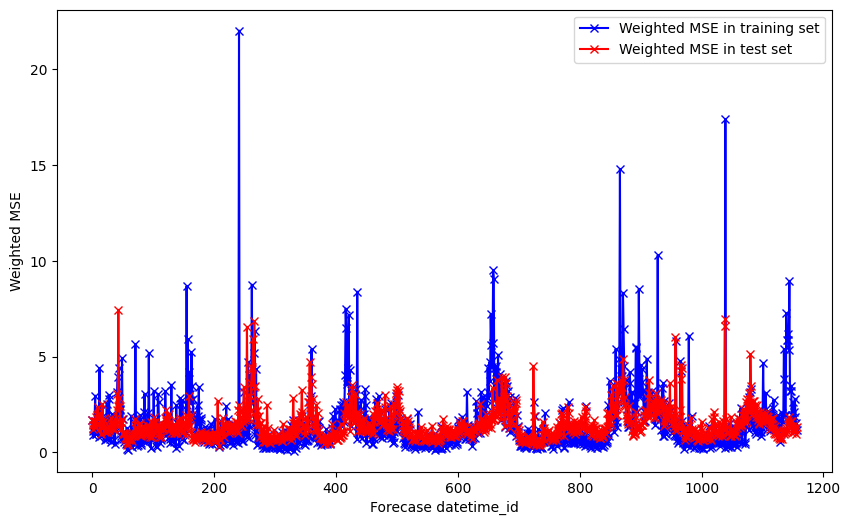

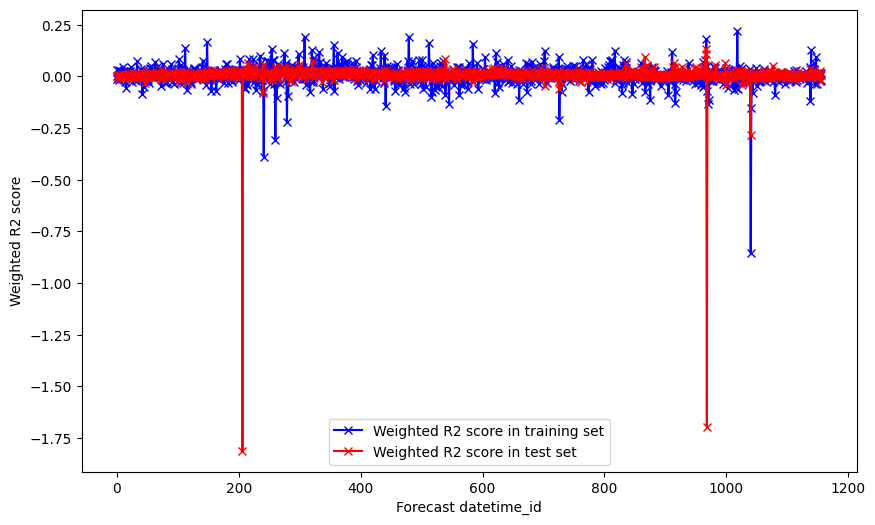

In [11]:
# Plot the results
import matplotlib.pyplot as plt
import pandas as pd
training_period = 1


average_weighted_mse_train = np.mean(train_weighted_mse)
average_weighted_mse_test = np.mean(test_weighted_mse)

average_weighted_r2_score_train = np.mean(train_r2_score)
average_weighted_r2_score_test = np.mean(test_r2_score)
print(f"Average weighted mse in training set: {average_weighted_mse_train}")
print(f"Weighted mse in test set: {average_weighted_mse_test}")
print(f"Average weighted r2_score in training set: {average_weighted_r2_score_train}")
print(f"Weighted r2_score in test set: {average_weighted_r2_score_test}")


mse_loss = pd.DataFrame({"train_weighted_mse" : train_weighted_mse})
mse_loss = mse_loss.set_index(np.arange(len(mse_loss)) * training_period)

r2_score = pd.DataFrame({"train_r2_score" : train_r2_score})
r2_score = r2_score.set_index(np.arange(len(r2_score)) * training_period)

plt.figure(figsize = (10, 6))
plt.plot(mse_loss.index, train_weighted_mse, color = 'blue', marker = 'x', label = 'Weighted MSE in training set')
plt.plot(mse_loss.index, test_weighted_mse, color = 'red', marker = 'x', label = 'Weighted MSE in test set')
plt.legend()
plt.ylabel('Weighted MSE')
plt.xlabel('Forecase datetime_id')
plt.show()

plt.figure(figsize = (10, 6))
plt.plot(r2_score.index, train_r2_score, color = 'blue', marker = 'x', label = 'Weighted R2 score in training set')
plt.plot(r2_score.index, test_r2_score, color = 'red', marker = 'x', label = 'Weighted R2 score in test set')
plt.legend()
plt.ylabel('Weighted R2 score')
plt.xlabel('Forecast datetime_id')
plt.show()
# # Best 
# #Average weighted r2_score in training set: 0.006322467028321948
# #Average weighted r2_score in test set: 0.0061888710218147664

In [12]:
torch.save(model, "model.pth")
print("Model saved")

Model saved
